# 1 Data wrangling<a id='2_Data_wrangling'></a>

The purpose of this data science project is to develop a model to anticipate what inflation in the United States will be measured as the Consumer Price Index for All Urban Consumers in the United States ( “Inflation” ). Inflation is an important component of developing investment strategies for portfolios across the world. The view on inflation being positive or negative is not agreed upon nor are the variables which influence it.

In this project, I have shortlisted <font color=red>**eighteen**</font> ( <font color=red>**18**</font> ) <font color=red>**variables**</font> to determine their influence on inflation.

The fundamental <font color=red>**questions to resolve in this notebook**</font> before we move on are:
   * Are the identified variables correlated with inflation?
   * Is there enough data to build out a model?


## 1.1 Imports & Others <a id='2.3_Imports'></a>

In [490]:
#Import the necessary tools required in the correct lines below
import quandl
from fredapi import Fred
from getpass import getpass
import investpy


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
import lxml
import datetime
import requests
import json
import collections
import seaborn as sns
from scipy import stats
import numpy as np


In [491]:
# These will be needed later

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
today_y_m_d_dash = now.strftime("%Y-%m-%d")
today_d_m_y_dash = now.strftime("%d/%m/%Y")


In [492]:
# Importing Quandl API requires a password
# If you don't have one, please see the link below
# https://docs.quandl.com/docs#section-authentication

my_quandl_API = getpass()

········


In [493]:
quandl.ApiConfig.api_key = my_quandl_API

In [494]:
# Importing FRED API requires a password ( FRED stands for Federal Reserve Economic Data )
# If you don't have one, please see the link below
# https://fred.stlouisfed.org/docs/api/fred/

my_FRED_API = getpass()

········


In [495]:
fred = Fred(api_key=my_FRED_API)

In [496]:
# Here I am structuring a color scale for heatmaps which will be used later

cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


## 1.2 Loaded Data<a id='2.5_Load_The_Ski_Resort_Data'></a>

Please note, I may intend to build another USD Index based on the United States actual engagement in the world.
In other words, the USD Index used ( as of now ), is not based on the United States' trade with the world
I listed below FX pairs to possibly build out a "version" of The [USD Index Trade Weighted](https://en.wikipedia.org/wiki/Trade-weighted_US_dollar_index) but given time constraints I will work with the US Dollar Index ( not trade weighted ) for now.

While the Trade Weighted Index can be accessed by an API ( FRED ), it only goes back to 2006 
so something similar would need be created if time permits. 
My major hurdle at this time is accessing trade data & time.

   * Eurozone, Canada, Japan, Mexico, China, United Kingdom, Taiwan, South Korea, Singapore, Hong Kong, Malaysia, Brazil, Switzerland, Thailand, Philippines, Australia, Indonesia, India, Israel, Saudi Arabia, Russia, Sweden, Argentina, Venezuela, Chile & Colombia


In [497]:
# Daily Data
usd_index = quandl.get('CHRIS/ICE_DX1')
wti = quandl.get('CHRIS/CME_CL1')
copper = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
soybeans = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
natgas = investpy.get_commodity_historical_data(commodity='Natural Gas', from_date='01/01/1978', to_date=today_d_m_y_dash)
heatoil = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
corn = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
wheat = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
cattle = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
sugar = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
lumber = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
leanhogs = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
int_job_claims = quandl.get('FRED/ICSA')

# Monthly Data
cpi = quandl.get('RATEINF/INFLATION_USA')
wages_cpi = fred.get_series('CWSR0000SA0')
cap_util = fred.get_series('TCU')
unrate = quandl.get('FRED/UNRATE')
comppmi = quandl.get('ISM/MAN_PMI')

# Quarterly Data
m2_velo = fred.get_series('M2V')
gdp = fred.get_series('GDP')


In [499]:
# I chose not to not include the below for the reasons listed above their code:

# This may have altered the heatmap w/ M2 Velocity; this was less correlated   
    # us_M2 = fred.get_series('M2')              
# only goes back to 2005
    # steel = investpy.get_commodity_historical_data(commodity='US Midwest Domestic Hot-Rolled Coil Steel Futures', from_date='01/01/1978', to_date=today_d_m_y_dash)
# only goes back to 2005
    # gasoline = investpy.get_commodity_historical_data(commodity='Gasoline RBOB', from_date='01/01/1978', to_date=today_d_m_y_dash)
# only goes back to 2008  
    # oats = investpy.get_commodity_historical_data(commodity='Oats', from_date='01/01/1978', to_date=today_d_m_y_dash)
# this was removed due to amount of data
    # us_wages_hrly_earnings = fred.get_series('CES0500000003')
# poor results
    # us_wages_compensation = fred.get_series('A576RC1')
# only goes back ~2016
    # steel = investpy.get_commodity_historical_data(commodity='US Midwest Domestic Hot-Rolled Coil Steel', from_date='01/01/1978', to_date=today_d_m_y_dash)


In [500]:
# As the purpose of this section is to accumulate all the data into one location to cross reference future works integrity,
# I put all here to referance ( if required ) later.

main_df = pd.concat([cpi,gdp,m2_velo,wages_cpi,wti['Last'],heatoil['Close'],copper['Close'],sugar['Close'],natgas['Close'],
                     cattle['Close'],leanhogs['Close'],soybeans['Close'],lumber['Close'],
                     cap_util,corn['Close'],gdp,m2_velo,wheat['Close'],comppmi['PMI'],usd_index['Settle'],
                     unrate,int_job_claims],
                    axis = 1, ignore_index=False)

main_df = main_df.fillna(method='ffill')
main_df.columns = ['Inflation','Wages CPI','WTI','Heating Oil','Copper','Sugar','Natural Gas','Cattle',
                   'Lean Hogs','Soybeans','Lumber','Capacity Utilization','Corn','GDP','M2 Velocity','GDP',
                   'M2 Velocity','Wheat','PMI','USD Index','Unemployment Rate','Initial Jobless Claims'
                  ]
main_df['Inflation'].index
main_df.index.names = ["Date"]

main_df = main_df[main_df.index.dayofweek < 5]

main_df.sort_values(by="Date", ascending=False)

# I will sometimes take a look to ensure it is working properly
# main_df.tail()
# main_df.head()


Inflation  Wages CPI    WTI  Heating Oil  Copper   Sugar  \
Date                                                                   
2021-03-02       1.40  21487.896  1.134      256.044   60.22  1.8310   
2021-03-01       1.40  21487.896  1.134      256.044   60.22  1.8192   
2021-02-26       1.40  21487.896  1.134      256.044   61.66  1.8565   
2021-02-25       1.40  21487.896  1.134      256.044   63.47  1.9066   
2021-02-24       1.40  21487.896  1.134      256.044   63.45  1.9083   
...               ...        ...    ...          ...     ...     ...   
1914-08-31       3.03        NaN    NaN          NaN     NaN     NaN   
1914-07-31       1.01        NaN    NaN          NaN     NaN     NaN   
1914-06-30       1.02        NaN    NaN          NaN     NaN     NaN   
1914-04-30       0.00        NaN    NaN          NaN     NaN     NaN   
1914-03-31       1.02        NaN    NaN          NaN     NaN     NaN   

            Natural Gas  Cattle  Lean Hogs  Soybeans  ...    Corn      GDP  \
Date                                                  ...                    
2021-03-02       4.1727   16.19      2.836   119.162  ...   965.0  75.5501   
2021-03-01       4.1130   16.21      2.777   118.975  ...   974.0  75.5501   
2021-02-26       4.0925   17.53      2.771   113.100  ...   995.6  75.5501   
2021-02-25       4.2635   17.84      2.777   117.000  ...  1007.0  75.5501   
2021-02-24       4.3040   18.16      2.854   116.575  ...  1010.8  75.5501   
...                 ...     ...        ...       ...  ...     ...      ...   
1914-08-31          NaN     NaN        NaN       NaN  ...     NaN      NaN   
1914-07-31          NaN     NaN        NaN       NaN  ...     NaN      NaN   
1914-06-30          NaN     NaN        NaN       NaN  ...     NaN      NaN   
1914-04-30          NaN     NaN        NaN       NaN  ...     NaN      NaN   
1914-03-31          NaN     NaN        NaN       NaN  ...     NaN      NaN   

            M2 Velocity        GDP  M2 Velocity   Wheat   PMI  USD Index  \
Date                                                                       
2021-03-02       545.10  21487.896        1.134  666.38  58.7     91.036   
2021-03-01       547.50  21487.896        1.134  650.25  58.7     91.036   
2021-02-26       555.50  21487.896        1.134  659.60  58.7     90.882   
2021-02-25       554.75  21487.896        1.134  675.50  58.7     90.135   
2021-02-24       559.25  21487.896        1.134  682.00  58.7     90.170   
...                 ...        ...          ...     ...   ...        ...   
1914-08-31          NaN        NaN          NaN     NaN   NaN        NaN   
1914-07-31          NaN        NaN          NaN     NaN   NaN        NaN   
1914-06-30          NaN        NaN          NaN     NaN   NaN        NaN   
1914-04-30          NaN        NaN          NaN     NaN   NaN        NaN   
1914-03-31          NaN        NaN          NaN     NaN   NaN        NaN   

            Unemployment Rate  Initial Jobless Claims  
Date                                                   
2021-03-02                6.3                730000.0  
2021-03-01                6.3                730000.0  
2021-02-26                6.3                730000.0  
2021-02-25                6.3                730000.0  
2021-02-24                6.3                730000.0  
...                       ...                     ...  
1914-08-31                NaN                     NaN  
1914-07-31                NaN                     NaN  
1914-06-30                NaN                     NaN  
1914-04-30                NaN                     NaN  
1914-03-31                NaN                     NaN  

[11451 rows x 22 columns]

In [502]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11451 entries, 1914-03-31 to 2021-03-02
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               11451 non-null  float64
 1   Wages CPI               11165 non-null  float64
 2   WTI                     10959 non-null  float64
 3   Heating Oil             11165 non-null  float64
 4   Copper                  9773 non-null   float64
 5   Sugar                   10600 non-null  float64
 6   Natural Gas             8416 non-null   float64
 7   Cattle                  10600 non-null  float64
 8   Lean Hogs               7983 non-null   float64
 9   Soybeans                10595 non-null  float64
 10  Lumber                  10600 non-null  float64
 11  Capacity Utilization    8049 non-null   float64
 12  Corn                    10600 non-null  float64
 13  GDP                     10821 non-null  float64
 14  M2 Velocity          

`Inflation` has by and large the most data while `Natural Gas` has the least. Let's move forward with using the `Natural Gas` amount limitations.

I will move forward with only the data where all information is present with no null values

In [503]:
main_df = main_df.loc['1990-04-04':today_y_m_d_dash]

# The reason 1990 was chosen is becuase Natural Gas only goes back that far; take a look if you wish 
# natgas.head()

In [504]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7983 entries, 1990-04-04 to 2021-03-02
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               7983 non-null   float64
 1   Wages CPI               7983 non-null   float64
 2   WTI                     7983 non-null   float64
 3   Heating Oil             7983 non-null   float64
 4   Copper                  7983 non-null   float64
 5   Sugar                   7983 non-null   float64
 6   Natural Gas             7983 non-null   float64
 7   Cattle                  7983 non-null   float64
 8   Lean Hogs               7983 non-null   float64
 9   Soybeans                7983 non-null   float64
 10  Lumber                  7983 non-null   float64
 11  Capacity Utilization    7983 non-null   float64
 12  Corn                    7983 non-null   float64
 13  GDP                     7983 non-null   float64
 14  M2 Velocity           

In [505]:
cd

C:\Users\rands


In [506]:
# Here I am saving the non-adjusted ( raw ) data to investigate whether the adjustments further along yield correctly

main_df = main_df.sort_values(by="Date", ascending=False)

main_df_csv = pd.DataFrame(main_df)
main_df_csv.to_excel('./_Capstone_One_Inflation/data/main_df_csv_w_commodities.xlsx')
print('Finished; keep going!')

Finished; keep going!


# 1.3.1 Q on Q Comparison

In 1.3.1 I will be setting up the infrastructure for **comparing quarterly changes on all variables** against a **quarterly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [507]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi = cpi.diff(periods=3)
Q_unrate = unrate.diff(periods=3)
Q_comppmi = comppmi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)


In [509]:
# ( Complete ) The above were slow reviewed & they all align with the forward fill modus operandi 

QonQ_vars = pd.concat([Q_wages,Q_wti,Q_heatoil,Q_copper,Q_sugar,
                     Q_natgas,Q_cattle,Q_leanhogs,Q_soybeans,Q_lumber,
                     Q_caputil,Q_corn,Q_gdp,Q_m2_velo,Q_wheat,Q_comppmi,
                      Q_usd_index,Q_intjobs,Q_unrate],
                      axis = 1, ignore_index=False)

QonQ_vars = QonQ_vars.fillna(method='ffill')
QonQ_vars.columns = ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat','PMI',
                     'USD Index','Initial Jobless Claims','Unemployment Rate']

QonQ_vars.dropna(how='any')
QonQ_vars.index.names = ["Date"]

QonQ_vars = QonQ_vars[QonQ_vars.index.dayofweek < 5]

QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=True)

In [510]:
# Determining the null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10882 entries, 1946-01-01 to 2021-03-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                10877 non-null  float64
 1   WTI                     9703 non-null   float64
 2   Heating Oil             10528 non-null  float64
 3   Copper                  8347 non-null   float64
 4   Sugar                   10528 non-null  float64
 5   Natural Gas             7911 non-null   float64
 6   Cattle                  10525 non-null  float64
 7   Lean Hogs               10529 non-null  float64
 8   Soybeans                7980 non-null   float64
 9   Lumber                  10529 non-null  float64
 10  Capacity Utilization    10704 non-null  float64
 11  Corn                    10527 non-null  float64
 12  GDP                     10877 non-null  float64
 13  M2 Velocity             10775 non-null  float64
 14  Wheat                

In [511]:
# As previously mentioned, Natural Gas limits this Dataframe
# Thus, the reason 1990-07-10 was chosen is becuase Natural Gas only goes back that far 

QonQ_vars = QonQ_vars.loc['1990-07-10':today_y_m_d_dash]

In [512]:
# Double confirming no null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7911 entries, 1990-07-10 to 2021-03-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                7911 non-null   float64
 1   WTI                     7911 non-null   float64
 2   Heating Oil             7911 non-null   float64
 3   Copper                  7911 non-null   float64
 4   Sugar                   7911 non-null   float64
 5   Natural Gas             7911 non-null   float64
 6   Cattle                  7911 non-null   float64
 7   Lean Hogs               7911 non-null   float64
 8   Soybeans                7911 non-null   float64
 9   Lumber                  7911 non-null   float64
 10  Capacity Utilization    7911 non-null   float64
 11  Corn                    7911 non-null   float64
 12  GDP                     7911 non-null   float64
 13  M2 Velocity             7911 non-null   float64
 14  Wheat                 

Saving the Variables for later use to confirm rolling averages.

In [513]:
QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=False)
QonQ_vars_csv = pd.DataFrame(QonQ_vars)

QonQ_vars_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_vars.xlsx')
print('Finished; keep going!')

Finished; keep going!


Now that the variables are in place, I will pull `Inflation` in with them via a merge to ensure the variables are working off the `Inflation` set. 

In [514]:
QonQ_main = Q_cpi.merge(QonQ_vars, how='left', on='Date')

# QonQ_forward.loc[:,cols_forward] = QonQ.loc[:,cols_forward].ffill()
QonQ_main.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate']

QonQ_main = QonQ_main.dropna()

In [515]:
QonQ_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 1990-07-31 to 2020-12-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               259 non-null    float64
 1   Wage CPI                259 non-null    float64
 2   WTI                     259 non-null    float64
 3   Heating Oil             259 non-null    float64
 4   Copper                  259 non-null    float64
 5   Sugar                   259 non-null    float64
 6   Natural Gas             259 non-null    float64
 7   Cattle                  259 non-null    float64
 8   Lean Hogs               259 non-null    float64
 9   Soybeans                259 non-null    float64
 10  Lumber                  259 non-null    float64
 11  Capacity Utilization    259 non-null    float64
 12  Corn                    259 non-null    float64
 13  GDP                     259 non-null    float64
 14  M2 Velocity            

# 1.3.1.2 Cleaning the Q on Q Dataframe for outliers 

Here I begin to determine where outliers are:

In [516]:
QonQ_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.717374  0.347553     0.425767  0.221556   
Wage CPI                 0.717374  1.000000  0.410007     0.501180  0.326784   
WTI                      0.347553  0.410007  1.000000     0.801081  0.427700   
Heating Oil              0.425767  0.501180  0.801081     1.000000  0.417235   
Copper                   0.221556  0.326784  0.427700     0.417235  1.000000   
Sugar                    0.151809  0.188646  0.180981     0.168726  0.255090   
Natural Gas              0.298157  0.306310  0.250464     0.412958  0.087862   
Cattle                   0.165345  0.201202  0.155744     0.151078  0.120683   
Lean Hogs                0.177281  0.114211  0.125411     0.087197  0.146652   
Soybeans                 0.058990  0.134259  0.151827     0.169757  0.207905   
Lumber                   0.127012  0.099173  0.279960     0.137156  0.207631   
Capacity Utilization     0.284801  0.240888  0.423042     0.369393  0.247462   
Corn                     0.075774  0.068514  0.034765     0.049336  0.107980   
GDP                      0.268360  0.285221  0.292195     0.249528  0.153798   
M2 Velocity              0.254821  0.305211  0.180316     0.234727  0.139113   
Wheat                   -0.037458 -0.003795 -0.013760     0.000361  0.082159   
PMI                      0.135472  0.229624  0.394224     0.328132  0.463860   
USD Index               -0.220835 -0.295176 -0.270599    -0.309808 -0.351754   
Initial Jobless Claims  -0.089727 -0.086933 -0.429905    -0.275829 -0.171519   
Unemployment Rate       -0.250500 -0.229621 -0.259232    -0.250005 -0.092123   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.151809     0.298157  0.165345   0.177281  0.058990   
Wage CPI                0.188646     0.306310  0.201202   0.114211  0.134259   
WTI                     0.180981     0.250464  0.155744   0.125411  0.151827   
Heating Oil             0.168726     0.412958  0.151078   0.087197  0.169757   
Copper                  0.255090     0.087862  0.120683   0.146652  0.207905   
Sugar                   1.000000     0.150063  0.028733  -0.086056  0.136992   
Natural Gas             0.150063     1.000000  0.015283   0.024183  0.058428   
Cattle                  0.028733     0.015283  1.000000   0.176569  0.088762   
Lean Hogs              -0.086056     0.024183  0.176569   1.000000  0.206747   
Soybeans                0.136992     0.058428  0.088762   0.206747  1.000000   
Lumber                  0.087038    -0.068966  0.195019   0.166738  0.197829   
Capacity Utilization    0.183948     0.128484  0.315213   0.154603  0.141625   
Corn                    0.078851     0.075419  0.031467   0.235256  0.707152   
GDP                     0.128054     0.101976  0.248577   0.159692  0.054263   
M2 Velocity             0.107573     0.086343  0.206946   0.121656  0.039691   
Wheat                   0.086394     0.011773  0.012129   0.033494  0.434461   
PMI                     0.151020     0.034109  0.185397   0.103924  0.146439   
USD Index              -0.140455    -0.240528 -0.049553   0.039408 -0.143919   
Initial Jobless Claims -0.128357    -0.051962 -0.175781  -0.048307 -0.051853   
Unemployment Rate      -0.119909    -0.064724 -0.285768  -0.127586 -0.066285   

                          Lumber  Capacity Utilization      Corn       GDP  \
Inflation               0.127012              0.284801  0.075774  0.268360   
Wage CPI                0.099173              0.240888  0.068514  0.285221   
WTI                     0.279960              0.423042  0.034765  0.292195   
Heating Oil             0.137156              0.369393  0.049336  0.249528   
Copper                  0.207631              0.247462  0.107980  0.153798   
Sugar                   0.087038              0.183948  0.078851  0.128054   
Natural Gas            -0.068966              0.128484  0.075419  0.101976   
Cattle                  0.195019      

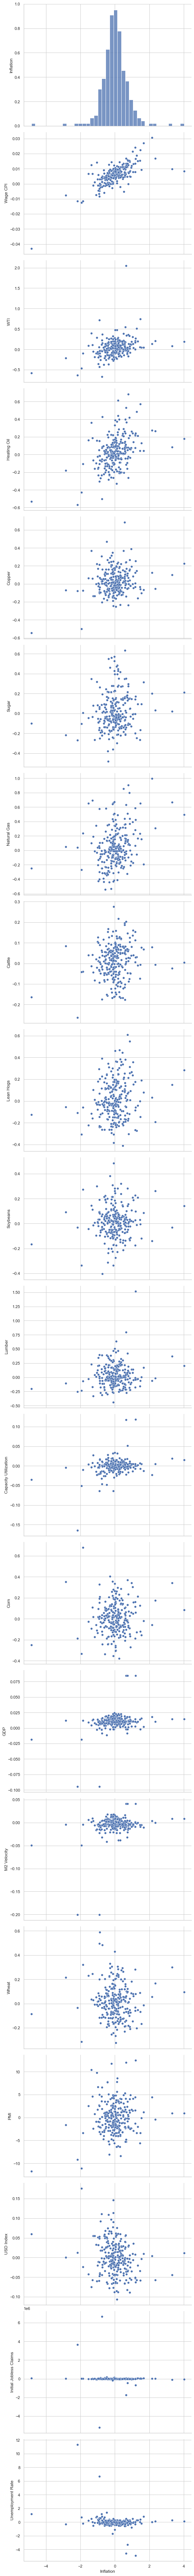

In [519]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

We can see a **notable amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram.

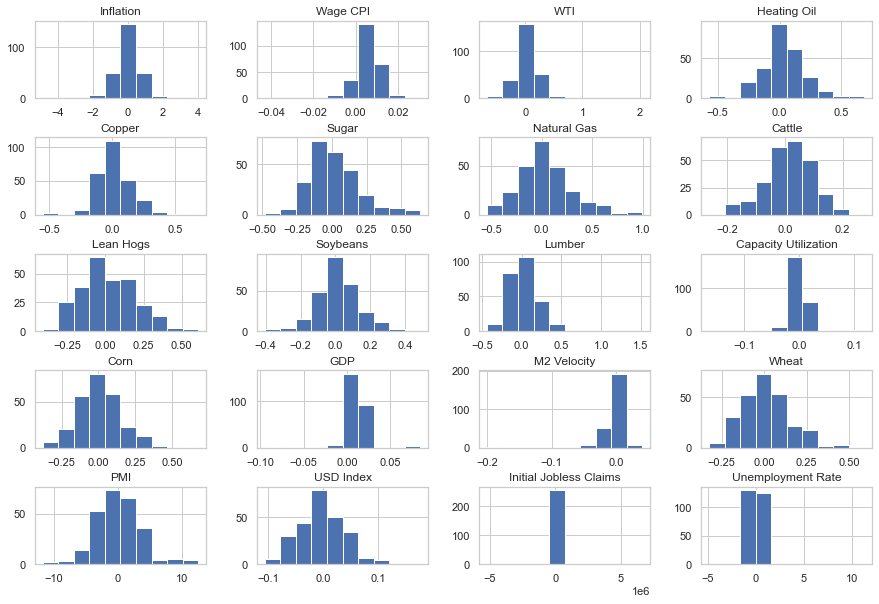

In [520]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

Text(0, 0.5, 'Count')

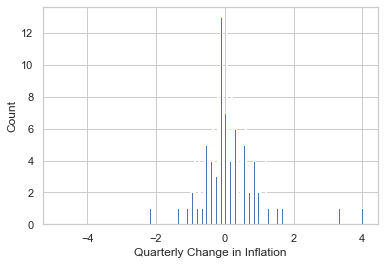

In [521]:
plt.hist(QonQ_main['Inflation'], bins=240)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

It may appear that we scrape anything ± 300 bps

In [522]:
cpi_comp = np.abs(stats.zscore(QonQ_main['Inflation']))
threshold = 3
print(np.where( cpi_comp > threshold ))

(array([137, 156, 163, 164], dtype=int64),)


In [523]:
QonQ_main['Inflation'][137], QonQ_main['Inflation'][156], QonQ_main['Inflation'][163],QonQ_main['Inflation'][164]

(-2.84, -4.846, 3.322, 4.007)

We will pull ~3 off ( -4.846, 3.322, 4.007 )

In [524]:
droprows = [156, 163, 164]
QonQ_main.drop(QonQ_main.index[droprows], inplace=True)

Text(0, 0.5, 'Count')

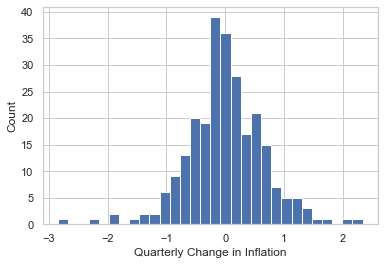

In [525]:
plt.hist(QonQ_main['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

After removing the outliers of Inflation, let's see how the pair plots & histograms hold up.

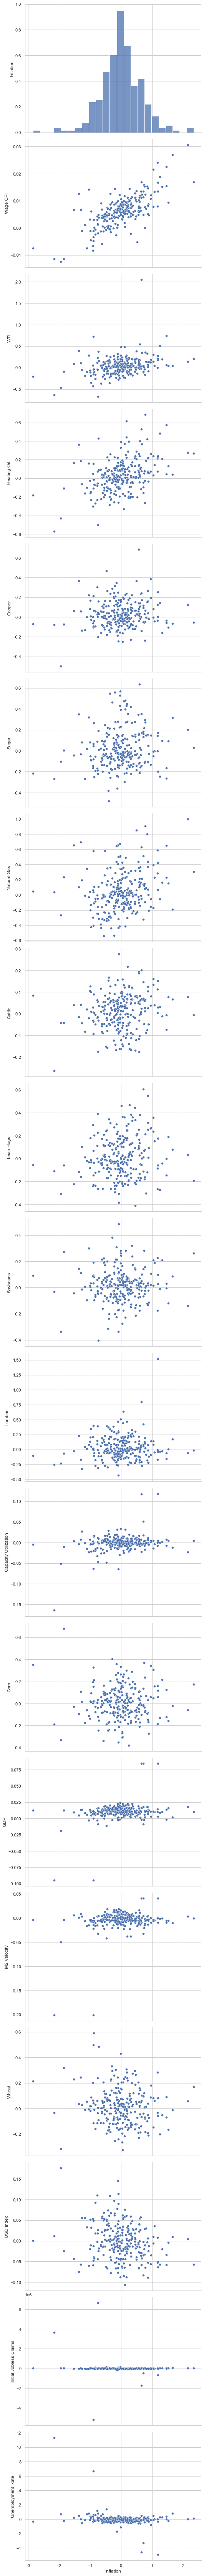

In [526]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

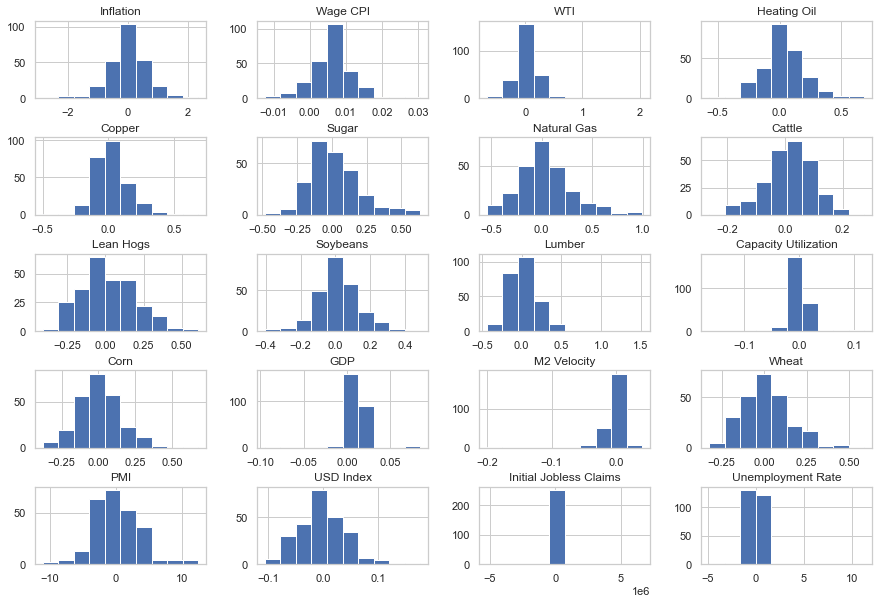

In [527]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

In [528]:
QonQ_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.714682  0.324981     0.406480  0.107570   
Wage CPI                 0.714682  1.000000  0.377934     0.472546  0.237934   
WTI                      0.324981  0.377934  1.000000     0.793927  0.400628   
Heating Oil              0.406480  0.472546  0.793927     1.000000  0.384046   
Copper                   0.107570  0.237934  0.400628     0.384046  1.000000   
Sugar                    0.139928  0.191947  0.174583     0.161312  0.249165   
Natural Gas              0.247702  0.308960  0.240542     0.407202  0.059101   
Cattle                   0.150359  0.159910  0.136934     0.129879  0.092240   
Lean Hogs                0.142394  0.099349  0.114789     0.073705  0.129564   
Soybeans                 0.012778  0.103869  0.136876     0.153364  0.187984   
Lumber                   0.067501  0.069887  0.270985     0.122213  0.189932   
Capacity Utilization     0.258689  0.213317  0.411569     0.354898  0.223400   
Corn                    -0.014446  0.012955  0.013231     0.024631  0.076253   
GDP                      0.253530  0.253483  0.275172     0.229131  0.123115   
M2 Velocity              0.221250  0.273642  0.158874     0.211986  0.104183   
Wheat                   -0.117855 -0.034058 -0.025017    -0.012730  0.066629   
PMI                      0.059739  0.152829  0.371869     0.299562  0.434803   
USD Index               -0.214744 -0.288687 -0.261291    -0.300599 -0.344100   
Initial Jobless Claims  -0.100083 -0.095907 -0.435650    -0.280212 -0.176179   
Unemployment Rate       -0.276595 -0.221950 -0.251519    -0.241714 -0.077065   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.139928     0.247702  0.150359   0.142394  0.012778   
Wage CPI                0.191947     0.308960  0.159910   0.099349  0.103869   
WTI                     0.174583     0.240542  0.136934   0.114789  0.136876   
Heating Oil             0.161312     0.407202  0.129879   0.073705  0.153364   
Copper                  0.249165     0.059101  0.092240   0.129564  0.187984   
Sugar                   1.000000     0.143432  0.024100  -0.095045  0.130424   
Natural Gas             0.143432     1.000000  0.010920   0.004756  0.050178   
Cattle                  0.024100     0.010920  1.000000   0.174316  0.077689   
Lean Hogs              -0.095045     0.004756  0.174316   1.000000  0.199947   
Soybeans                0.130424     0.050178  0.077689   0.199947  1.000000   
Lumber                  0.081588    -0.097417  0.192366   0.155906  0.193508   
Capacity Utilization    0.178511     0.110471  0.308097   0.144237  0.132062   
Corn                    0.073707     0.046288  0.021372   0.225687  0.714506   
GDP                     0.123150     0.091412  0.235662   0.153183  0.042151   
M2 Velocity             0.101041     0.069900  0.193767   0.111644  0.026214   
Wheat                   0.083316    -0.012816  0.009914   0.022969  0.437927   
PMI                     0.145315     0.016850  0.163719   0.094043  0.130863   
USD Index              -0.139281    -0.233035 -0.040253   0.045578 -0.140317   
Initial Jobless Claims -0.128047    -0.050363 -0.177138  -0.047235 -0.051511   
Unemployment Rate      -0.118034    -0.064346 -0.278617  -0.126438 -0.059977   

                          Lumber  Capacity Utilization      Corn       GDP  \
Inflation               0.067501              0.258689 -0.014446  0.253530   
Wage CPI                0.069887              0.213317  0.012955  0.253483   
WTI                     0.270985              0.411569  0.013231  0.275172   
Heating Oil             0.122213              0.354898  0.024631  0.229131   
Copper                  0.189932              0.223400  0.076253  0.123115   
Sugar                   0.081588              0.178511  0.073707  0.123150   
Natural Gas            -0.097417              0.110471  0.046288  0.091412   
Cattle                  0.192366      

{'whiskers': [<matplotlib.lines.Line2D at 0x1c8a5768af0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c8a5785640>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c8a57688b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c8a5785be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c8a5785f10>],
 'means': []}

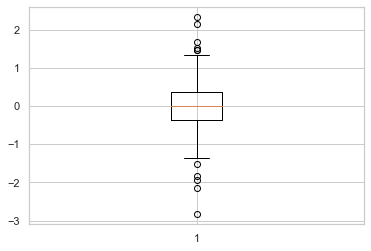

In [529]:
plt.boxplot(QonQ_main['Inflation'])

Text(0.5, 1.0, 'Quarter on Quarter Comparison')

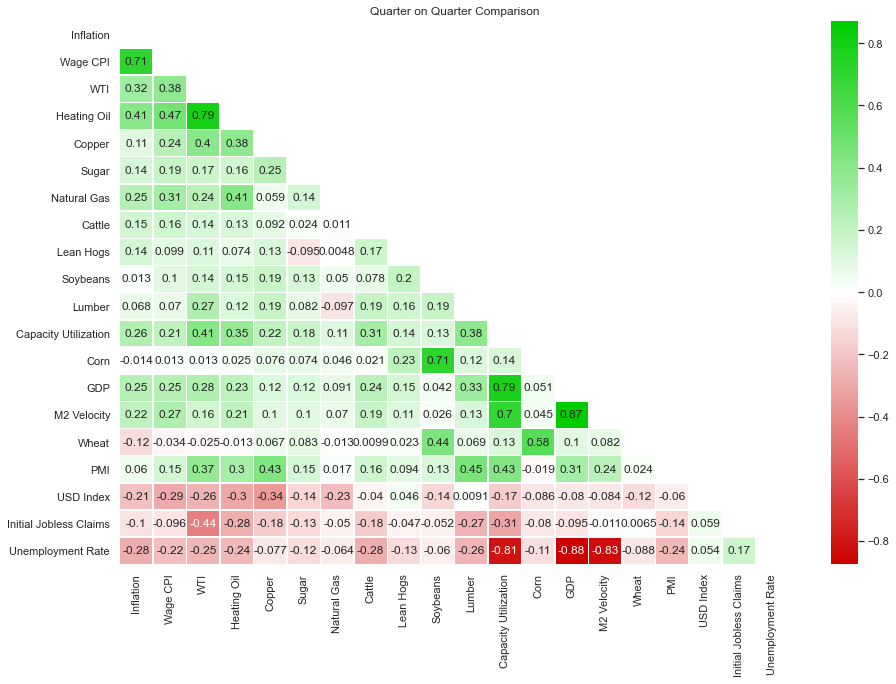

In [530]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main.corr())
sns.heatmap(QonQ_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison')

In [531]:
QonQ_main = QonQ_main.sort_values(by="Date", ascending=True)
QonQ_main_csv = pd.DataFrame(QonQ_main)

QonQ_main_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main.xlsx')
print('Finished')

Finished


# 1.3.2 Monthly Changes<a id='2.5_Load_The_Ski_Resort_Data'></a>

In 1.3.2 I will be setting up the infrastructure for **comparing monthly changes on all variables** against a **monthly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [532]:
# ( Complete ) Daily | USD & WTI 
M_usd_index = usd_index['Settle'].pct_change(periods=30)
M_wti = wti['Last'].pct_change(periods=30)
M_copper = copper['Close'].pct_change(periods=30)
M_soybeans = soybeans['Close'].pct_change(periods=30)
M_natgas = natgas['Close'].pct_change(periods=30)
M_heatoil = heatoil['Close'].pct_change(periods=30)
M_corn = corn['Close'].pct_change(periods=30)
M_wheat = wheat['Close'].pct_change(periods=30)
M_cattle = cattle['Close'].pct_change(periods=30)
M_sugar = sugar['Close'].pct_change(periods=30)
M_lumber = lumber['Close'].pct_change(periods=30)
M_leanhogs = leanhogs['Close'].pct_change(periods=30)

# ( Complete ) Weekly | Initial Jobless Claims
M_intjobs = int_job_claims.diff(periods=4)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
M_caputil = cap_util.pct_change(periods=1)
M_wages = wages_cpi.pct_change(periods=1)
M_cpi = cpi.diff(periods=1)
M_unrate = unrate.diff(periods=1)


# ( Complete ) Quarterly | GDP, Velocity of Money
# M_gdp = us_gdp.pct_change(periods=1)
# M_m2_velo = m2_velo.pct_change(periods=1)

In [533]:
# Building out the variables first with a forward fill
MonM_vars = pd.concat([M_wages,M_wti,M_copper,M_soybeans,M_natgas,
                       M_heatoil,M_corn,M_wheat,M_cattle,M_leanhogs,M_sugar,
                       M_lumber,M_caputil,M_usd_index,M_intjobs,M_unrate
                      ],
                      axis = 1, ignore_index=False)

MonM_vars.columns= ['Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'
                   ]

MonM_vars.index.names = ["Date"]
MonM_vars = MonM_vars.fillna(method='ffill')

# vars_mnth.tail()

In [534]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14115 entries, 1947-01-01 to 2021-03-02
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                14114 non-null  float64
 1   WTI                     12027 non-null  float64
 2   Copper                  10382 non-null  float64
 3   Soybeans                9939 non-null   float64
 4   Natural Gas             9858 non-null   float64
 5   Heating Oil             13027 non-null  float64
 6   Corn                    13026 non-null  float64
 7   Wheat                   9939 non-null   float64
 8   Cattle                  13024 non-null  float64
 9   Lean Hogs               13029 non-null  float64
 10  Sugar                   13029 non-null  float64
 11  Lumber                  13029 non-null  float64
 12  Capacity Utilization    13870 non-null  float64
 13  USD Index               11211 non-null  float64
 14  Initial Jobless Claim

In [535]:
# As before, working backwards off of Natural Gas to bring the data together
# MonM_vars['Natural Gas'].tail(8302)

MonM_vars = MonM_vars.loc['1990-05-17':today_y_m_d_dash]

In [536]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9858 entries, 1990-05-17 to 2021-03-02
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                9858 non-null   float64
 1   WTI                     9858 non-null   float64
 2   Copper                  9858 non-null   float64
 3   Soybeans                9858 non-null   float64
 4   Natural Gas             9858 non-null   float64
 5   Heating Oil             9858 non-null   float64
 6   Corn                    9858 non-null   float64
 7   Wheat                   9858 non-null   float64
 8   Cattle                  9858 non-null   float64
 9   Lean Hogs               9858 non-null   float64
 10  Sugar                   9858 non-null   float64
 11  Lumber                  9858 non-null   float64
 12  Capacity Utilization    9858 non-null   float64
 13  USD Index               9858 non-null   float64
 14  Initial Jobless Claims

In [537]:
# Putting them together with inflation
MonM_main = M_cpi.merge(MonM_vars, how='left', on='Date')

MonM_main = MonM_main[MonM_main.index.dayofweek < 5]

MonM_main.columns = ['Inflation','Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'
                    ]

MonM_main = MonM_main.dropna()

In [538]:
MonM_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 1990-05-31 to 2020-12-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               260 non-null    float64
 1   Wage CPI                260 non-null    float64
 2   WTI                     260 non-null    float64
 3   Copper                  260 non-null    float64
 4   Soybeans                260 non-null    float64
 5   Natural Gas             260 non-null    float64
 6   Heating Oil             260 non-null    float64
 7   Corn                    260 non-null    float64
 8   Wheat                   260 non-null    float64
 9   Cattle                  260 non-null    float64
 10  Lean Hogs               260 non-null    float64
 11  Sugar                   260 non-null    float64
 12  Lumber                  260 non-null    float64
 13  Capacity Utilization    260 non-null    float64
 14  USD Index              

# 1.3.2.2 Cleaning the M on M Dataframe for outliers 

Here I begin to determine where outliers are:

In [539]:
MonM_main.corr(method='pearson')

Inflation  Wage CPI       WTI    Copper  Soybeans  \
Inflation                1.000000  0.709537  0.292187  0.117664  0.080194   
Wage CPI                 0.709537  1.000000  0.364418  0.206845  0.081559   
WTI                      0.292187  0.364418  1.000000  0.384297  0.123567   
Copper                   0.117664  0.206845  0.384297  1.000000  0.243327   
Soybeans                 0.080194  0.081559  0.123567  0.243327  1.000000   
Natural Gas              0.137183  0.152236  0.230212  0.009313  0.050035   
Heating Oil              0.307840  0.386575  0.827887  0.342839  0.139177   
Corn                     0.054724 -0.001987  0.050932  0.101879  0.670592   
Wheat                   -0.049427 -0.012168 -0.036583  0.057647  0.424675   
Cattle                   0.024347  0.079468  0.085183  0.127847  0.091984   
Lean Hogs                0.048417  0.003978  0.066520  0.151706  0.163542   
Sugar                    0.147915  0.141510  0.111835  0.199234  0.158368   
Lumber                   0.186274  0.151202  0.160139  0.194249  0.153085   
Capacity Utilization     0.248983  0.229097  0.205434  0.092737  0.076851   
USD Index               -0.112935 -0.172862 -0.267559 -0.269324 -0.145117   
Initial Jobless Claims  -0.044121 -0.021465 -0.259514 -0.135772  0.004533   
Unemployment Rate       -0.262957 -0.252149 -0.137951 -0.012393 -0.067502   

                        Natural Gas  Heating Oil      Corn     Wheat  \
Inflation                  0.137183     0.307840  0.054724 -0.049427   
Wage CPI                   0.152236     0.386575 -0.001987 -0.012168   
WTI                        0.230212     0.827887  0.050932 -0.036583   
Copper                     0.009313     0.342839  0.101879  0.057647   
Soybeans                   0.050035     0.139177  0.670592  0.424675   
Natural Gas                1.000000     0.317274  0.068578  0.024085   
Heating Oil                0.317274     1.000000  0.061041  0.022313   
Corn                       0.068578     0.061041  1.000000  0.564109   
Wheat                      0.024085     0.022313  0.564109  1.000000   
Cattle                    -0.054093     0.077321 -0.032945  0.034200   
Lean Hogs                  0.058867     0.022929  0.130425  0.032638   
Sugar                      0.082055     0.103574  0.100097  0.098145   
Lumber                    -0.054959     0.094411  0.085051  0.062945   
Capacity Utilization      -0.005891     0.220972  0.099385  0.063741   
USD Index                 -0.140661    -0.188047 -0.096376 -0.065288   
Initial Jobless Claims    -0.083945    -0.144416 -0.027489  0.056499   
Unemployment Rate          0.022622    -0.170258 -0.120025 -0.079560   

                          Cattle  Lean Hogs     Sugar    Lumber  \
Inflation               0.024347   0.048417  0.147915  0.186274   
Wage CPI                0.079468   0.003978  0.141510  0.151202   
WTI                     0.085183   0.066520  0.111835  0.160139   
Copper                  0.127847   0.151706  0.199234  0.194249   
Soybeans                0.091984   0.163542  0.158368  0.153085   
Natural Gas            -0.054093   0.058867  0.082055 -0.054959   
Heating Oil             0.077321   0.022929  0.103574  0.094411   
Corn                   -0.032945   0.130425  0.100097  0.085051   
Wheat                   0.034200   0.032638  0.098145  0.062945   
Cattle                  1.000000   0.180542  0.077874  0.143381   
Lean Hogs               0.180542   1.000000 -0.038217  0.065568   
Sugar                   0.077874  -0.038217  1.000000  0.029830   
Lumber                  0.143381   0.065568  0.029830  1.000000   
Capacity Utilization    0.115595   0.021354  0.110350  0.212566   
USD Index              -0.021208   0.015830 -0.086499 -0.017884   
Initial Jobless Claims -0.132475  -0.085045 -0.161921 -0.193348   
Unemployment Rate      -0.068519  -0.034059 -0.042495 -0.124490   

                        Capacity Utilization  USD Index  \
Inflation                           0.248983  -0.112935   
Wage CPI       

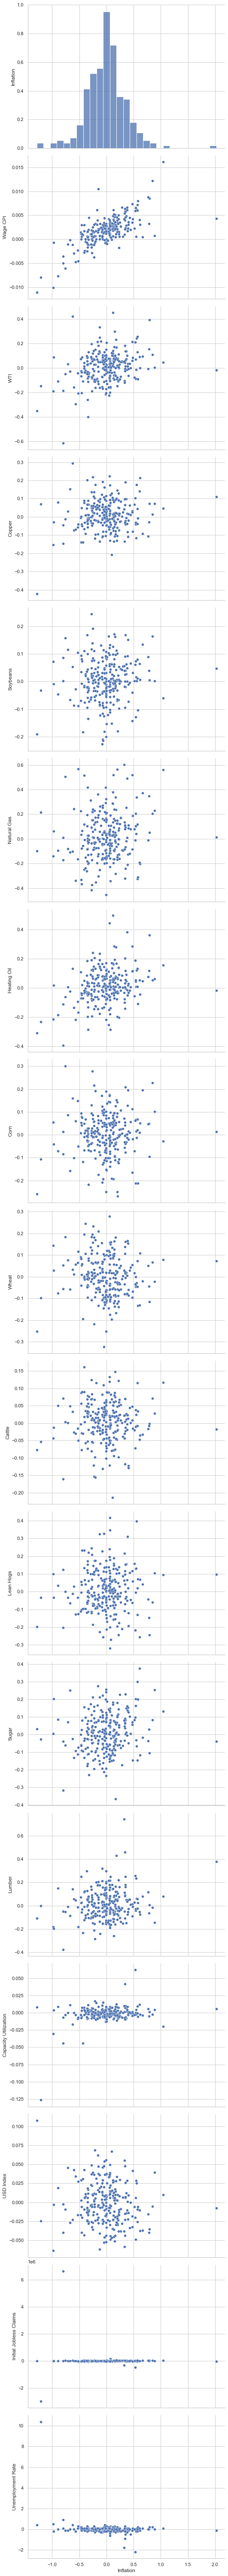

In [540]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

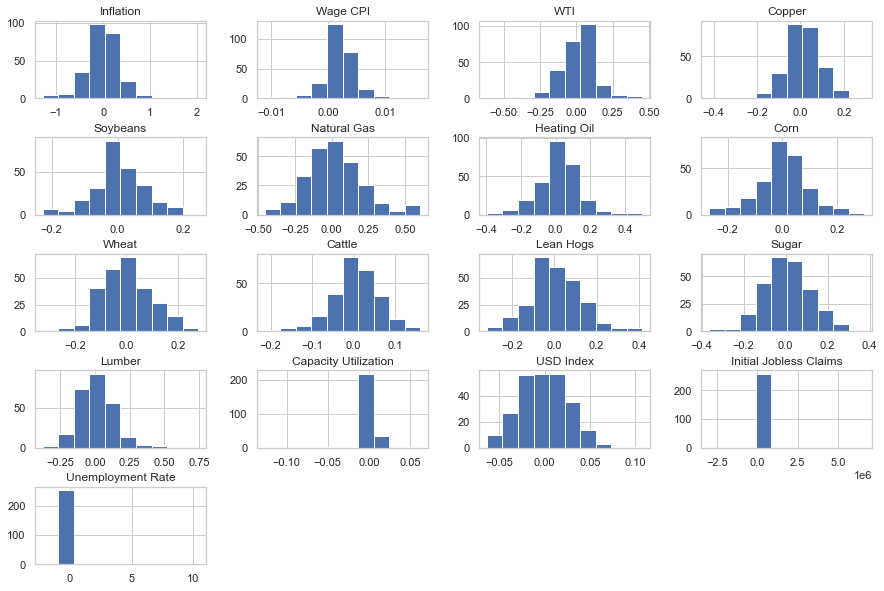

In [541]:
MonM_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

We see **"some" amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram again.

Text(0, 0.5, 'Count')

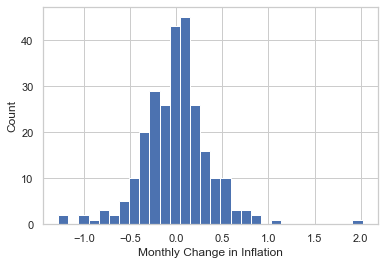

In [542]:
plt.hist(MonM_main['Inflation'], bins=30)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Count')

**There doesn't seem to be as much variation here as well.** Let's take a look at what those numbers are.

In [543]:
print('Min # is:', MonM_main['Inflation'].min(), 'Max # is:', MonM_main['Inflation'].max())

Min # is: -1.2820000000000005 Max # is: 2.021


Based on this, I will choose to remove the data point ~2

In [544]:
cpi_check = np.abs(stats.zscore(MonM_main['Inflation']))
threshold = 3
print(np.where(cpi_check > threshold))

(array([156, 164, 253], dtype=int64),)


In [545]:
MonM_main['Inflation'][156],MonM_main['Inflation'][164],MonM_main['Inflation'][253]

(-1.2820000000000005, 2.021, -1.21)

In [546]:
droprow = [164]
MonM_main.drop(MonM_main.index[droprow], inplace=True)

Checking the pair plots & histogram once more.

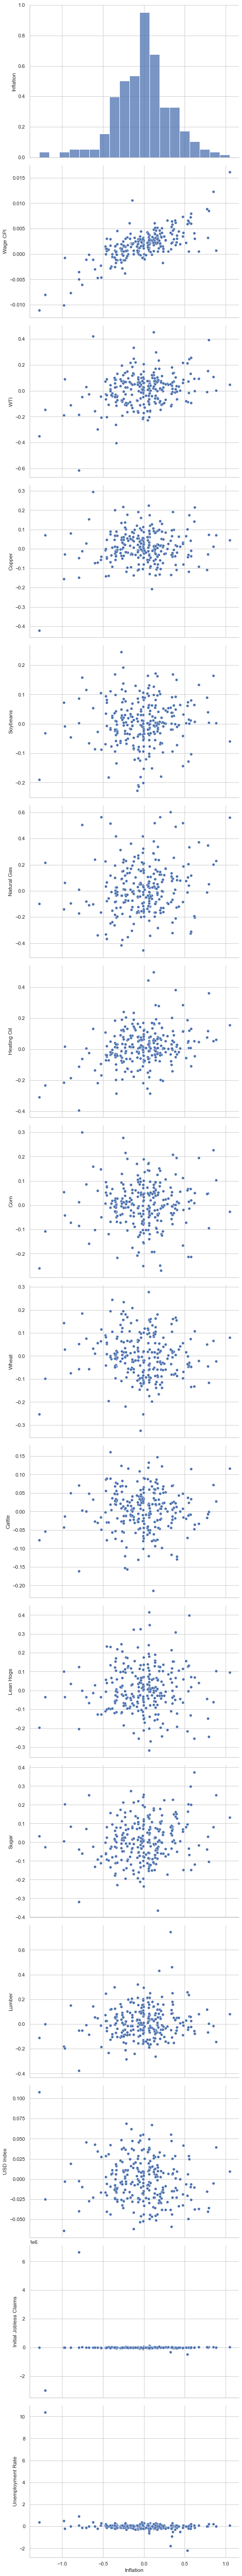

In [547]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

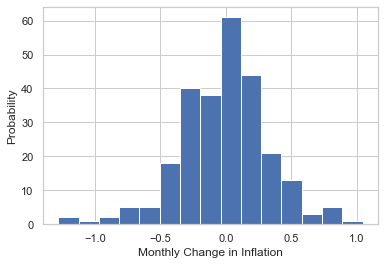

In [548]:
plt.hist(MonM_main['Inflation'], bins=15)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Probability')

Not perfectly normal but we will proceed.

In [549]:
MonM_main.corr(method='pearson')

Inflation  Wage CPI       WTI    Copper  Soybeans  \
Inflation                1.000000  0.738433  0.316557  0.098236  0.072840   
Wage CPI                 0.738433  1.000000  0.365632  0.203881  0.079959   
WTI                      0.316557  0.365632  1.000000  0.386433  0.124127   
Copper                   0.098236  0.203881  0.386433  1.000000  0.241581   
Soybeans                 0.072840  0.079959  0.124127  0.241581  1.000000   
Natural Gas              0.147131  0.152561  0.230201  0.009523  0.050149   
Heating Oil              0.334497  0.388011  0.827850  0.345123  0.139870   
Corn                     0.056072 -0.002302  0.051022  0.101708  0.670791   
Wheat                   -0.069988 -0.014584 -0.035981  0.054382  0.423782   
Cattle                   0.034864  0.080827  0.084882  0.130041  0.092895   
Lean Hogs                0.034798  0.001655  0.067227  0.148876  0.162238   
Sugar                    0.167506  0.143099  0.111518  0.201839  0.159430   
Lumber                   0.136458  0.144728  0.165072  0.184623  0.149472   
Capacity Utilization     0.252918  0.227783  0.206047  0.090496  0.075764   
USD Index               -0.114967 -0.172356 -0.267817 -0.269006 -0.144713   
Initial Jobless Claims  -0.044166 -0.021098 -0.259654 -0.135575  0.004803   
Unemployment Rate       -0.276446 -0.251959 -0.138116 -0.011649 -0.067186   

                        Natural Gas  Heating Oil      Corn     Wheat  \
Inflation                  0.147131     0.334497  0.056072 -0.069988   
Wage CPI                   0.152561     0.388011 -0.002302 -0.014584   
WTI                        0.230201     0.827850  0.051022 -0.035981   
Copper                     0.009523     0.345123  0.101708  0.054382   
Soybeans                   0.050149     0.139870  0.670791  0.423782   
Natural Gas                1.000000     0.317279  0.068595  0.024227   
Heating Oil                0.317279     1.000000  0.061157  0.023143   
Corn                       0.068595     0.061157  1.000000  0.564450   
Wheat                      0.024227     0.023143  0.564450  1.000000   
Cattle                    -0.054168     0.076941 -0.032807  0.035376   
Lean Hogs                  0.059041     0.023740  0.130284  0.030570   
Sugar                      0.082018     0.103170  0.100297  0.099528   
Lumber                    -0.055373     0.098917  0.085288  0.055731   
Capacity Utilization      -0.005810     0.221721  0.099236  0.062248   
USD Index                 -0.140713    -0.188347 -0.096298 -0.064679   
Initial Jobless Claims    -0.083967    -0.144574 -0.027443  0.056926   
Unemployment Rate          0.022597    -0.170472 -0.119970 -0.079164   

                          Cattle  Lean Hogs     Sugar    Lumber  \
Inflation               0.034864   0.034798  0.167506  0.136458   
Wage CPI                0.080827   0.001655  0.143099  0.144728   
WTI                     0.084882   0.067227  0.111518  0.165072   
Copper                  0.130041   0.148876  0.201839  0.184623   
Soybeans                0.092895   0.162238  0.159430  0.149472   
Natural Gas            -0.054168   0.059041  0.082018 -0.055373   
Heating Oil             0.076941   0.023740  0.103170  0.098917   
Corn                   -0.032807   0.130284  0.100297  0.085288   
Wheat                   0.035376   0.030570  0.099528  0.055731   
Cattle                  1.000000   0.181887  0.077284  0.149907   
Lean Hogs               0.181887   1.000000 -0.037057  0.058579   
Sugar                   0.077284  -0.037057  1.000000  0.034991   
Lumber                  0.149907   0.058579  0.034991  1.000000   
Capacity Utilization    0.116523   0.019824  0.111362  0.209939   
USD Index              -0.021571   0.016519 -0.086929 -0.015567   
Initial Jobless Claims -0.132705  -0.084782 -0.162189 -0.194977   
Unemployment Rate      -0.068794  -0.033620 -0.042790 -0.124581   

                        Capacity Utilization  USD Index  \
Inflation                           0.252918  -0.114967   
Wage CPI       

{'whiskers': [<matplotlib.lines.Line2D at 0x1c8a53000d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c8a5300310>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c8a57047c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c8a5300820>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c8a56a9580>],
 'means': []}

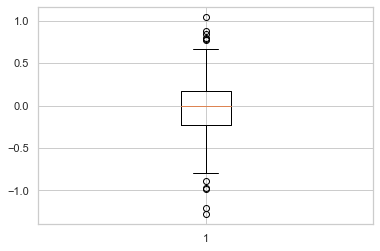

In [550]:
plt.boxplot(MonM_main['Inflation'])

In [551]:
plt.subplots(figsize=(15,10))
matrix = np.triu(MonM_main.corr())
sns.heatmap(MonM_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Month on Month Comparison')

Text(0.5, 1.0, 'Month on Month Comparison')

In [552]:
MonM_main = MonM_main.sort_values(by="Date", ascending=True)
MonM_main_csv = pd.DataFrame(MonM_main)

MonM_main_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/MonM_main.xlsx')
print('Finished')

Finished


# 1.3.3 Quarterly Changes | Variables ( past ) & Inflation ( forwards )<a id='2.5_Load_The_Ski_Resort_Data'></a>

In 1.3.3 I will be setting up the infrastructure to **compare quarterly changes on all variables ( one quarter in the past )** against a **quarterly change in inflation ( one quarter in the future )** to ascertain if there's any relationship to **predict** `Inflation` one quarter in advance.  

In [553]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi_past = cpi.diff(periods=-3)
M_unrate = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

Checking to see if the `Inflation` function works as I intend 

In [554]:
# To compare what the function is returning
Q_cpi_past.tail(5)

Value
Date             
2020-09-30  0.009
2020-10-31 -0.218
2020-11-30    NaN
2020-12-31    NaN
2021-01-31    NaN

In [555]:
# I start with the actual data
cpi.tail(10)

Value
Date             
2020-04-30  0.329
2020-05-31  0.118
2020-06-30  0.646
2020-07-31  0.986
2020-08-31  1.310
2020-09-30  1.371
2020-10-31  1.182
2020-11-30  1.175
2020-12-31  1.362
2021-01-31  1.400

In [556]:
print('The 31 Jan 2021 # of 1.4 minus 3 months before ( 2020-10-31 ) show: ', round((1.400-1.182),3) )

The 31 Jan 2021 # of 1.4 minus 3 months before ( 2020-10-31 ) show:  0.218


This **appears to be incorrect,** meaning it should be a positive number but shows a negative number in the `Q_cpi_p` tail. **Let's check the one behind to see what that shows.**

In [557]:
print('The 31 Dec 2020 # of 1.362 minus 3 months before ( 30 Sept 2020 ) show: ', round((1.362-1.371),3) )

The 31 Dec 2020 # of 1.362 minus 3 months before ( 30 Sept 2020 ) show:  -0.009


This shows a negative number while the function shows a positive. It appears as though the function need to be multiplied by -1 to show the correct #. 

**We will change the** `Q_cpi_p` **# below.**

In [558]:
Q_cpi_past = cpi.diff(periods=-3) * -1

Double check:

In [559]:
Q_cpi_past.tail(5)

Value
Date             
2020-09-30 -0.009
2020-10-31  0.218
2020-11-30    NaN
2020-12-31    NaN
2021-01-31    NaN

We have "righted the wrong"; ready to proceed.

In [564]:
# Putting them together with inflation
QonQ_main_cpi_past = Q_cpi_past.merge(QonQ_vars, how='left', on='Date')

# QonQ_main_cpi_past= QonQ_main_cpi_past[QonQ_main_cpi_past.index.dayofweek < 5]

QonQ_main_cpi_past.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate']

QonQ_main_cpi_past = QonQ_main_cpi_past.dropna()

ValueError: Length mismatch: Expected axis has 20 elements, new values have 19 elements

In [561]:
QonQ_main_cpi_past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 917 entries, 1914-03-31 to 2020-12-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Value                   915 non-null    float64
 1   Wage CPI                259 non-null    float64
 2   WTI                     259 non-null    float64
 3   Heating Oil             259 non-null    float64
 4   Copper                  259 non-null    float64
 5   Sugar                   259 non-null    float64
 6   Natural Gas             259 non-null    float64
 7   Cattle                  259 non-null    float64
 8   Lean Hogs               259 non-null    float64
 9   Soybeans                259 non-null    float64
 10  Lumber                  259 non-null    float64
 11  Capacity Utilization    259 non-null    float64
 12  Corn                    259 non-null    float64
 13  GDP                     259 non-null    float64
 14  M2 Velocity            

# 1.3.3.2 Cleaning the Variable ( past ) & Inflation ( forwards ) Dataframe for outliers 

Here's where are will see if this Dataframe needs cleaning for outliers.

In [562]:
QonQ_main_cpi_past.corr(method='pearson')

Value  Wage CPI       WTI  Heating Oil    Copper  \
Value                   1.000000 -0.005418  0.189752     0.221146  0.267744   
Wage CPI               -0.005418  1.000000  0.410007     0.501180  0.326784   
WTI                     0.189752  0.410007  1.000000     0.801081  0.427700   
Heating Oil             0.221146  0.501180  0.801081     1.000000  0.417235   
Copper                  0.267744  0.326784  0.427700     0.417235  1.000000   
Sugar                   0.200457  0.188646  0.180981     0.168726  0.255090   
Natural Gas             0.103356  0.306310  0.250464     0.412958  0.087862   
Cattle                 -0.038801  0.201202  0.155744     0.151078  0.120683   
Lean Hogs              -0.009406  0.114211  0.125411     0.087197  0.146652   
Soybeans                0.205365  0.134259  0.151827     0.169757  0.207905   
Lumber                  0.061134  0.099173  0.279960     0.137156  0.207631   
Capacity Utilization    0.175472  0.240888  0.423042     0.369393  0.247462   
Corn                    0.170258  0.068514  0.034765     0.049336  0.107980   
GDP                     0.029351  0.285221  0.292195     0.249528  0.153798   
M2 Velocity             0.038759  0.305211  0.180316     0.234727  0.139113   
Wheat                   0.099514 -0.003795 -0.013760     0.000361  0.082159   
PMI                     0.119090  0.229624  0.394224     0.328132  0.463860   
USD Index              -0.233913 -0.295176 -0.270599    -0.309808 -0.351754   
Initial Jobless Claims -0.070336 -0.086933 -0.429905    -0.275829 -0.171519   
Unemployment Rate      -0.000968 -0.229621 -0.259232    -0.250005 -0.092123   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Value                   0.200457     0.103356 -0.038801  -0.009406  0.205365   
Wage CPI                0.188646     0.306310  0.201202   0.114211  0.134259   
WTI                     0.180981     0.250464  0.155744   0.125411  0.151827   
Heating Oil             0.168726     0.412958  0.151078   0.087197  0.169757   
Copper                  0.255090     0.087862  0.120683   0.146652  0.207905   
Sugar                   1.000000     0.150063  0.028733  -0.086056  0.136992   
Natural Gas             0.150063     1.000000  0.015283   0.024183  0.058428   
Cattle                  0.028733     0.015283  1.000000   0.176569  0.088762   
Lean Hogs              -0.086056     0.024183  0.176569   1.000000  0.206747   
Soybeans                0.136992     0.058428  0.088762   0.206747  1.000000   
Lumber                  0.087038    -0.068966  0.195019   0.166738  0.197829   
Capacity Utilization    0.183948     0.128484  0.315213   0.154603  0.141625   
Corn                    0.078851     0.075419  0.031467   0.235256  0.707152   
GDP                     0.128054     0.101976  0.248577   0.159692  0.054263   
M2 Velocity             0.107573     0.086343  0.206946   0.121656  0.039691   
Wheat                   0.086394     0.011773  0.012129   0.033494  0.434461   
PMI                     0.151020     0.034109  0.185397   0.103924  0.146439   
USD Index              -0.140455    -0.240528 -0.049553   0.039408 -0.143919   
Initial Jobless Claims -0.128357    -0.051962 -0.175781  -0.048307 -0.051853   
Unemployment Rate      -0.119909    -0.064724 -0.285768  -0.127586 -0.066285   

                          Lumber  Capacity Utilization      Corn       GDP  \
Value                   0.061134              0.175472  0.170258  0.029351   
Wage CPI                0.099173              0.240888  0.068514  0.285221   
WTI                     0.279960              0.423042  0.034765  0.292195   
Heating Oil             0.137156              0.369393  0.049336  0.249528   
Copper                  0.207631              0.247462  0.107980  0.153798   
Sugar                   0.087038              0.183948  0.078851  0.128054   
Natural Gas            -0.068966              0.128484  0.075419  0.101976   
Cattle                  0.195019              0.315213  0.0314

KeyError: 'Inflation'

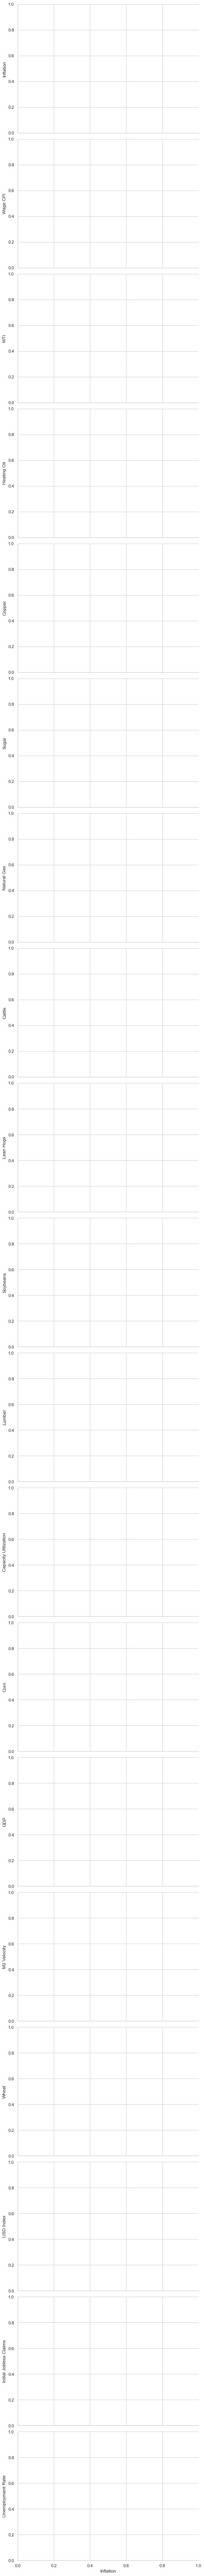

In [563]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Let's check this out on a histogram

In [ ]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

Noticeable outliers; let's check where they are.

In [71]:
cpi_outliers = np.abs(stats.zscore(QonQ_main_cpi_past['Inflation']))
threshold = 3
print(np.where(cpi_outliers >= threshold ))

(array([135, 154, 155, 161, 162], dtype=int64),)


In [72]:
QonQ_main_cpi_past['Inflation'][135],QonQ_main_cpi_past['Inflation'][154],QonQ_main_cpi_past['Inflation'][155],QonQ_main_cpi_past['Inflation'][161],QonQ_main_cpi_past['Inflation'][162]

(-2.84, -4.846, -3.625, 3.322, 4.007)

We will scrape all 5 representing 1.9% of the dataframe.

In [73]:
rows_to_drop = [135, 154, 155, 161, 162]
QonQ_main_cpi_past.drop(QonQ_main_cpi_past.index[rows_to_drop], inplace=True)

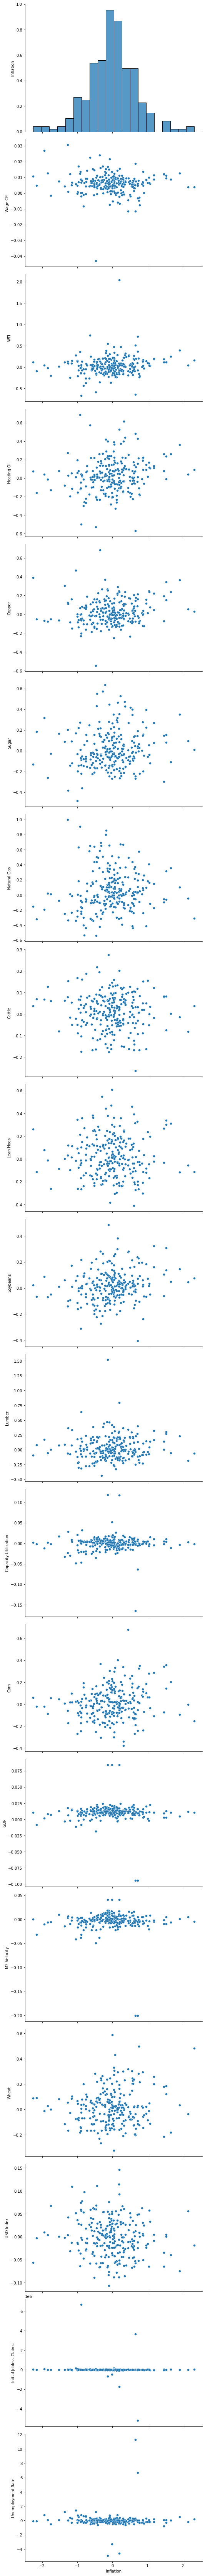

In [74]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                     'USD Index','Initial Jobless Claims','Unemployment Rate'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

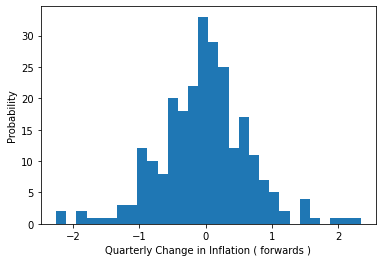

In [75]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

In [76]:
QonQ_main_cpi_past.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000 -0.078634  0.154610     0.168301  0.139950   
Wage CPI                -0.078634  1.000000  0.399018     0.495099  0.296250   
WTI                      0.154610  0.399018  1.000000     0.796247  0.407136   
Heating Oil              0.168301  0.495099  0.796247     1.000000  0.383781   
Copper                   0.139950  0.296250  0.407136     0.383781  1.000000   
Sugar                    0.122741  0.179084  0.180784     0.157158  0.221154   
Natural Gas              0.068452  0.308531  0.238366     0.408357  0.066704   
Cattle                  -0.075472  0.197439  0.149801     0.143297  0.108936   
Lean Hogs               -0.013594  0.105837  0.112004     0.071400  0.141064   
Soybeans                 0.187425  0.116767  0.113435     0.116465  0.164511   
Lumber                   0.035202  0.095657  0.267413     0.110479  0.200157   
Capacity Utilization     0.022051  0.224966  0.403495     0.332186  0.175942   
Corn                     0.157333  0.055594 -0.002697    -0.000310  0.068020   
GDP                     -0.009180  0.273046  0.276329     0.230199  0.129557   
M2 Velocity             -0.017775  0.288748  0.164447     0.221477  0.111080   
Wheat                    0.110158 -0.023628 -0.045651    -0.034473  0.057426   
USD Index               -0.135708 -0.265558 -0.235362    -0.267900 -0.291131   
Initial Jobless Claims  -0.082589 -0.087883 -0.435137    -0.280823 -0.177276   
Unemployment Rate        0.016576 -0.230665 -0.253526    -0.237434 -0.076262   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.122741     0.068452 -0.075472  -0.013594  0.187425   
Wage CPI                0.179084     0.308531  0.197439   0.105837  0.116767   
WTI                     0.180784     0.238366  0.149801   0.112004  0.113435   
Heating Oil             0.157158     0.408357  0.143297   0.071400  0.116465   
Copper                  0.221154     0.066704  0.108936   0.141064  0.164511   
Sugar                   1.000000     0.164145  0.022880  -0.069481  0.159126   
Natural Gas             0.164145     1.000000  0.008398   0.006618  0.030398   
Cattle                  0.022880     0.008398  1.000000   0.173389  0.078306   
Lean Hogs              -0.069481     0.006618  0.173389   1.000000  0.179663   
Soybeans                0.159126     0.030398  0.078306   0.179663  1.000000   
Lumber                  0.094701    -0.080189  0.199147   0.165611  0.167324   
Capacity Utilization    0.155247     0.101389  0.313514   0.148673  0.080986   
Corn                    0.098111     0.044849  0.018470   0.208909  0.684344   
GDP                     0.136612     0.089011  0.245356   0.141906  0.015305   
M2 Velocity             0.105278     0.075982  0.204871   0.111525  0.021213   
Wheat                   0.122457    -0.018723  0.002366  -0.002761  0.403428   
USD Index              -0.124536    -0.219046 -0.034546   0.070782 -0.084141   
Initial Jobless Claims -0.131203    -0.051088 -0.175017  -0.047675 -0.051011   
Unemployment Rate      -0.119322    -0.059003 -0.281952  -0.116596 -0.032578   

                          Lumber  Capacity Utilization      Corn       GDP  \
Inflation               0.035202              0.022051  0.157333 -0.009180   
Wage CPI                0.095657              0.224966  0.055594  0.273046   
WTI                     0.267413              0.403495 -0.002697  0.276329   
Heating Oil             0.110479              0.332186 -0.000310  0.230199   
Copper                  0.200157              0.175942  0.068020  0.129557   
Sugar                   0.094701              0.155247  0.098111  0.136612   
Natural Gas            -0.080189              0.101389  0.044849  0.089011   
Cattle                  0.199147              0.313514  0.018470  0.245356   
Lean Hogs               0.165611              0.148673  0.208909  0.141906   
Soybeans                0.167324          

Looks fairly similar to a normal distribution; I will continue as such.

{'whiskers': [<matplotlib.lines.Line2D at 0x1c8fd491280>,
 'caps': [<matplotlib.lines.Line2D at 0x1c8fd491940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c8fd471ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c8fd49d040>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c8fd49d3a0>],
 'means': []}

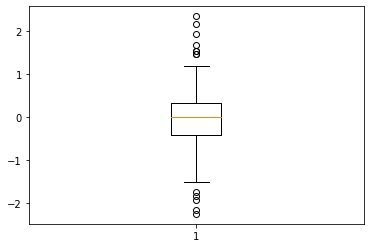

In [77]:
plt.boxplot(QonQ_main_cpi_past['Inflation'])

Text(0.5, 1.0, 'Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

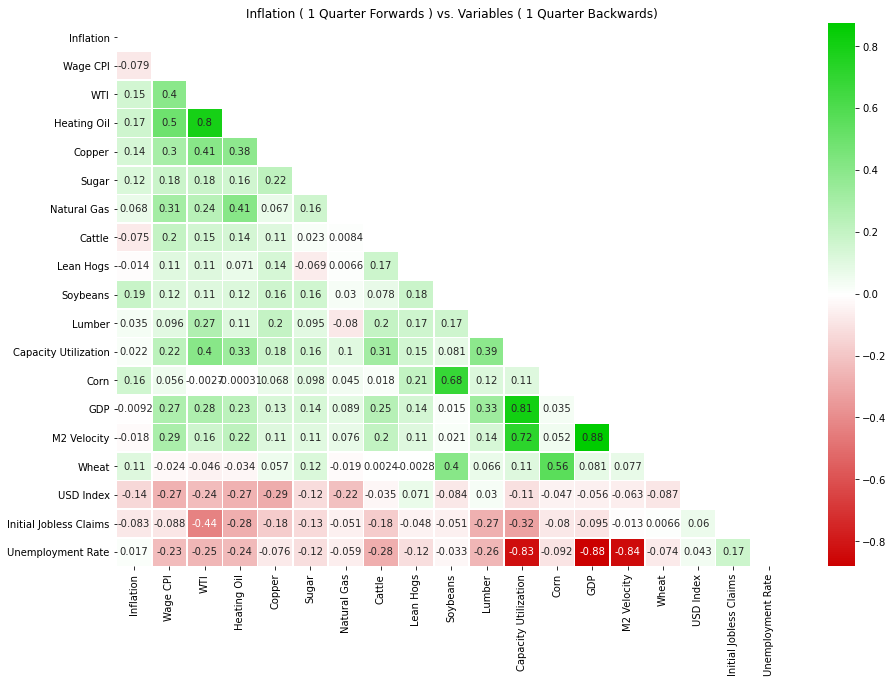

In [78]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_cpi_past.corr())
sns.heatmap(QonQ_main_cpi_past.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

In [79]:
QonQ_main_cpi_past = QonQ_main_cpi_past.sort_values(by="Date", ascending=True)
QonQ_main_cpi_past_csv = pd.DataFrame(QonQ_main_cpi_past)

QonQ_main_cpi_past_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main_cpi_past.xlsx')
print('Finished')

Finished


# 1.3.4   |   Q on Q Comparison w/ Rolling Averages on Daily, Wkly & Mnthly Variables ( w/ Inflation Scraping & no variable scraping )

**This dataframe is being constructed a similar way 1.3.1 was created with the exception that the daily, weekly & monthly variables are taking a rolling average.** The rational with this interest is based on the idea that one of the variables would have had a bad day / week at the end of the term. If so, they may not properly display the impact they may have on inflation.

In [565]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_roll = Q_usd_index.rolling(66).mean()
Q_wti_roll = Q_wti.rolling(66).mean()

Q_copper_roll = Q_copper.rolling(66).mean()
Q_soybeans_roll = Q_soybeans.rolling(66).mean()
Q_natgas_roll = Q_natgas.rolling(66).mean()
Q_heatoil_roll = Q_heatoil.rolling(66).mean()
Q_corn_roll = Q_corn.rolling(66).mean()
Q_wheat_roll = Q_wheat.rolling(66).mean()
Q_cattle_roll = Q_cattle.rolling(66).mean()
Q_sugar_roll = Q_sugar.rolling(66).mean()
Q_lumber_roll = Q_lumber.rolling(66).mean()
Q_leanhogs_roll = Q_leanhogs.rolling(66).mean()

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll = Q_intjobs.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll = Q_caputil.rolling(3).mean()
Q_wages_roll = Q_wages.rolling(3).mean()
Q_unrate_roll = Q_unrate.rolling(3).mean()
Q_comppmi_roll =Q_comppmi.rolling(3).mean()

Q_cpi = cpi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

In [566]:
# Building out the variables first with a roll & forward fill
QonQ_vars_roll = pd.concat([Q_wages_roll,Q_wti_roll,Q_copper_roll,Q_soybeans_roll,Q_natgas_roll,
                       Q_heatoil_roll,Q_corn_roll,Q_wheat_roll,Q_cattle_roll,Q_leanhogs_roll,Q_sugar_roll,
                       Q_lumber_roll,Q_caputil_roll,Q_gdp,Q_m2_velo,Q_comppmi_roll,
                            Q_usd_index_roll,Q_intjobs_roll,Q_unrate_roll
                      ],
                      axis = 1, ignore_index=False)

QonQ_vars_roll.columns= ['Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','GDP','M2 Velocity','PMI','USD Index','Initial Jobless Claims',
                         'Unemployment Rate'
                   ]

QonQ_vars_roll.index.names = ["Date"]
QonQ_vars_roll = QonQ_vars_roll.fillna(method='ffill')

# vars_mnth.tail()

In [567]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14119 entries, 1946-01-01 to 2021-03-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wages CPI               14110 non-null  float64
 1   WTI                     11905 non-null  float64
 2   Copper                  10257 non-null  float64
 3   Soybeans                9816 non-null   float64
 4   Natural Gas             9732 non-null   float64
 5   Heating Oil             12904 non-null  float64
 6   Corn                    12903 non-null  float64
 7   Wheat                   9818 non-null   float64
 8   Cattle                  12901 non-null  float64
 9   Lean Hogs               12906 non-null  float64
 10  Sugar                   12904 non-null  float64
 11  Lumber                  12906 non-null  float64
 12  Capacity Utilization    13850 non-null  float64
 13  GDP                     14112 non-null  float64
 14  M2 Velocity          

In [568]:
# As before, working backwards off of Natural Gas to bring the data together
# QonQ_vars_roll['Natural Gas'].tail(9565)

QonQ_vars_roll = QonQ_vars_roll.loc['1991-04-18':today_y_m_d_dash]

In [569]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9569 entries, 1991-04-18 to 2021-03-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wages CPI               9569 non-null   float64
 1   WTI                     9569 non-null   float64
 2   Copper                  9569 non-null   float64
 3   Soybeans                9569 non-null   float64
 4   Natural Gas             9569 non-null   float64
 5   Heating Oil             9569 non-null   float64
 6   Corn                    9569 non-null   float64
 7   Wheat                   9569 non-null   float64
 8   Cattle                  9569 non-null   float64
 9   Lean Hogs               9569 non-null   float64
 10  Sugar                   9569 non-null   float64
 11  Lumber                  9569 non-null   float64
 12  Capacity Utilization    9569 non-null   float64
 13  GDP                     9569 non-null   float64
 14  M2 Velocity           

In [570]:
# Putting them together with inflation
QonQ_main_roll = Q_cpi.merge(QonQ_vars_roll, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll.columns = ['Inflation','Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','GDP','M2 Velocity','PMI','USD Index','Initial Jobless Claims',
                         'Unemployment Rate']

QonQ_main_roll = QonQ_main_roll.dropna()

In [571]:
QonQ_main_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 1991-04-30 to 2021-01-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               315 non-null    float64
 1   Wages CPI               315 non-null    float64
 2   WTI                     315 non-null    float64
 3   Copper                  315 non-null    float64
 4   Soybeans                315 non-null    float64
 5   Natural Gas             315 non-null    float64
 6   Heating Oil             315 non-null    float64
 7   Corn                    315 non-null    float64
 8   Wheat                   315 non-null    float64
 9   Cattle                  315 non-null    float64
 10  Lean Hogs               315 non-null    float64
 11  Sugar                   315 non-null    float64
 12  Lumber                  315 non-null    float64
 13  Capacity Utilization    315 non-null    float64
 14  GDP                    

# 1.3.4.2 Cleaning the Dataframe for outliers 

In [572]:
QonQ_main_roll.corr(method='pearson')

Inflation  Wages CPI       WTI    Copper  Soybeans  \
Inflation                1.000000   0.565987  0.520343  0.350230  0.174340   
Wages CPI                0.565987   1.000000  0.712886  0.510164  0.241096   
WTI                      0.520343   0.712886  1.000000  0.560650  0.258679   
Copper                   0.350230   0.510164  0.560650  1.000000  0.252599   
Soybeans                 0.174340   0.241096  0.258679  0.252599  1.000000   
Natural Gas              0.306085   0.404527  0.349431  0.173464  0.101293   
Heating Oil              0.525608   0.732853  0.902690  0.537572  0.224292   
Corn                     0.244616   0.212270  0.116587  0.141006  0.719497   
Wheat                    0.120482   0.141778  0.040497  0.151463  0.458404   
Cattle                   0.146786   0.246435  0.162890  0.119943  0.069074   
Lean Hogs                0.212232   0.240171  0.289866  0.186921  0.215068   
Sugar                    0.219102   0.230867  0.215882  0.295286  0.139238   
Lumber                   0.174071   0.192688  0.310672  0.222888  0.197200   
Capacity Utilization     0.342820   0.385995  0.478661  0.336307  0.163464   
GDP                      0.306428   0.299760  0.459980  0.243993  0.064373   
M2 Velocity              0.293430   0.339728  0.431914  0.270083  0.066910   
PMI                      0.219310   0.330704  0.479544  0.463356  0.165237   
USD Index               -0.315753  -0.394085 -0.406236 -0.411457 -0.268120   
Initial Jobless Claims  -0.257800  -0.204241 -0.432977 -0.190292 -0.100176   
Unemployment Rate       -0.209100  -0.301459 -0.324661 -0.152743 -0.118077   

                        Natural Gas  Heating Oil      Corn     Wheat  \
Inflation                  0.306085     0.525608  0.244616  0.120482   
Wages CPI                  0.404527     0.732853  0.212270  0.141778   
WTI                        0.349431     0.902690  0.116587  0.040497   
Copper                     0.173464     0.537572  0.141006  0.151463   
Soybeans                   0.101293     0.224292  0.719497  0.458404   
Natural Gas                1.000000     0.476638  0.111541  0.035351   
Heating Oil                0.476638     1.000000  0.103521  0.058695   
Corn                       0.111541     0.103521  1.000000  0.577482   
Wheat                      0.035351     0.058695  0.577482  1.000000   
Cattle                     0.142327     0.218795  0.057550  0.055742   
Lean Hogs                  0.085929     0.160532  0.204855 -0.099823   
Sugar                      0.234720     0.256509  0.088798  0.084430   
Lumber                    -0.066601     0.182754  0.119822  0.039197   
Capacity Utilization       0.264894     0.468512  0.189856  0.165687   
GDP                        0.141105     0.377974  0.078871  0.049156   
M2 Velocity                0.142203     0.400120  0.087582  0.073883   
PMI                        0.053856     0.377968  0.017551  0.044015   
USD Index                 -0.238806    -0.399799 -0.184178 -0.203491   
Initial Jobless Claims    -0.125982    -0.330734 -0.101659 -0.035294   
Unemployment Rate         -0.163239    -0.322216 -0.152027 -0.105712   

                          Cattle  Lean Hogs     Sugar    Lumber  \
Inflation               0.146786   0.212232  0.219102  0.174071   
Wages CPI               0.246435   0.240171  0.230867  0.192688   
WTI                     0.162890   0.289866  0.215882  0.310672   
Copper                  0.119943   0.186921  0.295286  0.222888   
Soybeans                0.069074   0.215068  0.139238  0.197200   
Natural Gas             0.142327   0.085929  0.234720 -0.066601   
Heating Oil             0.218795   0.160532  0.256509  0.182754   
Corn                    0.057550   0.204855  0.088798  0.119822   
Wheat                   0.055742  -0.099823  0.084430  0.039197   
Cattle                  1.000000   0.122089  0.093854  0.244684   
Lean Hogs               0.122089   1.000000 -0.127026  0.246006   
Sugar                   0.093854  -0.127026  1.000000  0.031725   
L

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

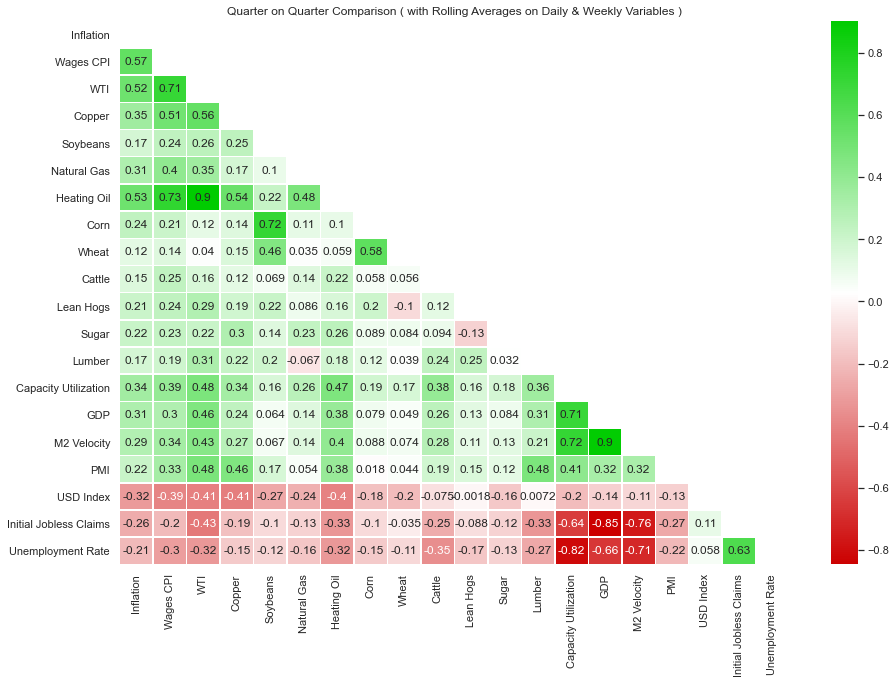

In [573]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

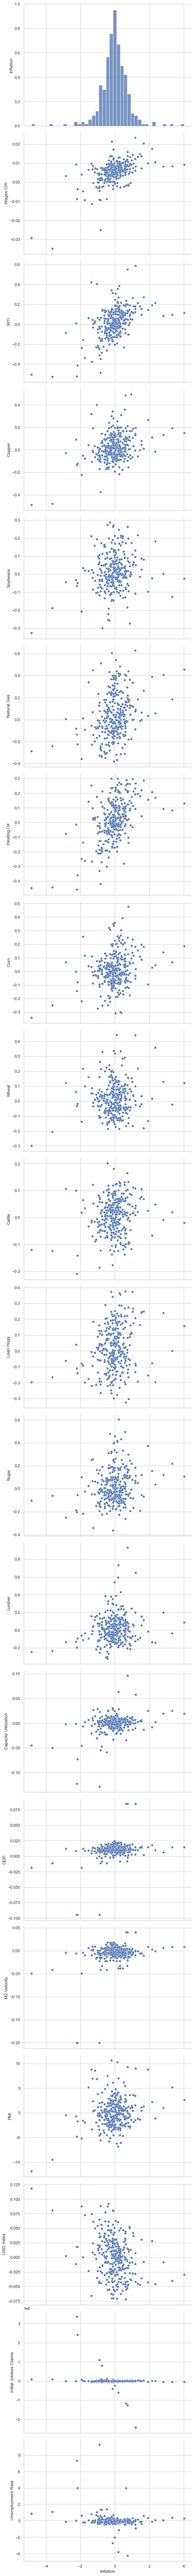

In [575]:
sns.pairplot(QonQ_main_roll,
            y_vars=['Inflation','Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','GDP','M2 Velocity','PMI','USD Index','Initial Jobless Claims',
                         'Unemployment Rate'],
            x_vars=['Inflation'],
            height=5, aspect=1.5,)

Text(0, 0.5, 'Probability')

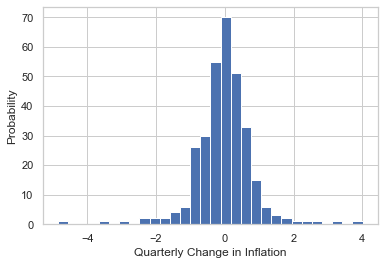

In [576]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

Given the Inflation data hasn't been changed since 1.31; we will scrape anything ± 300 bps

In [577]:
cpi_review = np.abs(stats.zscore(QonQ_main_roll['Inflation']))
threshold = 3
print( np.where( cpi_review > threshold ) )

(array([156, 178, 179, 188, 189, 190], dtype=int64),)


In [578]:
QonQ_main_roll['Inflation'][156],QonQ_main_roll['Inflation'][178],QonQ_main_roll['Inflation'][179],QonQ_main_roll['Inflation'][188],QonQ_main_roll['Inflation'][189],QonQ_main_roll['Inflation'][190]

(-2.84, -4.846, -3.625, 3.322, 4.007, 2.8089999999999997)

Dropping those outside ±300 bps

In [579]:
droppingrows = [ 178, 179, 188, 189 ]
QonQ_main_roll.drop(QonQ_main_roll.index[droppingrows], inplace=True)

Text(0, 0.5, 'Probability')

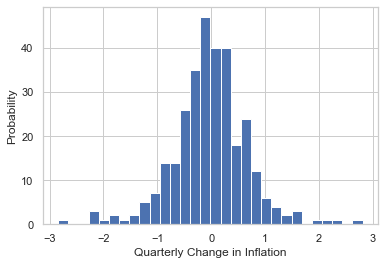

In [580]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

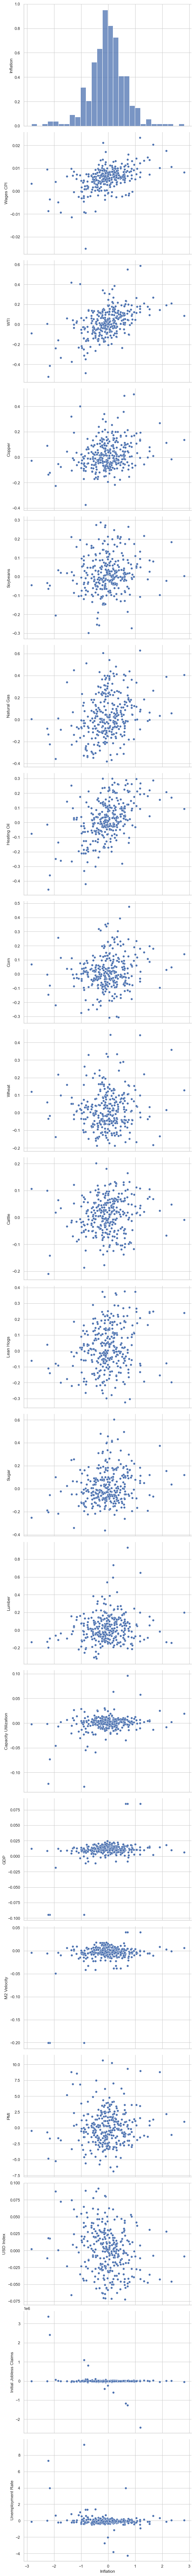

In [582]:
sns.pairplot(QonQ_main_roll,
            y_vars = ['Inflation','Wages CPI','WTI','Copper','Soybeans','Natural Gas',
                    'Heating Oil','Corn','Wheat','Cattle','Lean Hogs','Sugar',
                    'Lumber','Capacity Utilization','GDP','M2 Velocity','PMI','USD Index','Initial Jobless Claims',
                         'Unemployment Rate'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

In [583]:
QonQ_main_roll.corr(method='pearson')

Inflation  Wages CPI       WTI    Copper  Soybeans  \
Inflation                1.000000   0.477351  0.483253  0.226182  0.130479   
Wages CPI                0.477351   1.000000  0.688178  0.414485  0.160065   
WTI                      0.483253   0.688178  1.000000  0.512829  0.214378   
Copper                   0.226182   0.414485  0.512829  1.000000  0.204979   
Soybeans                 0.130479   0.160065  0.214378  0.204979  1.000000   
Natural Gas              0.258576   0.400880  0.328236  0.132107  0.083765   
Heating Oil              0.491668   0.718875  0.894309  0.489967  0.179611   
Corn                     0.162078   0.125836  0.058836  0.071836  0.715396   
Wheat                    0.034545   0.047689 -0.018285  0.091095  0.434954   
Cattle                   0.106733   0.198130  0.126026  0.074167  0.037329   
Lean Hogs                0.182445   0.212949  0.269399  0.157112  0.197865   
Sugar                    0.202604   0.235034  0.206650  0.288226  0.138238   
Lumber                   0.142065   0.144871  0.286702  0.191662  0.172811   
Capacity Utilization     0.271498   0.326555  0.444111  0.279498  0.132835   
GDP                      0.287451   0.265002  0.440793  0.207823  0.033867   
M2 Velocity              0.261703   0.311168  0.410242  0.233584  0.038854   
PMI                      0.080785   0.219011  0.431159  0.398996  0.117989   
USD Index               -0.235765  -0.330877 -0.363566 -0.359201 -0.235890   
Initial Jobless Claims  -0.291309  -0.225727 -0.445597 -0.194121 -0.099544   
Unemployment Rate       -0.221271  -0.302518 -0.315694 -0.135417 -0.100432   

                        Natural Gas  Heating Oil      Corn     Wheat  \
Inflation                  0.258576     0.491668  0.162078  0.034545   
Wages CPI                  0.400880     0.718875  0.125836  0.047689   
WTI                        0.328236     0.894309  0.058836 -0.018285   
Copper                     0.132107     0.489967  0.071836  0.091095   
Soybeans                   0.083765     0.179611  0.715396  0.434954   
Natural Gas                1.000000     0.462003  0.079074  0.005748   
Heating Oil                0.462003     1.000000  0.046687  0.003237   
Corn                       0.079074     0.046687  1.000000  0.558537   
Wheat                      0.005748     0.003237  0.558537  1.000000   
Cattle                     0.129570     0.187088  0.029067  0.027964   
Lean Hogs                  0.067185     0.133557  0.183285 -0.129343   
Sugar                      0.225224     0.248909  0.074884  0.074988   
Lumber                    -0.086979     0.152794  0.094307  0.011229   
Capacity Utilization       0.238601     0.434329  0.147739  0.128911   
GDP                        0.124011     0.354621  0.048686  0.019755   
M2 Velocity                0.122373     0.376936  0.056083  0.045026   
PMI                        0.009180     0.322198 -0.052062 -0.015557   
USD Index                 -0.211707    -0.358021 -0.138541 -0.164325   
Initial Jobless Claims    -0.123663    -0.337570 -0.098738 -0.031452   
Unemployment Rate         -0.159103    -0.313412 -0.140693 -0.091698   

                          Cattle  Lean Hogs     Sugar    Lumber  \
Inflation               0.106733   0.182445  0.202604  0.142065   
Wages CPI               0.198130   0.212949  0.235034  0.144871   
WTI                     0.126026   0.269399  0.206650  0.286702   
Copper                  0.074167   0.157112  0.288226  0.191662   
Soybeans                0.037329   0.197865  0.138238  0.172811   
Natural Gas             0.129570   0.067185  0.225224 -0.086979   
Heating Oil             0.187088   0.133557  0.248909  0.152794   
Corn                    0.029067   0.183285  0.074884  0.094307   
Wheat                   0.027964  -0.129343  0.074988  0.011229   
Cattle                  1.000000   0.108283  0.086925  0.229580   
Lean Hogs               0.108283   1.000000 -0.136576  0.233433   
Sugar                   0.086925  -0.136576  1.000000  0.025590   
L

{'whiskers': [<matplotlib.lines.Line2D at 0x1c8b266bfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c8b268b6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c8b266bc70>],
 'medians': [<matplotlib.lines.Line2D at 0x1c8b268bdc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c8b34f8160>],
 'means': []}

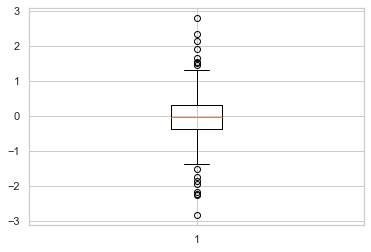

In [584]:
plt.boxplot(QonQ_main_roll['Inflation'])

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

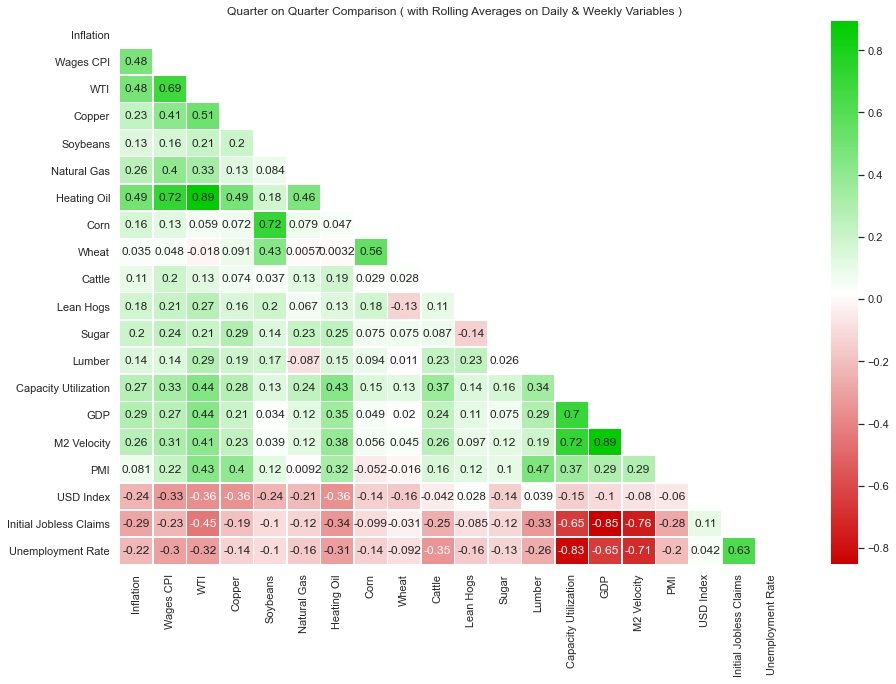

In [585]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

In [99]:
QonQ_main_roll = QonQ_main_roll.sort_values(by="Date", ascending=False)
QonQ_main_roll_csv = pd.DataFrame(QonQ_main_roll)

QonQ_main_roll_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main_roll.xlsx')
print('Finished')

Finished


# 1.4 Summary

# 1.4.1 Looking into Natural Gas

**Natural Gas was one of the variables which confined the length / depth of the dataframe.** Here we will ascertain whether or not we could remove it for the following possible reasons:
   * It's influence on Inflation is accounted for with other fossil fuels 
   * It's influence by itself is notable

In [586]:
# Creating "new quarterly variables"

Q_wti_2 = Q_wti 
Q_heatoil_2 = Q_heatoil
Q_natgas_2 = Q_natgas
Q_cpi_2 = Q_cpi

In [587]:
fos_fuel_main = pd.concat([Q_wti_2,Q_heatoil_2,Q_natgas_2],
                         axis=1,ignore_index=False)

fos_fuel_main.columns = ['WTI','Heating Oil','Natural Gas']
fos_fuel_main.index.names = ["Date"]
fos_fuel_main = fos_fuel_main.fillna(method='ffill')

fos_fuel = Q_cpi_2.merge(fos_fuel_main,
                        how='left',on="Date")

fos_fuel.columns =['Inflation','WTI','Heating Oil','Natural Gas']

fos_fuel = fos_fuel.dropna()

Comparing the fossil fuels together to inflation.

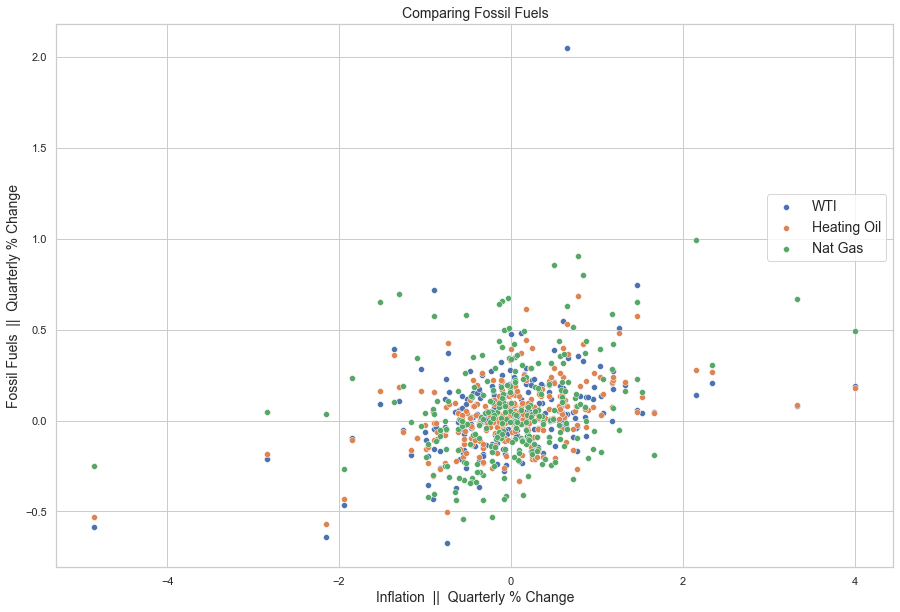

In [588]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['WTI'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Heating Oil'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Natural Gas'])
sns.set(style='whitegrid',)
plt.ylabel('Fossil Fuels  ||  Quarterly % Change', fontsize=14)
plt.xlabel('Inflation  ||  Quarterly % Change', fontsize=14)
plt.legend(['WTI','Heating Oil','Nat Gas'], scatterpoints=1,bbox_to_anchor=(1, 0.7),fontsize=14)
plt.title('Comparing Fossil Fuels', fontsize=14)
plt.show()

There appears to be one (1) outlier in WTI ( which was seen before ) which we will remove for further review.

In [589]:
wti_check = np.abs(stats.zscore(fos_fuel['WTI']))
threshold = 3
print(np.where( wti_check > threshold) )

(array([  2, 248, 249, 250, 251], dtype=int64),)


In [590]:
fos_fuel['WTI'][2],fos_fuel['WTI'][248],fos_fuel['WTI'][249],fos_fuel['WTI'][250],fos_fuel['WTI'][251]

(0.743196437407224,
 -0.6712463199214916,
 -0.6386522809010032,
 0.7178602243313201,
 2.046721929163527)

In [591]:
wtidrop_row = [251]
fos_fuel.drop(fos_fuel.index[wtidrop_row], inplace=True)

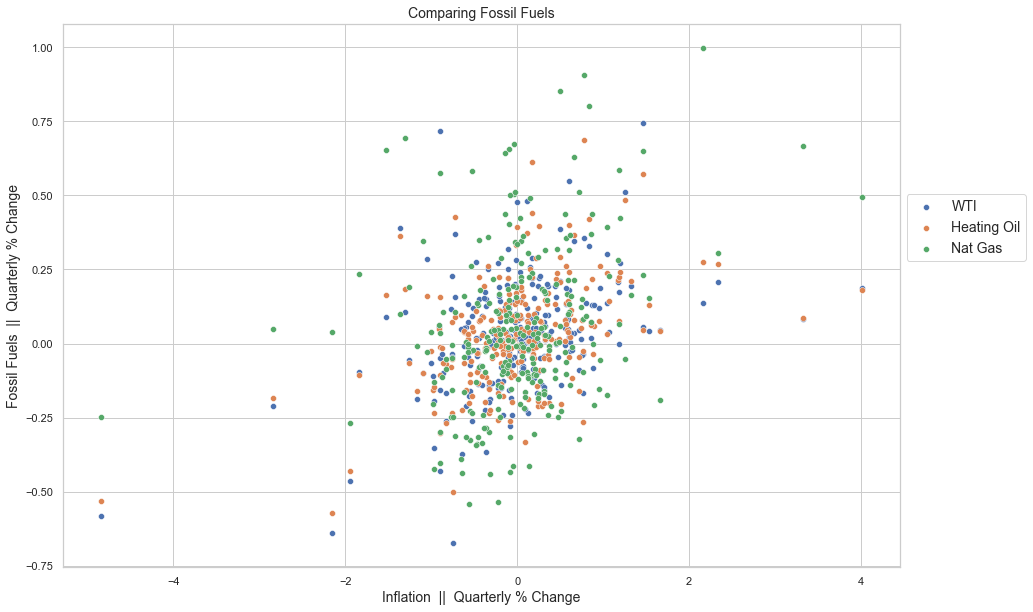

In [592]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['WTI'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Heating Oil'])
sns.scatterplot(x=fos_fuel['Inflation'],y=fos_fuel['Natural Gas'])
sns.set(style='whitegrid',)
plt.ylabel('Fossil Fuels  ||  Quarterly % Change', fontsize=14)
plt.xlabel('Inflation  ||  Quarterly % Change', fontsize=14)
plt.legend(['WTI','Heating Oil','Nat Gas'], scatterpoints=1,bbox_to_anchor=(1, 0.7),fontsize=14)
plt.title('Comparing Fossil Fuels', fontsize=14)
plt.show()

Visually these appear quite correlated or in other words possibly accounted for with WTI & Heating Oil.

Text(0.5, 1.0, 'Fossil Fuels Heatmap)')

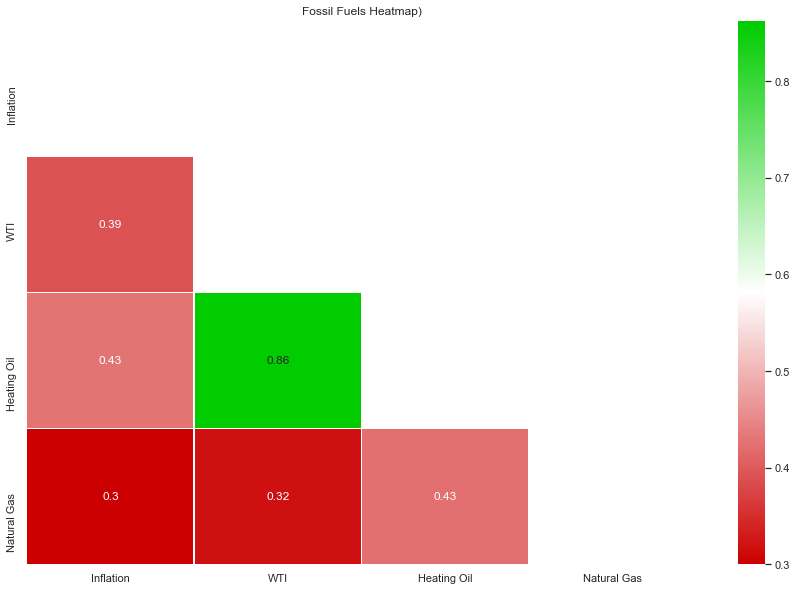

In [593]:
plt.subplots(figsize=(15,10))
matrix = np.triu(fos_fuel.corr())
sns.heatmap(fos_fuel.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Fossil Fuels Heatmap)')

It does not appear to be as correlated as WTI & Heating Oil are to each other.

# 1.4.2 Taking a look at other possible variables which limit size / depth

We unfortunately need to reassign the data to a new variables as they already been cut by Natural Gas's limitations

In [594]:
# Daily Data
two_usd_index = quandl.get('CHRIS/ICE_DX1')
two_wti = quandl.get('CHRIS/CME_CL1')
two_copper = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_soybeans = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_natgas = investpy.get_commodity_historical_data(commodity='Natural Gas', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_heatoil = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_corn = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_wheat = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_cattle = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_sugar = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_lumber = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
two_leanhogs = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
two_int_job_claims = quandl.get('FRED/ICSA')    # Hasn't been factored in yet

# Monthly Data
two_cpi = quandl.get('RATEINF/INFLATION_USA')
two_wages_cpi = fred.get_series('CWSR0000SA0')
two_cap_util = fred.get_series('TCU')
two_unrate = quandl.get('FRED/UNRATE')          # Hasn't been factored in yet


# Quarterly Data
two_m2_velo = fred.get_series('M2V')
two_gdp = fred.get_series('GDP')


We will push them together again.

In [595]:
new_df = pd.concat([two_cpi,two_wages_cpi,two_wti['Last'],two_heatoil['Close'],two_copper['Close'],two_sugar['Close'],
                    two_natgas['Close'],two_cattle['Close'],two_leanhogs['Close'],two_soybeans['Close'],two_lumber['Close'],
                     two_cap_util,two_corn['Close'],two_gdp,two_m2_velo,two_wheat['Close'],two_usd_index['Settle'],
                    two_unrate,two_int_job_claims],
                    axis = 1, ignore_index=False)

new_df = new_df.fillna(method='ffill')
new_df.columns = ['Inflation','Wages CPI','WTI','Heating Oil','Copper','Sugar','Natural Gas','Cattle',
                   'Lean Hogs','Soybeans','Lumber','Capacity Utilization','Corn','GDP','M2 Velocity','Wheat',
                   'USD Index','Unemployment Rate','Initial Jobless Claims']
new_df['Inflation'].index
new_df.index.names = ["Date"]

new_df = new_df[new_df.index.dayofweek < 5]

new_df = new_df.sort_values(by="Date", ascending=False)

# I will sometimes take a look to ensure it is working properly
# main_df.tail()
# main_df.head()


In [596]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11451 entries, 2021-03-02 to 1914-03-31
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               11451 non-null  float64
 1   Wages CPI               11165 non-null  float64
 2   WTI                     9773 non-null   float64
 3   Heating Oil             10600 non-null  float64
 4   Copper                  8416 non-null   float64
 5   Sugar                   10600 non-null  float64
 6   Natural Gas             7983 non-null   float64
 7   Cattle                  10595 non-null  float64
 8   Lean Hogs               10600 non-null  float64
 9   Soybeans                8049 non-null   float64
 10  Lumber                  10600 non-null  float64
 11  Capacity Utilization    10821 non-null  float64
 12  Corn                    10600 non-null  float64
 13  GDP                     11165 non-null  float64
 14  M2 Velocity          

As per above the the "other variables" which may be consider to be discontinued to increase the size of the database would be:
   * Copper
   * Soybeans
   * Wheat

As per below, I ( in Excel ) pulled together the findings from this notebook for comparative purposes. To better explain, please find below the explaination of the column headers:
   * QoQ     ||  1.3.1 Q on Q Comparison
   * Mom     ||  1.3.2 Monthly Changes
   * QfoQ    ||  1.3.3 Quarterly Change | Variables ( past ) & Inflation ( forwards )
   * QoQ(av) ||  1.3.4 Q on Q Comparison w/ Rolling Averages on Daily, Wkly & Mnthly Variables
   * MAX  || The highest of the above
   * MIN  || The lowest of the above
   * RANK  || The ranking therein of the positively correlated & negatively correlated

As per below, Copper, Soybeans & Wheat's correlations to inflation are in the middle of the rankings ( Copper & Wheat ) & at the end ( Wheat ). Further consideration may be required. 

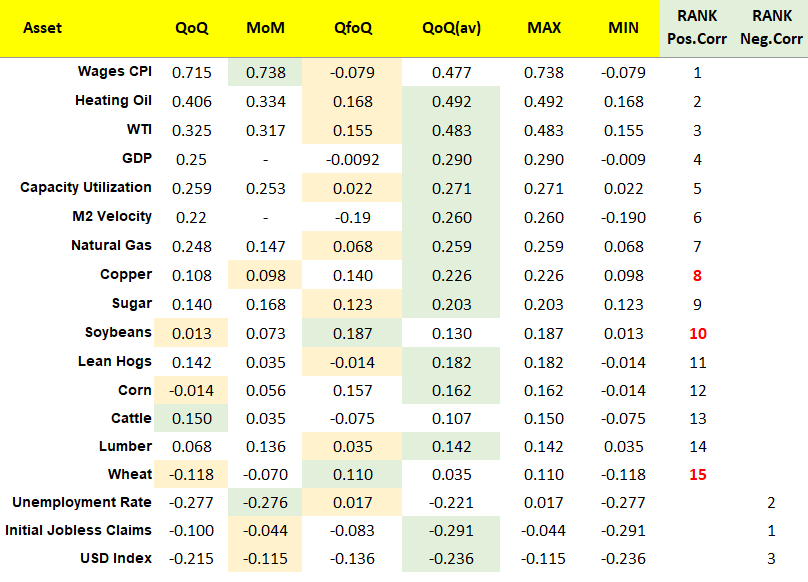

There is some variation between what works best but incorporating a rolling average on the variables played out well with the exception of the below:
   * Wages CPI
   * Soybeans
   * Cattle
   * Wheat
   * Unemployment Rate

Two of the above are also under consideration for removal

# 1.4.3 Scraping the Variables as well ( individually )

**All of the previous review was based on only scraping** `Inflation`. In this section, we will remove `Natural Gas` but keep `Soybeans`, `Wheat` & `Copper`.

We will scrape remaining variables.

We will use the Quarter on Quarter with rolling averages approach ( 1.3.4 ) & **we will scrape individually; meaning, we will return to the original data ( i.e. the beginning ) & scrape from those before we concatenate them together.** We will concatenate those 'cleaned' dataframes & apply the forward fill approach.

We will reassign them to a new variable based on the same structure.

In [597]:
Q_usd_index_2 = usd_index['Settle'].pct_change(periods=66)
Q_wti_2 = wti['Last'].pct_change(periods=66)

Q_copper_2 = copper['Close'].pct_change(periods=66)
Q_soybeans_2 = soybeans['Close'].pct_change(periods=66)
Q_heatoil_2 = heatoil['Close'].pct_change(periods=66)
Q_corn_2 = corn['Close'].pct_change(periods=66)
Q_wheat_2 = wheat['Close'].pct_change(periods=66)
Q_cattle_2 = cattle['Close'].pct_change(periods=66)
Q_sugar_2 = sugar['Close'].pct_change(periods=66)
Q_lumber_2 = lumber['Close'].pct_change(periods=66)
Q_leanhogs_2 = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_2 = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_2 = cap_util.pct_change(periods=3)
Q_wages_2 = wages_cpi.pct_change(periods=3)
Q_cpi_2 = cpi.diff(periods=3)
Q_unrate_2 = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp_2 = gdp.pct_change(periods=1)
Q_m2_velo_2 = m2_velo.pct_change(periods=1)


In [598]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_roll_2 = Q_usd_index_2.rolling(66).mean()
Q_wti_roll_2 = Q_wti_2.rolling(66).mean()

Q_copper_roll_2 = Q_copper_2.rolling(66).mean()
Q_soybeans_roll_2 = Q_soybeans_2.rolling(66).mean()
Q_heatoil_roll_2 = Q_heatoil_2.rolling(66).mean()
Q_corn_roll_2 = Q_corn_2.rolling(66).mean()
Q_wheat_roll_2 = Q_wheat_2.rolling(66).mean()
Q_cattle_roll_2 = Q_cattle_2.rolling(66).mean()
Q_sugar_roll_2 = Q_sugar_2.rolling(66).mean()
Q_lumber_roll_2 = Q_lumber_2.rolling(66).mean()
Q_leanhogs_roll_2 = Q_leanhogs_2.rolling(66).mean()

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll_2 = Q_intjobs_2.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll_2 = Q_caputil_2.rolling(3).mean()
Q_wages_roll_2 = Q_wages_2.rolling(3).mean()
Q_unrate_roll_2 = Q_unrate_2.rolling(3).mean()

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp_2 = Q_gdp_2.pct_change(periods=1)
Q_m2_velo_2 = Q_m2_velo_2.pct_change(periods=1)

In [599]:
# we need to create seperate inflation variables to compare each variable independantly
Q_cpi_usd_index_roll = cpi.diff(periods=3)
Q_cpi_wti_roll_2 = cpi.diff(periods=3)

Q_cpi_copper_roll_2 = cpi.diff(periods=3)
Q_cpi_soybeans_roll_2 = cpi.diff(periods=3)
Q_cpi_heatoil_roll_2 = cpi.diff(periods=3)
Q_cpi_corn_roll_2 = cpi.diff(periods=3)
Q_cpi_wheat_roll_2 = cpi.diff(periods=3)
Q_cpi_cattle_roll_2 = cpi.diff(periods=3)
Q_cpi_sugar_roll_2 = cpi.diff(periods=3)
Q_cpi_lumber_roll_2 = cpi.diff(periods=3)
Q_cpi_leanhogs_roll_2 = cpi.diff(periods=3)

Q_cpi_intjobs_roll_2 = cpi.diff(periods=3)

Q_cpi_caputil_roll_2 = cpi.diff(periods=3)
Q_cpi_wages_roll_2 = cpi.diff(periods=3)
Q_cpi_unrate_roll_2 = cpi.diff(periods=3)

Q_cpi_gdp_2 = cpi.diff(periods=3)
Q_cpi_m2_velo_2 = cpi.diff(periods=3)


**Let's now look for outliers individually on each before we concatenate them together.**

Let's start with `WTI`.

In [600]:
# Putting WTI together with inflation
QonQ_main_roll_WTI = Q_cpi_wti_roll_2.merge(Q_wti_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_WTI.columns = ['Inflation',
                              'WTI']

QonQ_main_roll_WTI = QonQ_main_roll_WTI.dropna()

Text(0.5, 0, 'WTI Quarterly Change')

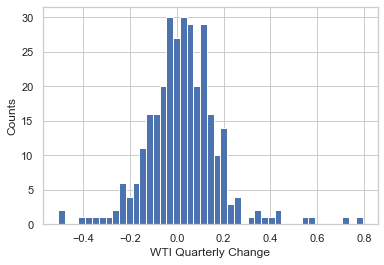

In [601]:
plt.hist(QonQ_main_roll_WTI['WTI'], density=False, bins=45)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('WTI Quarterly Change')

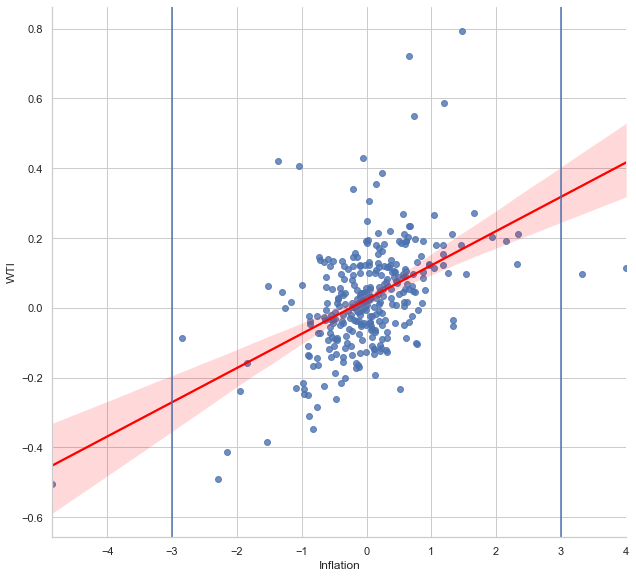

In [602]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="WTI",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_WTI, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')


As a reminder, as we go through this process, ±300 bps on `Inflation` will be removed ( the lines above ). 

In [603]:
wti_outliers = np.abs(stats.zscore(QonQ_main_roll_WTI['WTI']))
thresh = 3
print(np.where( wti_outliers >= thresh ))

(array([ 21,  58,  59, 209, 307, 308], dtype=int64),)


In [604]:
QonQ_main_roll_WTI['WTI'][21],QonQ_main_roll_WTI['WTI'][58],QonQ_main_roll_WTI['WTI'][59],QonQ_main_roll_WTI['WTI'][209],QonQ_main_roll_WTI['WTI'][307],QonQ_main_roll_WTI['WTI'][308]

(-0.4916561934217437,
 0.7937089275231227,
 0.7208014136969375,
 -0.5062255494981958,
 0.5864625150063545,
 0.5504017628029214)

We will proceed withe the assumption of ±60% can be our boundaries.

In [605]:
wti_drop = [ 58, 59 ]
QonQ_main_roll_WTI.drop(QonQ_main_roll_WTI.index[wti_drop], inplace=True)

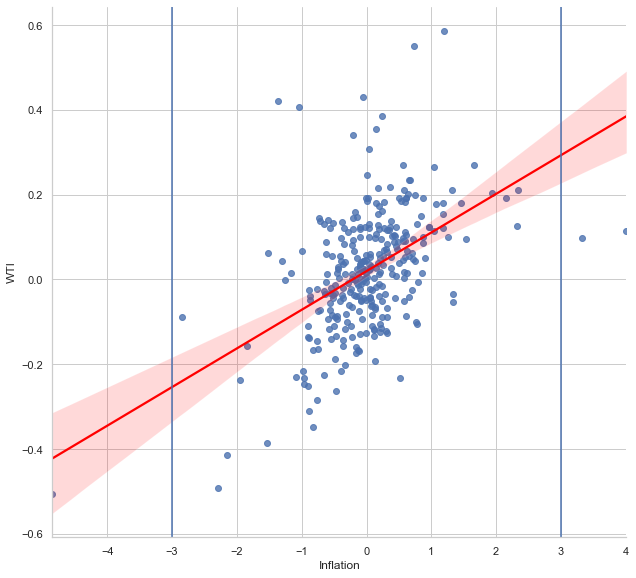

In [606]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="WTI",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_WTI, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')


Let's check out the histogram again.

Text(0.5, 0, 'WTI Quarterly Change')

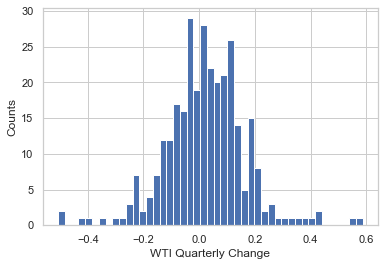

In [607]:
plt.hist(QonQ_main_roll_WTI['WTI'], density=False, bins=45)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('WTI Quarterly Change')

Let's work with it; next `Lumber`.

In [608]:

QonQ_main_roll_Lumber = Q_cpi_lumber_roll_2.merge(Q_lumber_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_Lumber.columns = ['Inflation',
                              'Lumber']

QonQ_main_roll_Lumber = QonQ_main_roll_Lumber.dropna()

Text(0.5, 0, 'Lumber Quarterly Change')

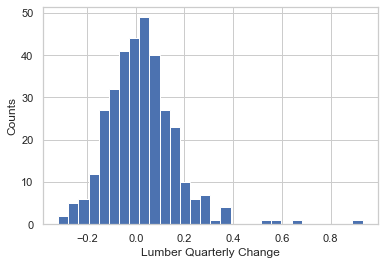

In [609]:
plt.hist(QonQ_main_roll_Lumber['Lumber'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Lumber Quarterly Change')

Outliers appear to be +0.4; let's confirm.

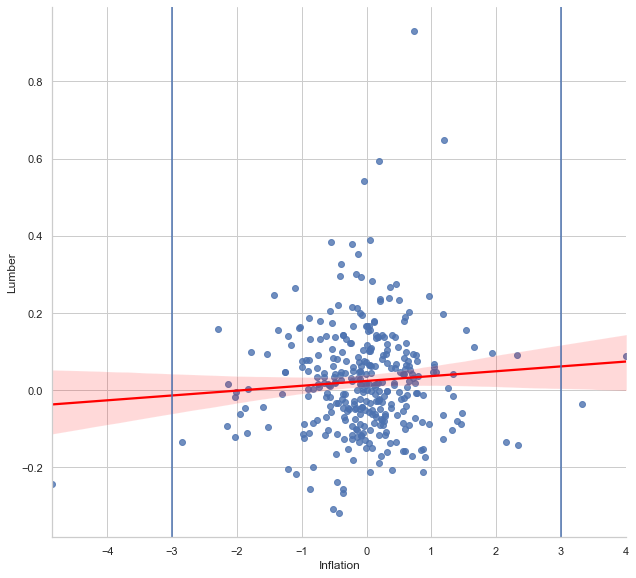

In [610]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Lumber",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_Lumber, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')


In [611]:
wood_outliers = np.abs(stats.zscore(QonQ_main_roll_Lumber['Lumber']))
thresh = 3
print(np.where( wood_outliers >= thresh ))

(array([105, 106, 336, 337], dtype=int64),)


In [612]:
QonQ_main_roll_Lumber['Lumber'][105],QonQ_main_roll_Lumber['Lumber'][106],QonQ_main_roll_Lumber['Lumber'][336],QonQ_main_roll_Lumber['Lumber'][337]

(0.5930780274077718,
 0.5426370098414417,
 0.6477095249025613,
 0.9311827220702612)

In [613]:
wood_drop = [105, 106, 336, 337]
QonQ_main_roll_Lumber.drop(QonQ_main_roll_Lumber.index[wood_drop], inplace=True)

Dropped. Lets see how it looks.

Text(0.5, 0, 'Lumber Quarterly Change')

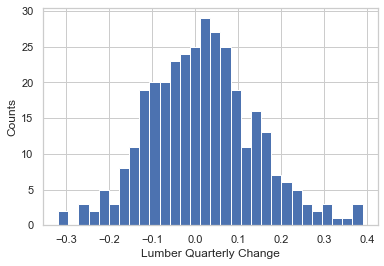

In [614]:
plt.hist(QonQ_main_roll_Lumber['Lumber'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Lumber Quarterly Change')

Looks normally distributed. Let's investigate a scatter.

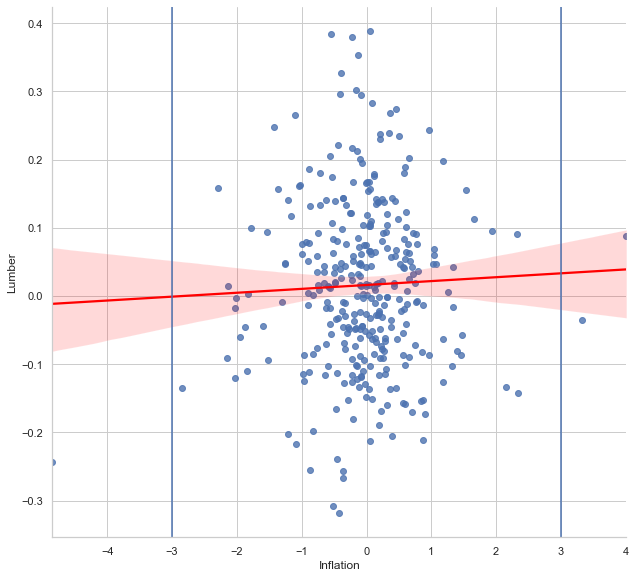

In [615]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Lumber",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_Lumber, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')


You may go further but I believe this may work so we will continue.

Next up, `Sugar`.

In [616]:
# Putting it together with inflation
QonQ_main_roll_sugar = Q_cpi_sugar_roll_2.merge(Q_sugar_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_sugar.columns = ['Inflation',
                              'Sugar']

QonQ_main_roll_sugar = QonQ_main_roll_sugar.dropna()

Text(0.5, 0, 'Sugar Quarterly Change')

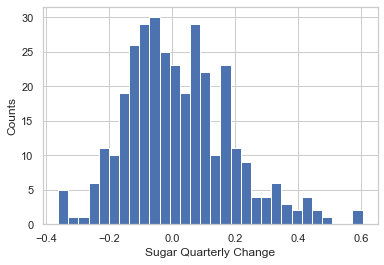

In [617]:
plt.hist(QonQ_main_roll_sugar['Sugar'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Sugar Quarterly Change')

There's some outliers but not as many. Let's see

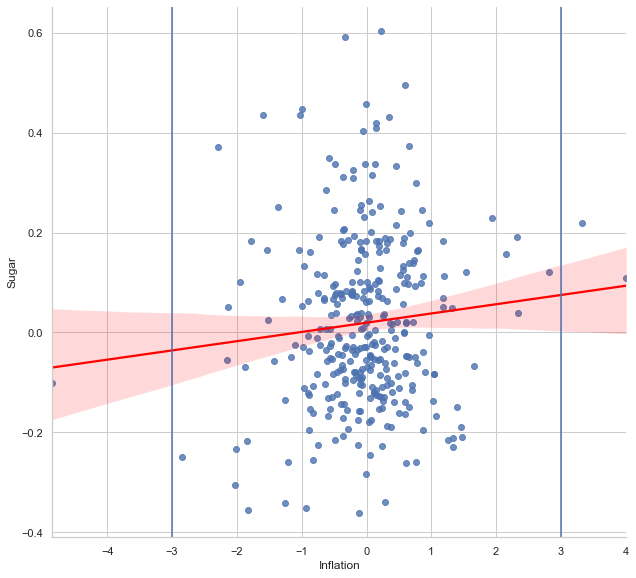

In [618]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Sugar",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_sugar, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')


Let's see what the zscore says.

In [619]:
sugar_outliers = np.abs(stats.zscore(QonQ_main_roll_sugar['Sugar']))
thresh = 3
print(np.where( sugar_outliers >= thresh ))

(array([ 41, 163], dtype=int64),)


Let me guess; at or near 0.6?

In [620]:
QonQ_main_roll_sugar['Sugar'][41],QonQ_main_roll_sugar['Sugar'][163]

(0.5912219460788073, 0.6041389971704523)

Makes sense; let's drop them.

In [621]:
sugar_high = [41, 163]
QonQ_main_roll_sugar.drop(QonQ_main_roll_sugar.index[sugar_high], inplace=True)

Text(0.5, 0, 'Sugar Quarterly Change')

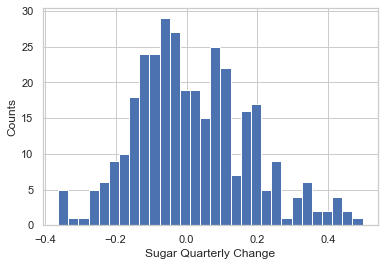

In [622]:
plt.hist(QonQ_main_roll_sugar['Sugar'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Sugar Quarterly Change')

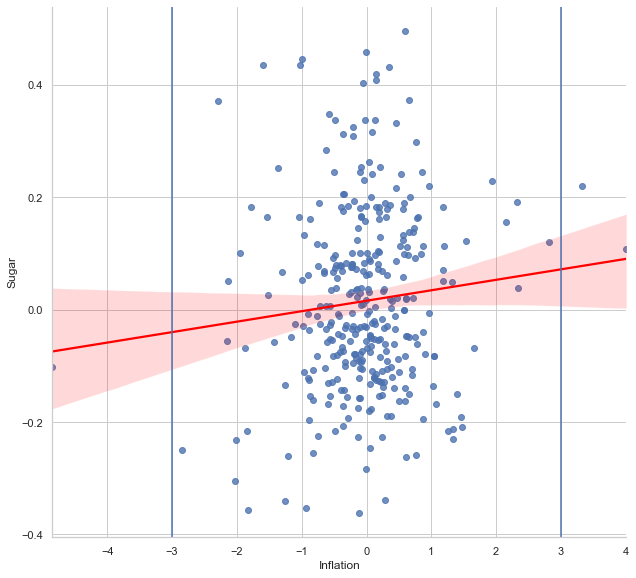

In [623]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Sugar",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_sugar, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Next up, `Wheat`.

In [624]:
# Putting it together with inflation
QonQ_main_roll_wheat = Q_cpi_wheat_roll_2.merge(Q_wheat_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_wheat.columns = ['Inflation',
                              'Wheat']

QonQ_main_roll_wheat = QonQ_main_roll_wheat.dropna()

Text(0.5, 0, 'Wheat Quarterly Change')

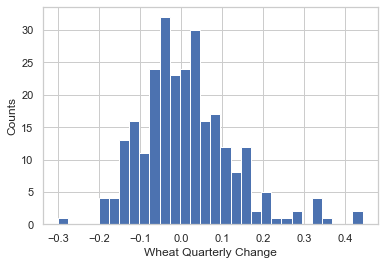

In [625]:
plt.hist(QonQ_main_roll_wheat['Wheat'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Wheat Quarterly Change')

Outliers look to be +40%; let's take a look at a scatter plot.

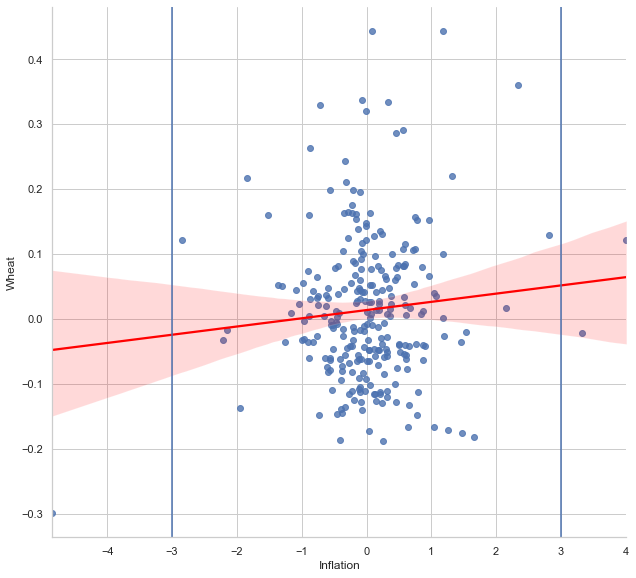

In [626]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Wheat",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_wheat, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [627]:
wheat_out = np.abs(stats.zscore(QonQ_main_roll_wheat['Wheat']))
thresh = 3
print(np.where(wheat_out >= thresh))

(array([141, 142, 167], dtype=int64),)


In [628]:
QonQ_main_roll_wheat['Wheat'][141],QonQ_main_roll_wheat['Wheat'][142],QonQ_main_roll_wheat['Wheat'][167]

(0.4426094099481728, 0.3599306322614149, 0.4434118078615357)

Let's keep it simple at the 40% threshold.

In [629]:
wheat_drop = [ 141, 167 ]
QonQ_main_roll_wheat.drop(QonQ_main_roll_wheat.index[wheat_drop], inplace=True)

Text(0.5, 0, 'Wheat Quarterly Change')

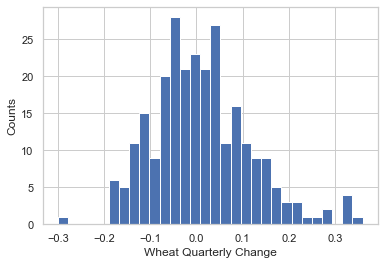

In [630]:
plt.hist(QonQ_main_roll_wheat['Wheat'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Wheat Quarterly Change')

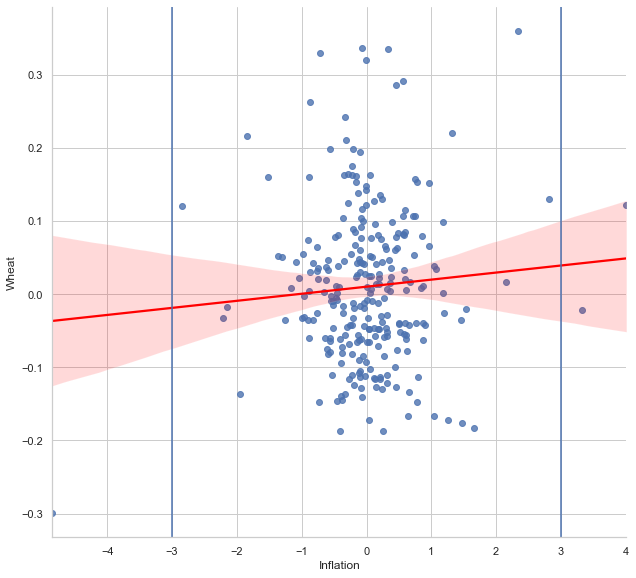

In [631]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Wheat",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_wheat, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

`Wheat` looks "ok" so let's move to the next one; `Copper`.

In [632]:
# Putting it together with inflation
QonQ_main_roll_copper = Q_cpi_copper_roll_2.merge(Q_copper_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_copper.columns = ['Inflation',
                              'Copper']

QonQ_main_roll_copper = QonQ_main_roll_copper.dropna()

Text(0.5, 0, 'Copper Quarterly Change')

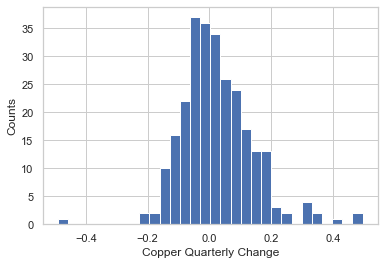

In [633]:
plt.hist(QonQ_main_roll_copper['Copper'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Copper Quarterly Change')

The noticeable outliers are ±40%; let's take a look on a scatter plot.

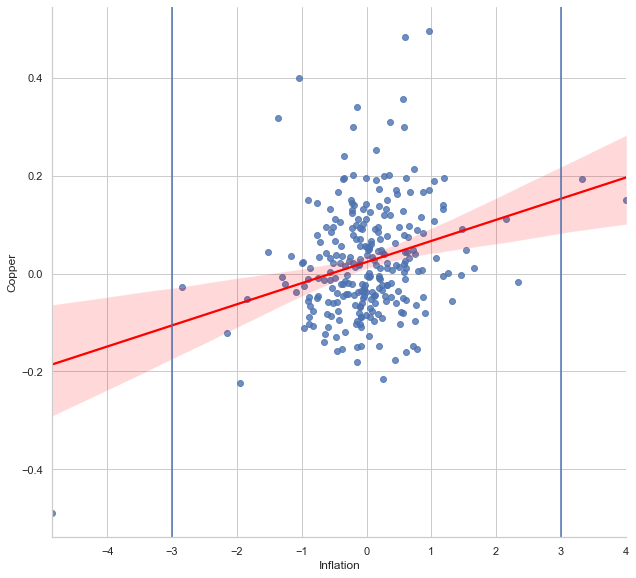

In [634]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Copper",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_copper, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

One of the outliers ( negative ) falls into the `Inflation` drop territory but we will still probably see it & drop it here.

In [635]:
cop_out = np.abs(stats.zscore(QonQ_main_roll_copper['Copper']))
cop_thresh = 3
print(np.where( cop_out >= cop_thresh ))

(array([143, 144, 165, 168], dtype=int64),)


In [636]:
QonQ_main_roll_copper['Copper'][143],QonQ_main_roll_copper['Copper'][144],QonQ_main_roll_copper['Copper'][165],QonQ_main_roll_copper['Copper'][168]

(0.4964666602693851,
 0.48450253345546795,
 -0.4901995166095401,
 0.3999030509117332)

In [637]:
cop_drop = [ 143, 144, 165 ]
QonQ_main_roll_copper.drop(QonQ_main_roll_copper.index[cop_drop], inplace=True)

Text(0.5, 0, 'Copper Quarterly Change')

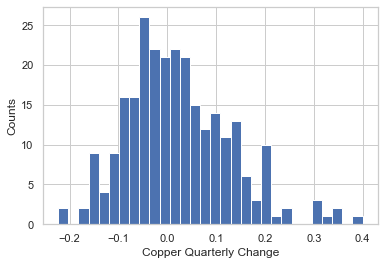

In [638]:
plt.hist(QonQ_main_roll_copper['Copper'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Copper Quarterly Change')

Good here.

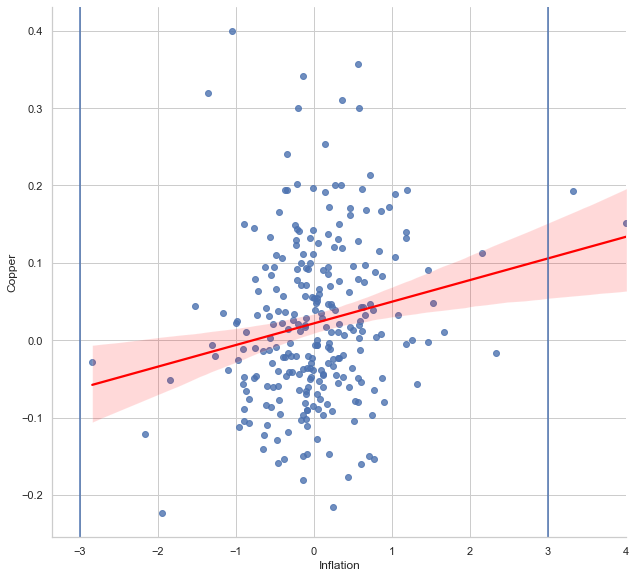

In [639]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Copper",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_copper, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Let's work with that. Next is `Corn`

In [640]:
# Putting it together with inflation
QonQ_main_roll_corn = Q_cpi_corn_roll_2.merge(Q_corn_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_corn.columns = ['Inflation',
                              'Corn']

QonQ_main_roll_corn = QonQ_main_roll_corn.dropna()

Text(0.5, 0, 'Corn Quarterly Change')

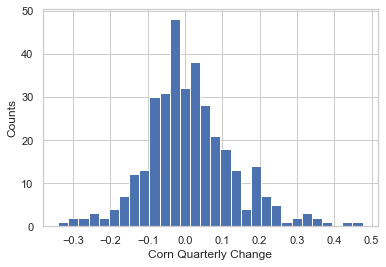

In [641]:
plt.hist(QonQ_main_roll_corn['Corn'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Corn Quarterly Change')

The histogram looks reasonably normal but with a slight lean. Let's see the scatter plot.

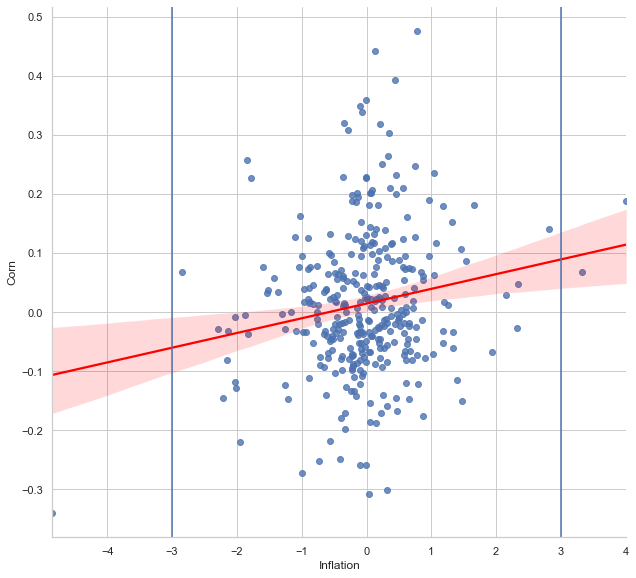

In [642]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Corn",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_corn, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Let's see the z score

In [643]:
corn_out = np.abs(stats.zscore(QonQ_main_roll_corn['Corn']))
corn_thresh = 3
print(np.where( corn_out >= corn_thresh ))

(array([ 65, 218, 219], dtype=int64),)


In [644]:
QonQ_main_roll_corn['Corn'][65],QonQ_main_roll_corn['Corn'][218],QonQ_main_roll_corn['Corn'][219]

(0.44161962704009616, 0.4758691606867668, 0.39327156574826805)

Let's work off a ±30% protocal & only eliminate 2 of the above.

In [645]:
corn_drop = [ 65, 218 ]
QonQ_main_roll_corn.drop(QonQ_main_roll_corn.index[ corn_drop ], inplace=True)

Text(0.5, 0, 'Corn Quarterly Change')

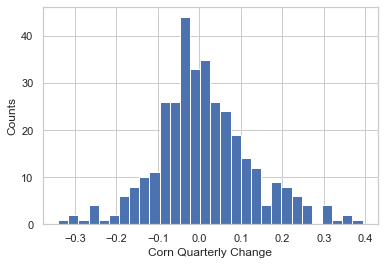

In [646]:
plt.hist(QonQ_main_roll_corn['Corn'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Corn Quarterly Change')

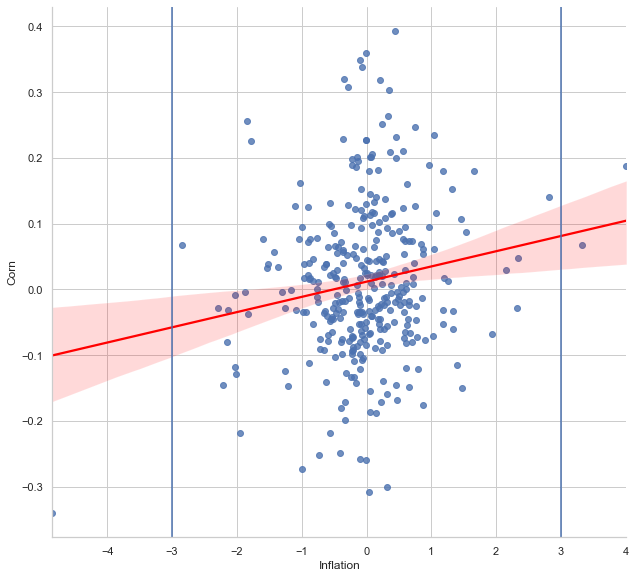

In [647]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Corn",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_corn, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Not perfect but let's move on to the next one; `Cattle`.

In [648]:
# Putting it together with inflation
QonQ_main_roll_cattle = Q_cpi_cattle_roll_2.merge(Q_cattle_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_cattle.columns = ['Inflation',
                              'Cattle']

QonQ_main_roll_cattle = QonQ_main_roll_cattle.dropna()

Text(0.5, 0, 'Cattle Quarterly Change')

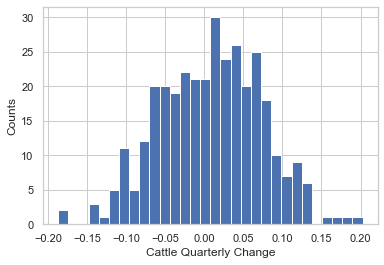

In [649]:
plt.hist(QonQ_main_roll_cattle['Cattle'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Cattle Quarterly Change')

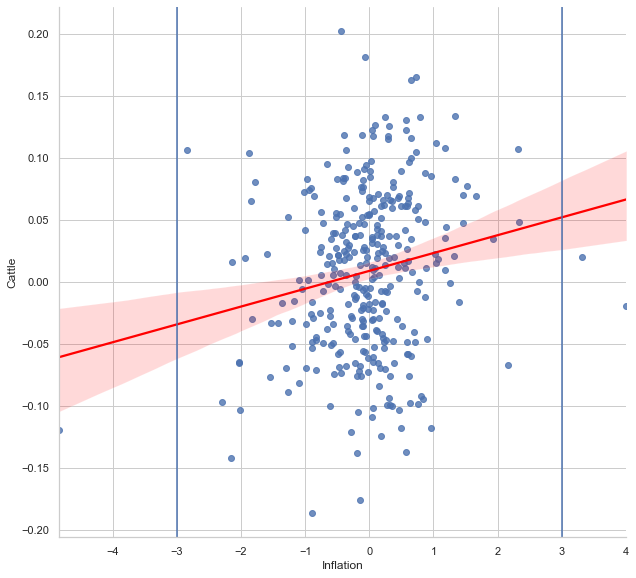

In [650]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Cattle",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_cattle, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [651]:
cat_out = np.abs(stats.zscore(QonQ_main_roll_cattle['Cattle']))
cat_thresh = 3
print(np.where( cat_out >= cat_thresh ))

(array([], dtype=int64),)


Next we will look at the `USD Index`.

In [652]:
# Putting it together with inflation
QonQ_main_roll_dixie = Q_cpi_usd_index_roll.merge(Q_usd_index_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_dixie.columns = ['Inflation',
                              'US Dollar Index']

QonQ_main_roll_dixie = QonQ_main_roll_dixie.dropna()

Text(0.5, 0, 'US Dollar Index Quarterly Change')

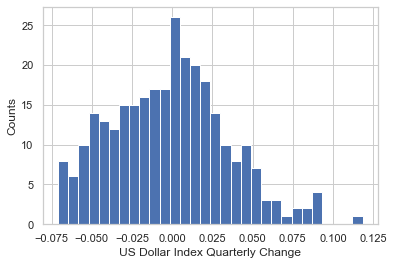

In [653]:
plt.hist(QonQ_main_roll_dixie['US Dollar Index'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('US Dollar Index Quarterly Change')

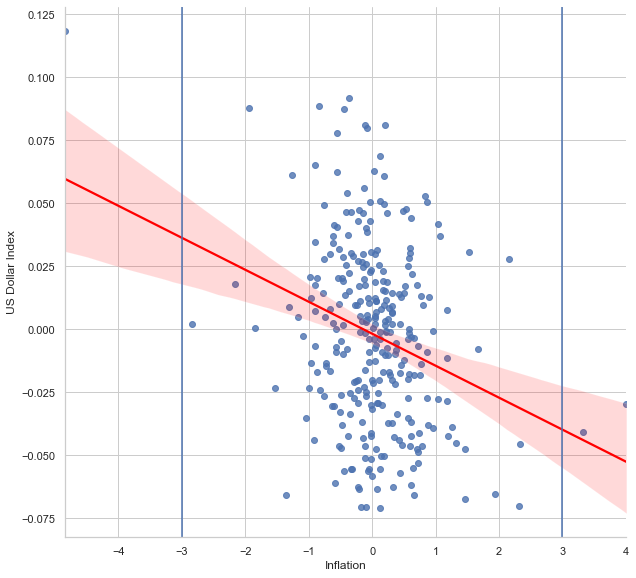

In [654]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="US Dollar Index",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_dixie, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [655]:
dixie_out = np.abs(stats.zscore(QonQ_main_roll_dixie['US Dollar Index']))
dixie_thresh = 3
print(np.where( dixie_out >= dixie_thresh ))

(array([190], dtype=int64),)


In [656]:
QonQ_main_roll_dixie['US Dollar Index'][190]

0.11842859058956058

That falls under the `Inflation` scrapping zone so we will keep it & move on.

Moving over to `Soybeans`.

In [657]:
# Putting it together with inflation
QonQ_main_roll_soybeans = Q_cpi_soybeans_roll_2.merge(Q_soybeans_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_soybeans.columns = ['Inflation',
                              'Soybeans']

QonQ_main_roll_soybeans = QonQ_main_roll_soybeans.dropna()

Text(0.5, 0, 'Soybeans Quarterly Change')

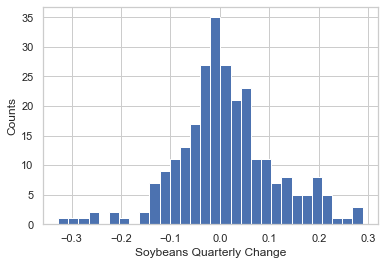

In [658]:
plt.hist(QonQ_main_roll_soybeans['Soybeans'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Soybeans Quarterly Change')

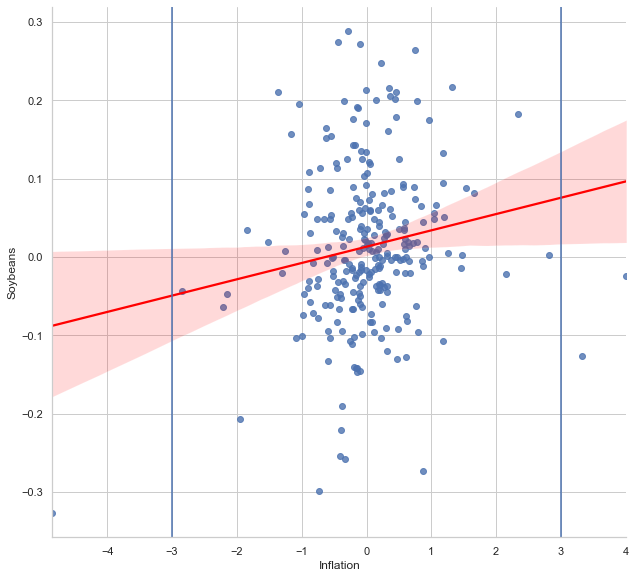

In [659]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Soybeans",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_soybeans, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [660]:
soy_out = np.abs(stats.zscore(QonQ_main_roll_soybeans['Soybeans']))
soy_thresh = 3
print(np.where( soy_out >= soy_thresh ))

(array([115, 152], dtype=int64),)


In [661]:
QonQ_main_roll_soybeans['Soybeans'][115],QonQ_main_roll_soybeans['Soybeans'][152]

(-0.2992754451037921, -0.3272563691460246)

Although I'm not happy with the results from `Soybeans`, one of the observations above ( -32% ) will be removed with `Inflation` scrapping while the other may push for an aggressive range. I will remove the one that will otherwise be removed with `Inflation` for now.

In [662]:
soy_to_drop = [ 152 ]
QonQ_main_roll_soybeans.drop(QonQ_main_roll_soybeans.index[soy_to_drop], inplace=True)

Text(0.5, 0, 'Soybeans Quarterly Change')

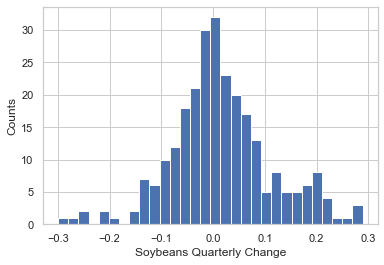

In [663]:
plt.hist(QonQ_main_roll_soybeans['Soybeans'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Soybeans Quarterly Change')

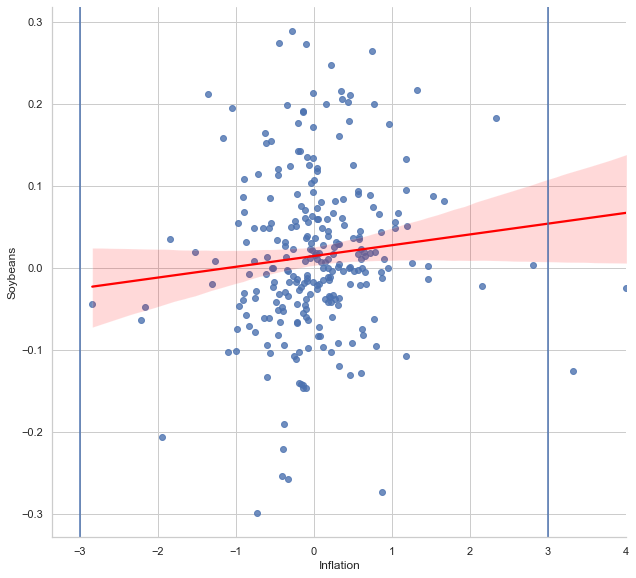

In [664]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Soybeans",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_soybeans, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Moving over to `Heating Oil`.

In [665]:
# Putting it together with inflation
QonQ_main_roll_heatoil = Q_cpi_heatoil_roll_2.merge(Q_heatoil_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_heatoil.columns = ['Inflation',
                              'Heating Oil']

QonQ_main_roll_heatoil = QonQ_main_roll_heatoil.dropna()

Text(0.5, 0, 'Heating Oil Quarterly Change')

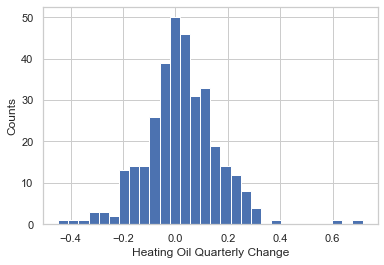

In [666]:
plt.hist(QonQ_main_roll_heatoil['Heating Oil'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Heating Oil Quarterly Change')

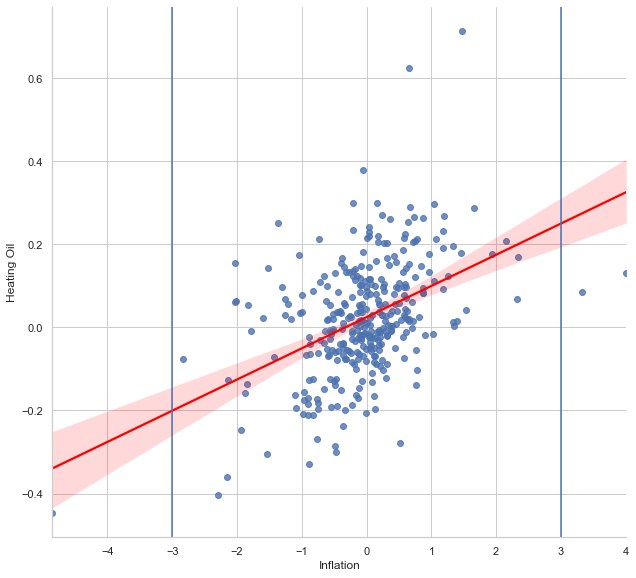

In [667]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Heating Oil",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_heatoil, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [668]:
heat_out = np.abs(stats.zscore(QonQ_main_roll_heatoil['Heating Oil']))
heat_thresh = 3
print(np.where( heat_out >= heat_thresh ))

(array([ 46,  83,  84, 234], dtype=int64),)


In [669]:
QonQ_main_roll_heatoil['Heating Oil'][46],QonQ_main_roll_heatoil['Heating Oil'][83],QonQ_main_roll_heatoil['Heating Oil'][84],QonQ_main_roll_heatoil['Heating Oil'][234]

(-0.40332337041169564,
 0.7145361267622342,
 0.6241707144189736,
 -0.4473949131373653)

One of the these falls into `Inflation` scrapping zone while the other are notable outliers so we will remove them.

In [670]:
heatoil_drop = [ 46,  83,  84, 234 ]
QonQ_main_roll_heatoil.drop(QonQ_main_roll_heatoil.index[heatoil_drop], inplace=True)

Text(0.5, 0, 'Heating Oil Quarterly Change')

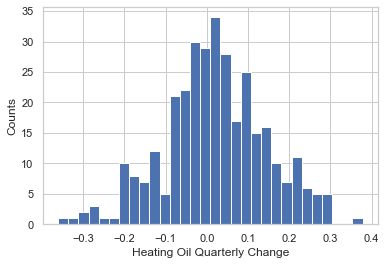

In [671]:
plt.hist(QonQ_main_roll_heatoil['Heating Oil'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Heating Oil Quarterly Change')

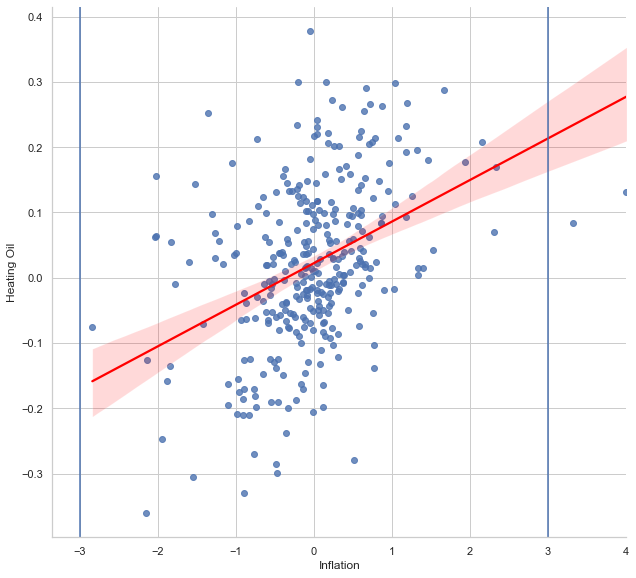

In [672]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Heating Oil",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_heatoil, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Some others may be deemed as outliers but we will work with these based on a ±40% protocal

Next is `Lean Hogs`.

In [673]:
# Putting it together with inflation
QonQ_main_roll_hogs = Q_cpi_leanhogs_roll_2.merge(Q_leanhogs_roll_2, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll_hogs.columns = ['Inflation',
                              'Lean Hogs']

QonQ_main_roll_hogs = QonQ_main_roll_hogs.dropna()

Text(0.5, 0, 'Lean Hogs Quarterly Change')

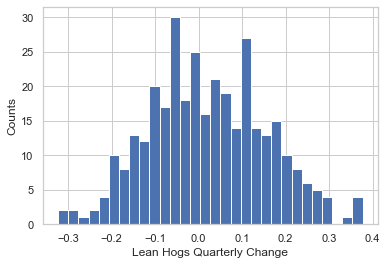

In [674]:
plt.hist(QonQ_main_roll_hogs['Lean Hogs'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Lean Hogs Quarterly Change')

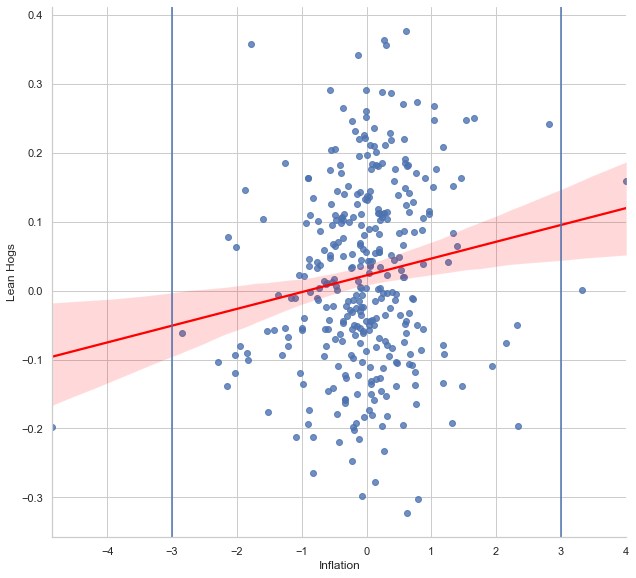

In [675]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Lean Hogs",
                 height=8, aspect=1.1,
                 data=QonQ_main_roll_hogs, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [676]:
hogs_out = np.abs(stats.zscore(QonQ_main_roll_hogs['Lean Hogs']))
hogs_thresh = 3
print(np.where( hogs_out >= hogs_thresh ))

(array([], dtype=int64),)


In [677]:
QonQ_main_roll_hogs['Lean Hogs'].min(),QonQ_main_roll_hogs['Lean Hogs'].max()

(-0.32285296003078745, 0.37670594668494467)

Although I'm not impressed with it's contribution as a whole we will keep `Lean Hogs` as is.

We will continue with no removals.

**The remaining variables require us to concat them together and then seperate them with inflation individually.**

In [678]:
# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_3 = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_3 = cap_util.pct_change(periods=3)
Q_wages_3 = wages_cpi.pct_change(periods=3)
Q_cpi_3 = cpi.diff(periods=3)
Q_unrate_3 = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp_3 = gdp.pct_change(periods=1)
Q_m2_velo_3 = m2_velo.pct_change(periods=1)


In [679]:
# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll_3 = Q_intjobs_3.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll_3 = Q_caputil_3.rolling(3).mean()
Q_wages_roll_3 = Q_wages_3.rolling(3).mean()
Q_unrate_roll_3 = Q_unrate_3.rolling(3).mean()

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp_3 = Q_gdp_3.pct_change(periods=1)
Q_m2_velo_3 = Q_m2_velo_3.pct_change(periods=1)

In [680]:
# Building out the variables first with a roll & forward fill
QonQ_vars_roll_3 = pd.concat([Q_intjobs_roll_3,Q_caputil_roll_3,Q_wages_roll_3,Q_unrate_roll_3,
                            Q_gdp_3,Q_m2_velo_3
                      ],
                      axis = 1, ignore_index=False)

QonQ_vars_roll_3.columns= ['Initial Jobless Claims','Capacity Utilization','Wages CPI',
                         'Unemployment Rate','GDP','M2 Velocity'
                   ]

QonQ_vars_roll_3.index.names = ["Date"]
QonQ_vars_roll_3 = QonQ_vars_roll_3.fillna(method='ffill')

# vars_mnth.tail()

In [681]:
QonQ_vars_roll_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3625 entries, 1946-01-01 to 2021-02-20
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Initial Jobless Claims  3353 non-null   float64
 1   Capacity Utilization    3356 non-null   float64
 2   Wages CPI               3616 non-null   float64
 3   Unemployment Rate       3604 non-null   float64
 4   GDP                     3615 non-null   float64
 5   M2 Velocity             3471 non-null   float64
dtypes: float64(6)
memory usage: 198.2 KB


In [682]:
QonQ_vars_roll_3['Initial Jobless Claims'].tail(3355)

Date
1967-06-03             NaN
1967-06-10             NaN
1967-06-17    14416.666667
1967-06-24     6750.000000
1967-07-01    -1416.666667
                  ...     
2021-01-23   -58250.000000
2021-01-30   -17083.333333
2021-02-06    13166.666667
2021-02-13    25750.000000
2021-02-20    41666.666667
Name: Initial Jobless Claims, Length: 3355, dtype: float64

In [683]:
QonQ_vars_roll_3 = QonQ_vars_roll_3.loc['1967-06-17':today_y_m_d_dash]
QonQ_vars_roll_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3353 entries, 1967-06-17 to 2021-02-20
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Initial Jobless Claims  3353 non-null   float64
 1   Capacity Utilization    3353 non-null   float64
 2   Wages CPI               3353 non-null   float64
 3   Unemployment Rate       3353 non-null   float64
 4   GDP                     3353 non-null   float64
 5   M2 Velocity             3353 non-null   float64
dtypes: float64(6)
memory usage: 183.4 KB


In [684]:
# Putting them together with inflation
QonQ_main_cpi_roll = Q_cpi_wages_roll_2.merge(QonQ_vars_roll_3, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_cpi_roll.columns = ['Inflation','Initial Jobless Claims','Capacity Utilization','Wages CPI',
                         'Unemployment Rate','GDP','M2 Velocity']

QonQ_main_cpi_roll = QonQ_main_cpi_roll.dropna()

In [685]:
QonQ_main_cpi_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 1967-09-30 to 2020-10-31
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               93 non-null     float64
 1   Initial Jobless Claims  93 non-null     float64
 2   Capacity Utilization    93 non-null     float64
 3   Wages CPI               93 non-null     float64
 4   Unemployment Rate       93 non-null     float64
 5   GDP                     93 non-null     float64
 6   M2 Velocity             93 non-null     float64
dtypes: float64(7)
memory usage: 5.8 KB


Now to pull each into a seperate dataframe to assess individually.

In [686]:
# This is where you will pull later
cpi_caputil = QonQ_main_cpi_roll[['Inflation','Capacity Utilization']].copy()
cpi_wagescpi = QonQ_main_cpi_roll[['Inflation','Wages CPI']].copy()
cpi_unemp_rate = QonQ_main_cpi_roll[['Inflation','Unemployment Rate']].copy()
cpi_gdp_new = QonQ_main_cpi_roll[['Inflation','GDP']].copy()
cpi_velo_money = QonQ_main_cpi_roll[['Inflation','M2 Velocity']].copy()
cpi_intjobs = QonQ_main_cpi_roll[['Inflation','Initial Jobless Claims']].copy()

Now we will play with `Capacity Utilization`.

Text(0.5, 0, 'Capacity Utilization Change')

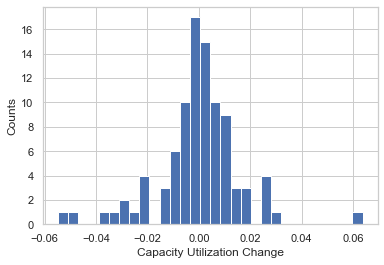

In [687]:
plt.hist(cpi_caputil['Capacity Utilization'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Capacity Utilization Change')

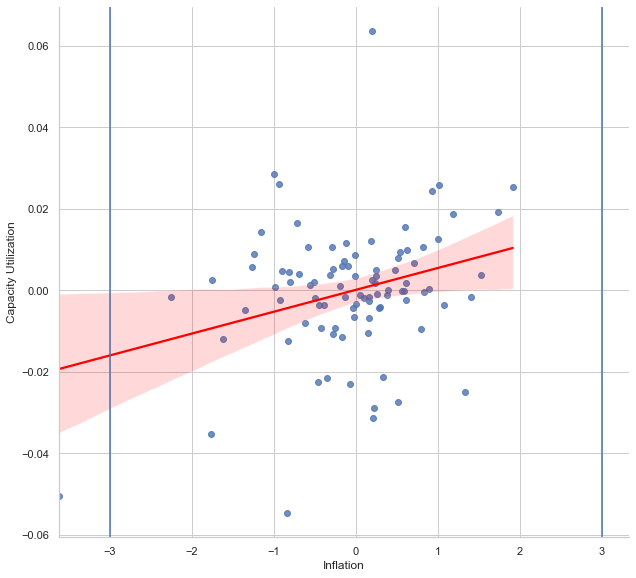

In [688]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Capacity Utilization",
                 height=8, aspect=1.1,
                 data=cpi_caputil, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Fairly clear that ±4% may be the boundaries; let's check.

In [689]:
caputil_outliers = np.abs(stats.zscore(cpi_caputil['Capacity Utilization']))
cap_thresh = 3
print(np.where( caputil_outliers >= cap_thresh ))

(array([70, 71, 92], dtype=int64),)


In [690]:
cpi_caputil['Capacity Utilization'][70],cpi_caputil['Capacity Utilization'][71],cpi_caputil['Capacity Utilization'][92]

(-0.0505237359421928, -0.054713257511720105, 0.06370140548844809)

One of them is a little hard to see & would be removed whe `Inflation` is scaled but we will remove all.

In [691]:
drop_cap_rows = [ 70, 71, 92 ]
cpi_caputil.drop(cpi_caputil.index[drop_cap_rows], inplace=True)

Text(0.5, 0, 'Capacity Utilization Change')

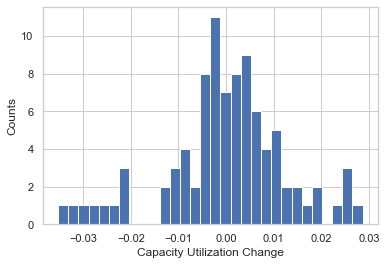

In [692]:
plt.hist(cpi_caputil['Capacity Utilization'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Capacity Utilization Change')

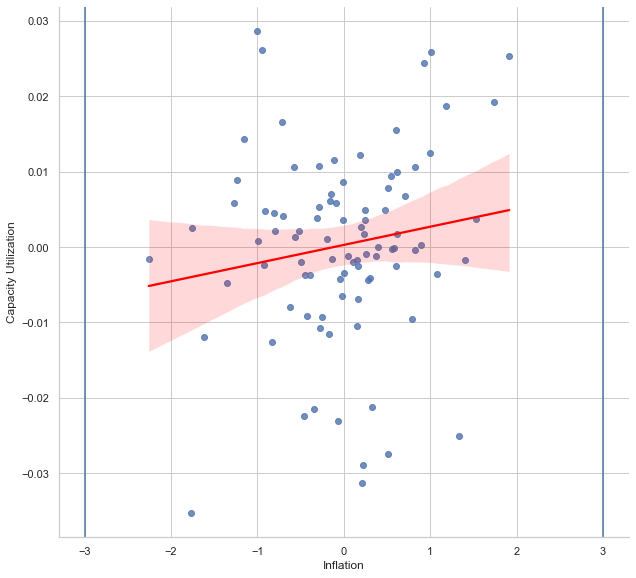

In [693]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Capacity Utilization",
                 height=8, aspect=1.1,
                 data=cpi_caputil, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [694]:
cpi_caputil['Capacity Utilization'].min(),cpi_caputil['Capacity Utilization'].max()

(-0.03527496871399027, 0.028656210202382182)

Let's proceed; next `Wages CPI`

Text(0.5, 0, 'Wages CPI Change')

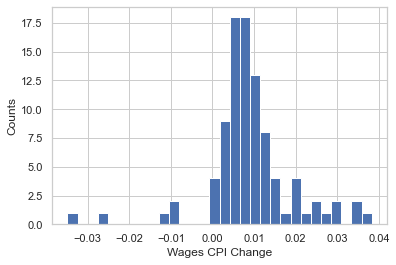

In [695]:
plt.hist(cpi_wagescpi['Wages CPI'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Wages CPI Change')

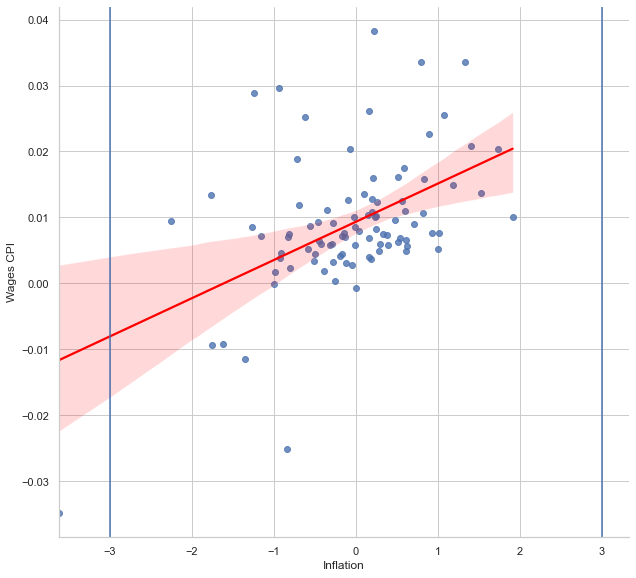

In [696]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Wages CPI",
                 height=8, aspect=1.1,
                 data=cpi_wagescpi, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [697]:
cpi_wagescpi['Wages CPI'].min(),cpi_wagescpi['Wages CPI'].max()

(-0.03486444203390904, 0.038299324597635964)

I believe this is workable; next `Unemployment`

Text(0.5, 0, 'Unemployment Rate Change')

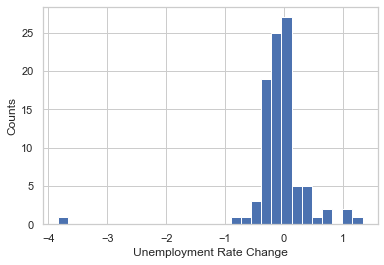

In [698]:
plt.hist(cpi_unemp_rate['Unemployment Rate'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Unemployment Rate Change')

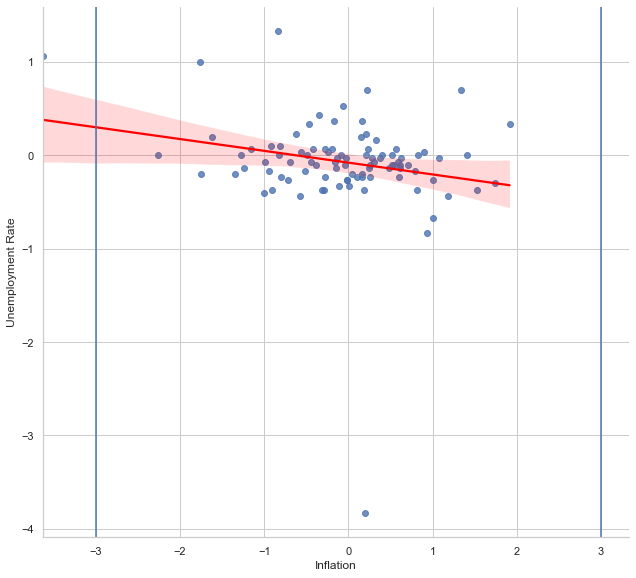

In [699]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Unemployment Rate",
                 height=8, aspect=1.1,
                 data=cpi_unemp_rate, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

One obvious outlier; let's continue.

In [700]:
unempl_outliers = np.abs(stats.zscore(cpi_unemp_rate['Unemployment Rate']))
cap_thresh = 3
print(np.where( unempl_outliers >= cap_thresh ))

(array([92], dtype=int64),)


In [701]:
cpi_unemp_rate['Unemployment Rate'][92]

-3.833333333333331

In [702]:
drop_unempl_rows = [ 92 ]
cpi_unemp_rate.drop(cpi_unemp_rate.index[drop_unempl_rows], inplace=True)

Text(0.5, 0, 'Unemployment Rate Change')

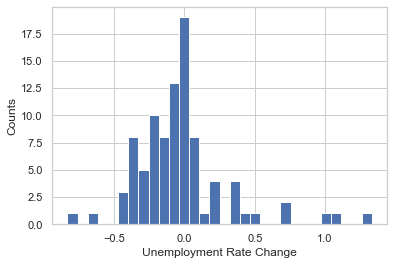

In [703]:
plt.hist(cpi_unemp_rate['Unemployment Rate'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Unemployment Rate Change')

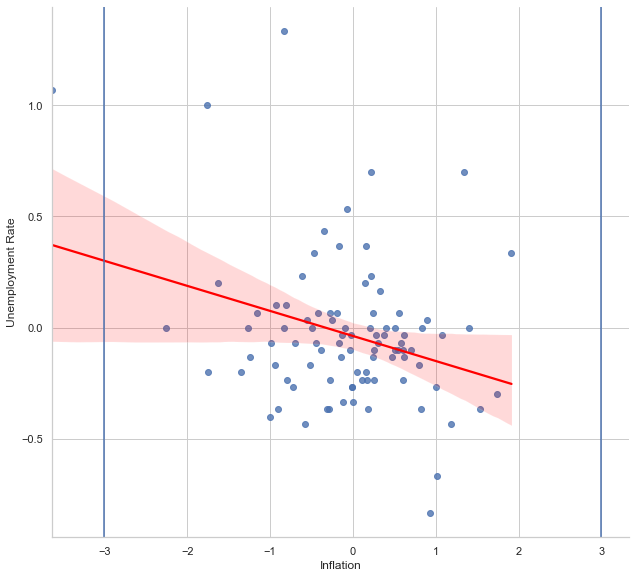

In [704]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Unemployment Rate",
                 height=8, aspect=1.1,
                 data=cpi_unemp_rate, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Visually there may be "some" albeit let's check.

In [705]:
unempl_outliers = np.abs(stats.zscore(cpi_unemp_rate['Unemployment Rate']))
cap_thresh = 3
print(np.where( unempl_outliers >= cap_thresh ))

(array([13, 70, 71], dtype=int64),)


In [706]:
cpi_unemp_rate['Unemployment Rate'][13],cpi_unemp_rate['Unemployment Rate'][70],cpi_unemp_rate['Unemployment Rate'][71]

(1.0000000000000007, 1.066666666666667, 1.333333333333334)

Establishing a ±1% may be fitting; we will scrape the last 2.

In [707]:
unem_drop = [ 70, 71 ]
cpi_unemp_rate.drop(cpi_unemp_rate.index[unem_drop], inplace=True)

Text(0.5, 0, 'Unemployment Rate Change')

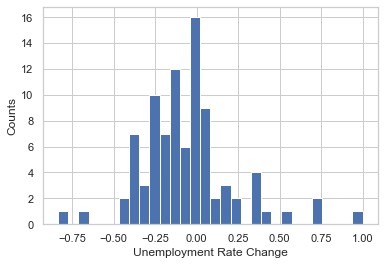

In [708]:
plt.hist(cpi_unemp_rate['Unemployment Rate'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Unemployment Rate Change')

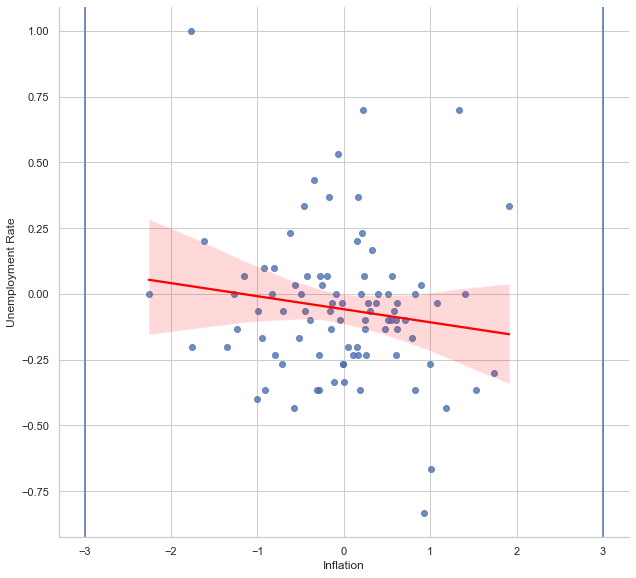

In [709]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Unemployment Rate",
                 height=8, aspect=1.1,
                 data=cpi_unemp_rate, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [710]:
cpi_unemp_rate['Unemployment Rate'].min(),cpi_unemp_rate['Unemployment Rate'].max()

(-0.8333333333333325, 1.0000000000000007)

Next `M2 Velocity`

In [711]:
cpi_velo_money.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 1967-09-30 to 2020-10-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Inflation    93 non-null     float64
 1   M2 Velocity  93 non-null     float64
dtypes: float64(2)
memory usage: 4.7 KB


In [712]:
cpi_velo_money['M2 Velocity'].sort_values()

Date
1986-05-31         -inf
1985-11-30         -inf
1998-10-31         -inf
2006-09-30         -inf
1970-01-31   -17.009024
                ...    
1968-11-30     1.671291
2020-02-29     2.098925
1970-10-31     3.801733
2001-03-31     5.879636
2009-10-31     6.491218
Name: M2 Velocity, Length: 93, dtype: float64

In [713]:
cpi_velo_money = cpi_velo_money.replace([np.inf, -np.inf], np.nan)
cpi_velo_money = cpi_velo_money.dropna()

In [714]:
cpi_velo_money['M2 Velocity'].sort_values()

Date
1970-01-31   -17.009024
1970-02-28   -17.009024
1997-05-31    -8.506900
2002-08-31    -7.323703
1973-03-31    -4.512552
                ...    
1968-11-30     1.671291
2020-02-29     2.098925
1970-10-31     3.801733
2001-03-31     5.879636
2009-10-31     6.491218
Name: M2 Velocity, Length: 89, dtype: float64

Text(0.5, 0, 'M2 Velocity Change')

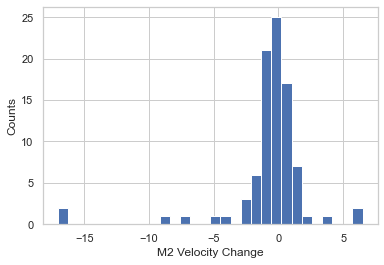

In [715]:
plt.hist(cpi_velo_money['M2 Velocity'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('M2 Velocity Change')

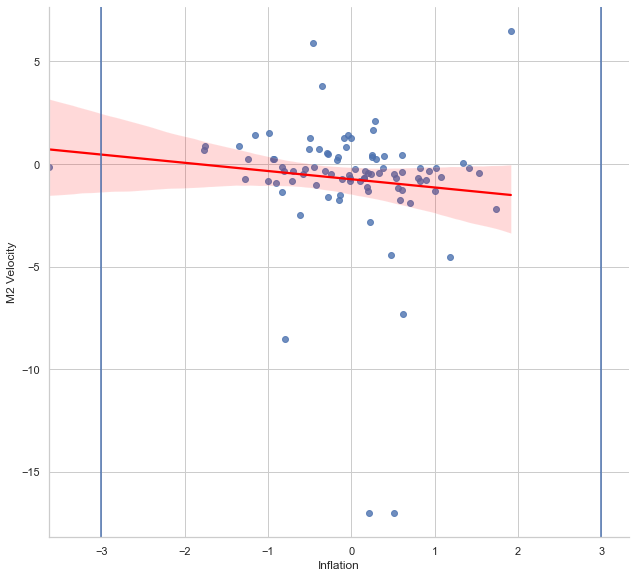

In [716]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="M2 Velocity",
                 height=8, aspect=1.1,
                 data=cpi_velo_money, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [717]:
money_velo_outliers = np.abs(stats.zscore(cpi_velo_money['M2 Velocity']))
velo_thresh = 3
print(np.where( money_velo_outliers >= velo_thresh ))

(array([4, 5], dtype=int64),)


In [718]:
cpi_velo_money['M2 Velocity'][4],cpi_velo_money['M2 Velocity'][5]

(-17.009024252677573, -17.009024252677573)

In [719]:
velo_drop = [ 4, 5 ]
cpi_velo_money.drop(cpi_velo_money.index[velo_drop], inplace=True)

Text(0.5, 0, 'M2 Velocity Change')

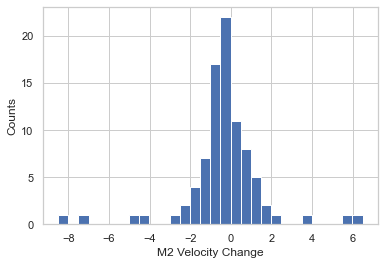

In [720]:
plt.hist(cpi_velo_money['M2 Velocity'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('M2 Velocity Change')

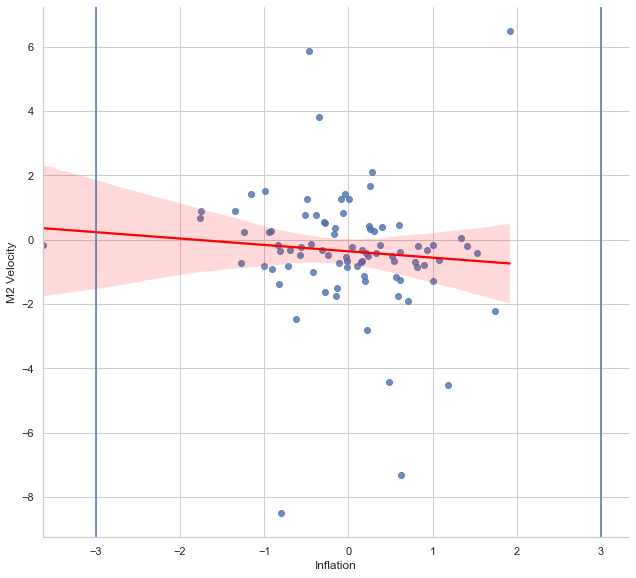

In [721]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="M2 Velocity",
                 height=8, aspect=1.1,
                 data=cpi_velo_money, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [722]:
money_velo_outliers = np.abs(stats.zscore(cpi_velo_money['M2 Velocity']))
velo_thresh = 3
print(np.where( money_velo_outliers >= velo_thresh ))

(array([47, 52, 54, 66], dtype=int64),)


In [723]:
cpi_velo_money['M2 Velocity'][47],cpi_velo_money['M2 Velocity'][52],cpi_velo_money['M2 Velocity'][54],cpi_velo_money['M2 Velocity'][66]

(-8.506899724010609, 5.879635828089331, -7.323703328265002, 6.491217798594918)

I feel comfortable dropping these.

In [724]:
velo_drop = [ 47, 52, 54, 66 ]
cpi_velo_money.drop(cpi_velo_money.index[velo_drop], inplace=True)

Text(0.5, 0, 'M2 Velocity Change')

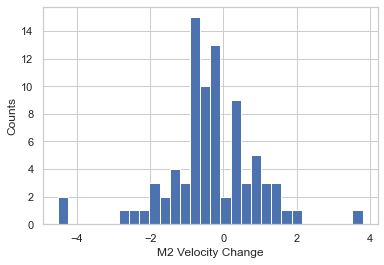

In [725]:
plt.hist(cpi_velo_money['M2 Velocity'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('M2 Velocity Change')

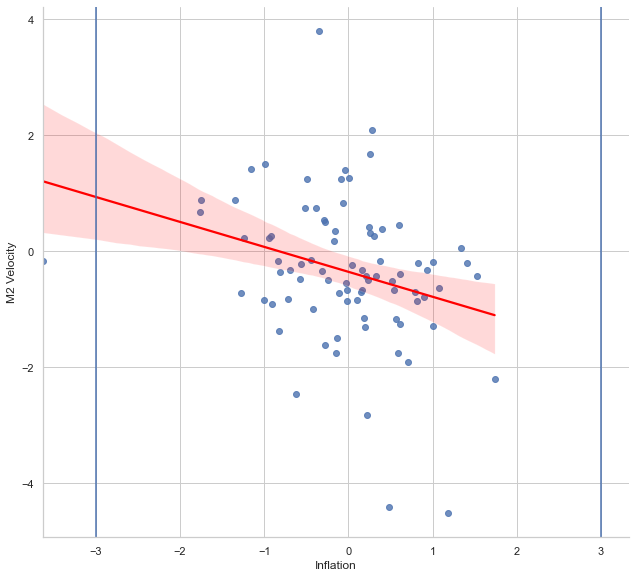

In [726]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="M2 Velocity",
                 height=8, aspect=1.1,
                 data=cpi_velo_money, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

I will take a look at where these are.

In [727]:
money_velo_outliers = np.abs(stats.zscore(cpi_velo_money['M2 Velocity']))
velo_thresh = 3
print(np.where( money_velo_outliers >= velo_thresh ))

(array([4, 6, 7], dtype=int64),)


In [728]:
cpi_velo_money['M2 Velocity'][4],cpi_velo_money['M2 Velocity'][6],cpi_velo_money['M2 Velocity'][7]

(3.8017332095326237, -4.414478651119822, -4.51255230125515)

Let's drop these.

In [729]:
velo_drop = [ 4, 6, 7 ]
cpi_velo_money.drop(cpi_velo_money.index[velo_drop], inplace=True)

Text(0.5, 0, 'M2 Velocity Change')

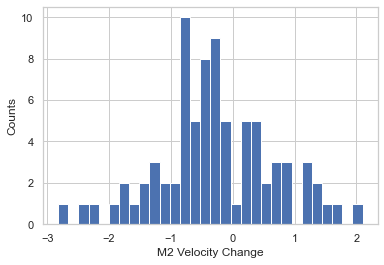

In [730]:
plt.hist(cpi_velo_money['M2 Velocity'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('M2 Velocity Change')

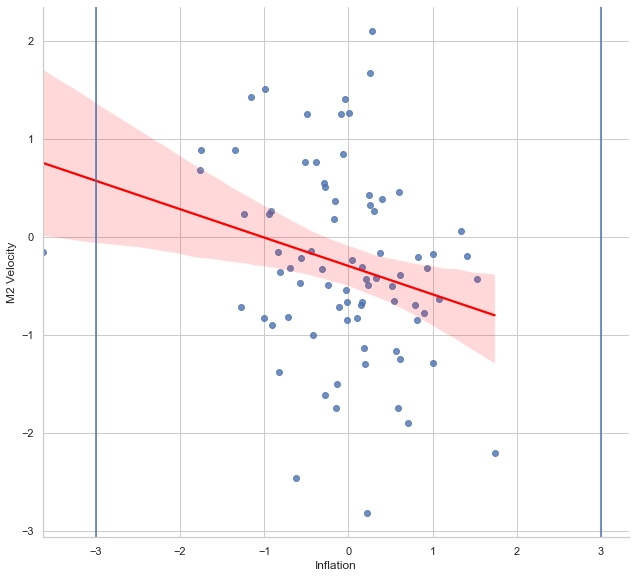

In [731]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="M2 Velocity",
                 height=8, aspect=1.1,
                 data=cpi_velo_money, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [732]:
cpi_velo_money['M2 Velocity'].min(),cpi_velo_money['M2 Velocity'].max()

(-2.8215623327982877, 2.0989247311827866)

I find it strange that these are negatively correlated but we will work with these.

Next `GDP`

Text(0.5, 0, 'GDP Change')

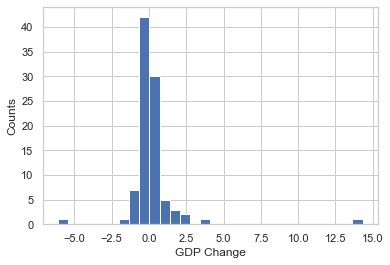

In [733]:
plt.hist(cpi_gdp_new['GDP'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('GDP Change')

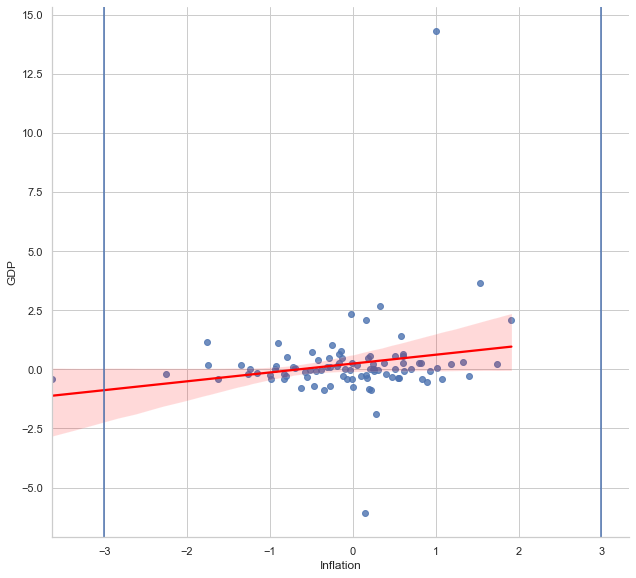

In [734]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="GDP",
                 height=8, aspect=1.1,
                 data=cpi_gdp_new, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Obvious outliers; let's investigate futher.

In [735]:
gdp_outliers = np.abs(stats.zscore(cpi_gdp_new['GDP']))
cap_thresh = 3
print(np.where( gdp_outliers >= cap_thresh ))

(array([69, 80], dtype=int64),)


In [736]:
cpi_gdp_new['GDP'][69],cpi_gdp_new['GDP'][80]

(-6.084806692182221, 14.311552961833272)

In [737]:
gdp_drop= [ 69, 80 ]
cpi_gdp_new.drop(cpi_gdp_new.index[gdp_drop], inplace=True)

Text(0.5, 0, 'GDP Change')

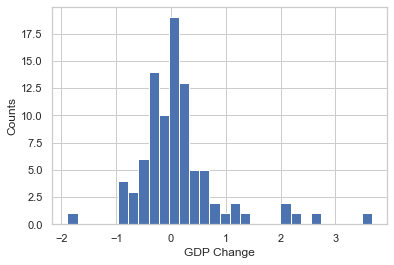

In [738]:
plt.hist(cpi_gdp_new['GDP'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('GDP Change')

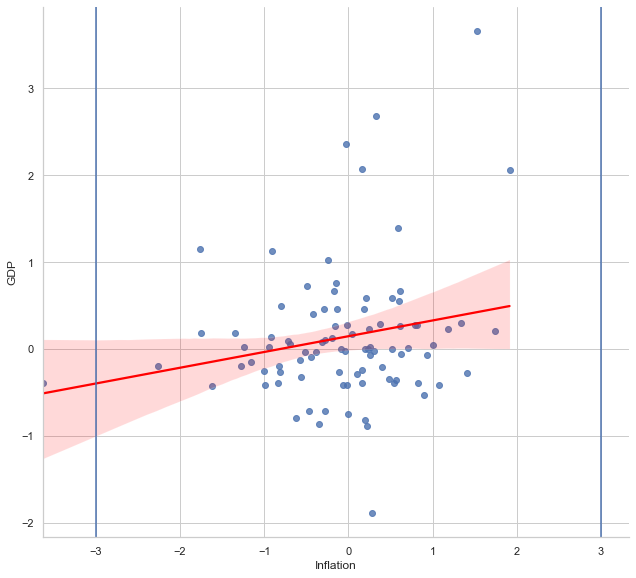

In [739]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="GDP",
                 height=8, aspect=1.1,
                 data=cpi_gdp_new, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Let's take one more look.

In [740]:
gdp_outlierz = np.abs(stats.zscore(cpi_gdp_new['GDP']))
cap_thresh = 3
print(np.where( gdp_outlierz >= cap_thresh ))

(array([58, 73], dtype=int64),)


In [741]:
cpi_gdp_new['GDP'][58],cpi_gdp_new['GDP'][73]

(2.6787120209768776, 3.6624858059001975)

If we dropped the first it would be difficult to clearly set the boundaries. In the spirit of not overfitting we will only clear the outlier +3.

In [742]:
gdp_droping = [ 73 ]
cpi_gdp_new.drop(cpi_gdp_new.index[gdp_droping], inplace=True)

Text(0.5, 0, 'GDP Change')

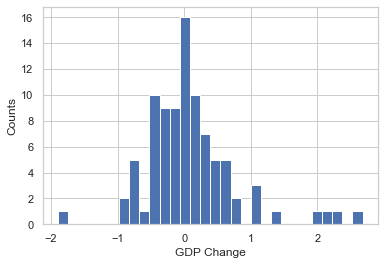

In [743]:
plt.hist(cpi_gdp_new['GDP'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('GDP Change')

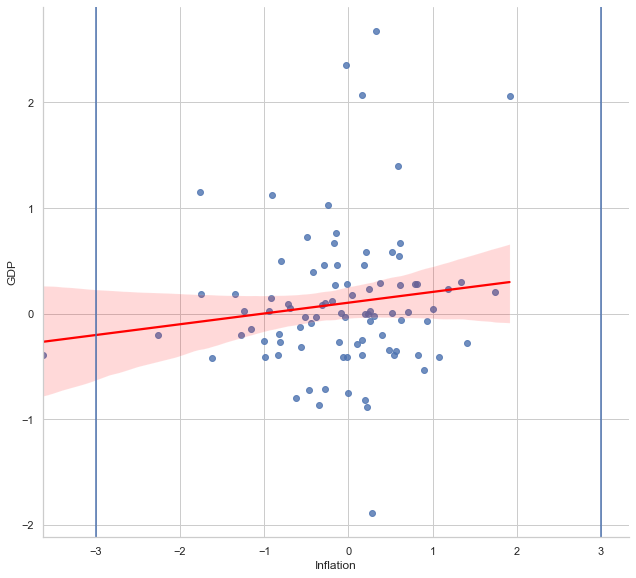

In [744]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="GDP",
                 height=8, aspect=1.1,
                 data=cpi_gdp_new, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [745]:
cpi_gdp_new['GDP'].min()

-1.8909183066642323

Not supper beautiful but let's work with this; next & final `Initial Jobless Claims`

Text(0.5, 0, 'Initial Jobless Claims')

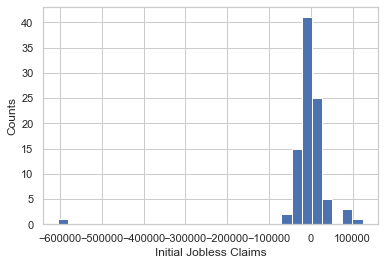

In [746]:
plt.hist(cpi_intjobs['Initial Jobless Claims'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Initial Jobless Claims')

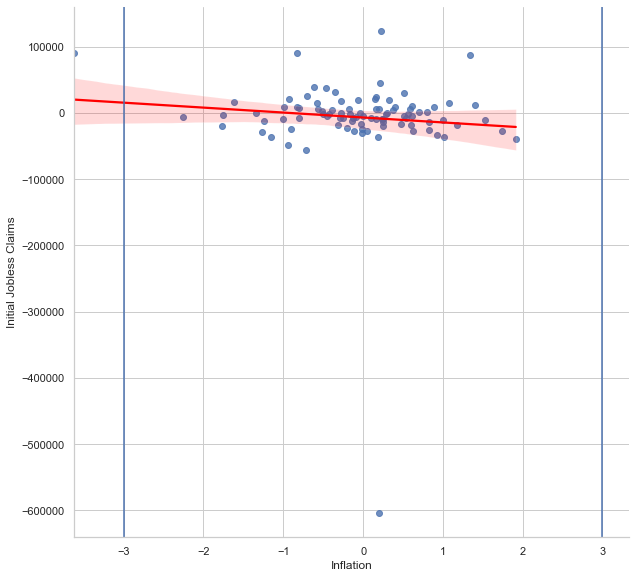

In [747]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Initial Jobless Claims",
                 height=8, aspect=1.1,
                 data=cpi_intjobs, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

Let's go.

In [748]:
intjob_outliers = np.abs(stats.zscore(cpi_intjobs['Initial Jobless Claims']))
cap_thresh = 3
print(np.where( intjob_outliers >= cap_thresh ))

(array([92], dtype=int64),)


In [749]:
cpi_intjobs['Initial Jobless Claims'][92]

-604333.3333333334

In [750]:
intjobs_droping = [ 92 ]
cpi_intjobs.drop(cpi_intjobs.index[intjobs_droping], inplace=True)

Text(0.5, 0, 'Initial Jobless Claims')

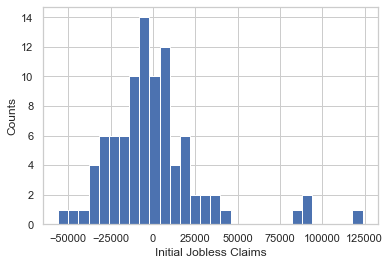

In [751]:
plt.hist(cpi_intjobs['Initial Jobless Claims'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Initial Jobless Claims')

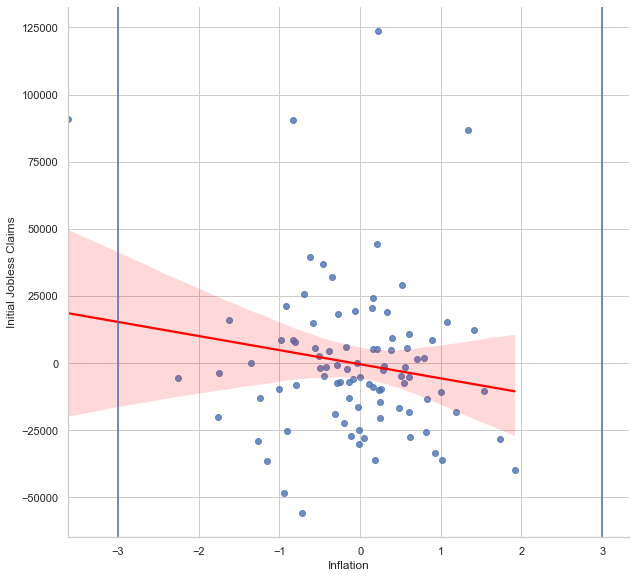

In [752]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Initial Jobless Claims",
                 height=8, aspect=1.1,
                 data=cpi_intjobs, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [753]:
intjob_outliers_2 = np.abs(stats.zscore(cpi_intjobs['Initial Jobless Claims']))
cap_thresh = 3
print(np.where( intjob_outliers_2 >= cap_thresh ))

(array([12, 21, 70, 71], dtype=int64),)


In [754]:
cpi_intjobs['Initial Jobless Claims'][12],cpi_intjobs['Initial Jobless Claims'][21],cpi_intjobs['Initial Jobless Claims'][70],cpi_intjobs['Initial Jobless Claims'][71]

(86666.66666666667, 123750.0, 90916.66666666667, 90500.0)

Unlike previous variables, I am happy to remove all listed above. Please also note, one does fall outside the `Inflation` scraping range but we will still remove.

In [755]:
intjobs_droping = [ 12, 21, 70, 71 ]
cpi_intjobs.drop(cpi_intjobs.index[intjobs_droping], inplace=True)

Text(0.5, 0, 'Initial Jobless Claims')

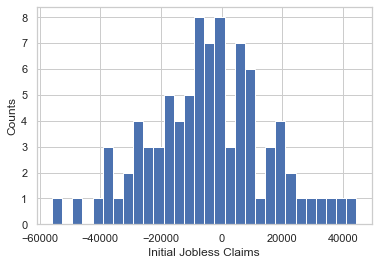

In [756]:
plt.hist(cpi_intjobs['Initial Jobless Claims'], density=False, bins=30)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Initial Jobless Claims')

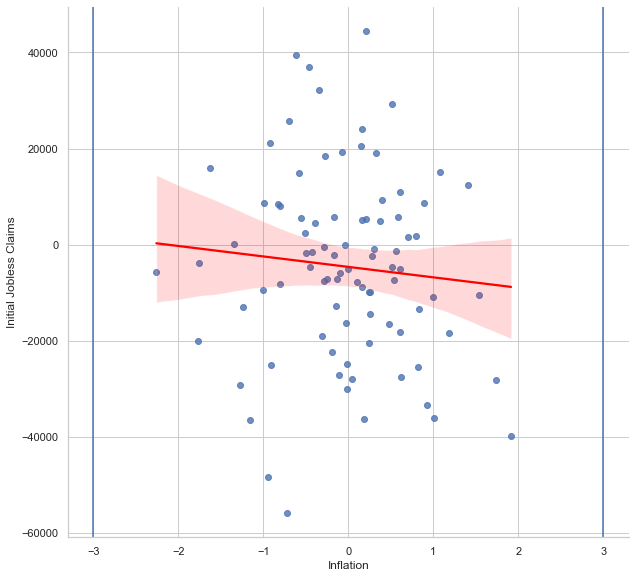

In [757]:
sns.set_color_codes()
sns.lmplot(x="Inflation", y="Initial Jobless Claims",
                 height=8, aspect=1.1,
                 data=cpi_intjobs, line_kws={'color': 'red'})
plt.axvline(3, 0, 1, label='pyplot vertical line')
plt.axvline(-3, 0, 1, label='pyplot vertical line')

In [758]:
cpi_intjobs['Initial Jobless Claims'].min()

-55916.666666666664

We have already scraped 5 so I will work with the above.

Now that they have been individually addressed, the next step is to merge all of the variables together with a forward fill.

First the variables but to obtain them individually we need to remove cpi from each.

In [759]:
# The recently completed ones

cpi_wagescpi_var = cpi_wagescpi[['Wages CPI']].copy()
cpi_caputil_var = cpi_caputil[['Capacity Utilization']].copy()
cpi_unemp_rate_var = cpi_unemp_rate[['Unemployment Rate']].copy()
cpi_gdp_new_var = cpi_gdp_new[['GDP']].copy()
cpi_intjobs_var = cpi_intjobs[['Initial Jobless Claims']].copy()
cpi_velo_money_vars = cpi_velo_money[['M2 Velocity']].copy()

In [760]:
# The completed ones before

QonQ_main_roll_WTI_var = QonQ_main_roll_WTI[['WTI']].copy()
QonQ_main_roll_Lumber_var = QonQ_main_roll_Lumber[['Lumber']].copy()
QonQ_main_roll_sugar_var = QonQ_main_roll_sugar[['Sugar']].copy()
QonQ_main_roll_wheat_var = QonQ_main_roll_wheat[['Wheat']].copy()
QonQ_main_roll_copper_var = QonQ_main_roll_copper[['Copper']].copy()
QonQ_main_roll_corn_var = QonQ_main_roll_corn[['Corn']].copy()
QonQ_main_roll_cattle_var = QonQ_main_roll_cattle[['Cattle']].copy()
QonQ_main_roll_dixie_var = QonQ_main_roll_dixie[['US Dollar Index']].copy()
QonQ_main_roll_soybeans_var = QonQ_main_roll_soybeans[['Soybeans']].copy()
QonQ_main_roll_heatoil_var = QonQ_main_roll_heatoil[['Heating Oil']].copy()
QonQ_main_roll_hogs_var = QonQ_main_roll_hogs[['Lean Hogs']].copy()

In [761]:
# Building out the variables first with a roll & forward fill

QonQ_vars_roll_post = pd.concat([QonQ_main_roll_heatoil_var,QonQ_main_roll_WTI_var,cpi_wagescpi_var,
                                 cpi_gdp_new_var,cpi_caputil_var,cpi_velo_money_vars,QonQ_main_roll_copper_var,QonQ_main_roll_sugar_var,
                                 QonQ_main_roll_hogs_var,QonQ_main_roll_corn_var,QonQ_main_roll_Lumber_var,
                                 QonQ_main_roll_soybeans_var,QonQ_main_roll_cattle_var,QonQ_main_roll_wheat_var,
                                 cpi_unemp_rate_var,QonQ_main_roll_dixie_var,cpi_intjobs_var
                       ],
                       axis = 1, ignore_index=False)
 
QonQ_vars_roll_post.columns= ['Heating Oil','WTI','Wages CPI','GDP','Capacity Utilization','M2 Velocity',
                              'Copper','Sugar','Lean Hogs','Corn','Lumber','Soybeans','Cattle','Wheat','Unemployment Rate',
                              'USD Index','Initial Jobless Claims'                              
                    ]

QonQ_vars_roll_post.index.names = ["Date"]
QonQ_vars_roll_post = QonQ_vars_roll_post.fillna(method='ffill')

# vars_mnth.tail()

In [762]:
QonQ_vars_roll_post.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 446 entries, 1967-09-30 to 2021-01-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Heating Oil             424 non-null    float64
 1   WTI                     393 non-null    float64
 2   Wages CPI               446 non-null    float64
 3   GDP                     446 non-null    float64
 4   Capacity Utilization    446 non-null    float64
 5   M2 Velocity             446 non-null    float64
 6   Copper                  337 non-null    float64
 7   Sugar                   424 non-null    float64
 8   Lean Hogs               424 non-null    float64
 9   Corn                    424 non-null    float64
 10  Lumber                  424 non-null    float64
 11  Soybeans                322 non-null    float64
 12  Cattle                  424 non-null    float64
 13  Wheat                   322 non-null    float64
 14  Unemployment Rate      

Take a look at your minimum which is `Soybeans` to loc the dataframe.

In [763]:
QonQ_vars_roll_post['Soybeans'].tail(324)

Date
1990-05-31         NaN
1990-06-30         NaN
1990-07-31    0.048360
1990-08-31    0.005202
1990-10-31    0.002314
                ...   
2020-09-30    0.088687
2020-10-31    0.088687
2020-11-30    0.189713
2020-12-31    0.212504
2021-01-31    0.247356
Name: Soybeans, Length: 324, dtype: float64

In [764]:
QonQ_vars_roll_post = QonQ_vars_roll_post.loc['1990-07-31':today_y_m_d_dash]

In [765]:
QonQ_vars_roll_post.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 1990-07-31 to 2021-01-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Heating Oil             322 non-null    float64
 1   WTI                     322 non-null    float64
 2   Wages CPI               322 non-null    float64
 3   GDP                     322 non-null    float64
 4   Capacity Utilization    322 non-null    float64
 5   M2 Velocity             322 non-null    float64
 6   Copper                  322 non-null    float64
 7   Sugar                   322 non-null    float64
 8   Lean Hogs               322 non-null    float64
 9   Corn                    322 non-null    float64
 10  Lumber                  322 non-null    float64
 11  Soybeans                322 non-null    float64
 12  Cattle                  322 non-null    float64
 13  Wheat                   322 non-null    float64
 14  Unemployment Rate      

We will start anew with cpi.

In [766]:
Q_cpi_master = cpi.diff(periods=3)

Let's merge them together.

In [767]:
QonQ_roll_appended = Q_cpi_master.merge(QonQ_vars_roll_post, how='left', on='Date')

QonQ_roll_appended.columns = ['Inflation','Heating Oil','WTI','Wages CPI','GDP','Capacity Utilization','M2 Velocity',
                              'Copper','Sugar','Lean Hogs','Corn','Lumber','Soybeans','Cattle','Wheat','Unemployment Rate',
                              'USD Index','Initial Jobless Claims']

QonQ_roll_appended = QonQ_roll_appended.dropna()

In [768]:
QonQ_roll_appended.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 1990-07-31 to 2021-01-31
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               322 non-null    float64
 1   Heating Oil             322 non-null    float64
 2   WTI                     322 non-null    float64
 3   Wages CPI               322 non-null    float64
 4   GDP                     322 non-null    float64
 5   Capacity Utilization    322 non-null    float64
 6   M2 Velocity             322 non-null    float64
 7   Copper                  322 non-null    float64
 8   Sugar                   322 non-null    float64
 9   Lean Hogs               322 non-null    float64
 10  Corn                    322 non-null    float64
 11  Lumber                  322 non-null    float64
 12  Soybeans                322 non-null    float64
 13  Cattle                  322 non-null    float64
 14  Wheat                  

Before we scrape `Inflation` we will take a look at how they currently correlate.

In [769]:
QonQ_roll_appended.corr(method='pearson')

Inflation  Heating Oil       WTI  Wages CPI       GDP  \
Inflation                1.000000     0.462869  0.485937   0.225119  0.061122   
Heating Oil              0.462869     1.000000  0.889394   0.196032  0.051520   
WTI                      0.485937     0.889394  1.000000   0.150995  0.038997   
Wages CPI                0.225119     0.196032  0.150995   1.000000  0.099726   
GDP                      0.061122     0.051520  0.038997   0.099726  1.000000   
Capacity Utilization     0.219150     0.191818  0.128480   0.147486 -0.111757   
M2 Velocity             -0.044030    -0.224271 -0.128444  -0.201308 -0.202357   
Copper                   0.281975     0.472324  0.511066   0.015212 -0.011301   
Sugar                    0.191750     0.231459  0.196207  -0.067596 -0.127804   
Lean Hogs                0.190010     0.123184  0.262108   0.170086  0.053458   
Corn                     0.231359     0.051853  0.102442   0.153932 -0.078642   
Lumber                   0.147605     0.113983  0.224374   0.038169  0.074362   
Soybeans                 0.171792     0.187893  0.243731   0.047912 -0.084747   
Cattle                   0.125391     0.196083  0.143890   0.190243 -0.067794   
Wheat                    0.116677     0.022571  0.043843   0.154746 -0.048005   
Unemployment Rate       -0.034698     0.036093  0.050177   0.028019  0.265087   
USD Index               -0.339413    -0.411348 -0.426752  -0.144636  0.055919   
Initial Jobless Claims  -0.211457    -0.138566 -0.143070  -0.244507 -0.068591   

                        Capacity Utilization  M2 Velocity    Copper     Sugar  \
Inflation                           0.219150    -0.044030  0.281975  0.191750   
Heating Oil                         0.191818    -0.224271  0.472324  0.231459   
WTI                                 0.128480    -0.128444  0.511066  0.196207   
Wages CPI                           0.147486    -0.201308  0.015212 -0.067596   
GDP                                -0.111757    -0.202357 -0.011301 -0.127804   
Capacity Utilization                1.000000    -0.053340  0.219757  0.134090   
M2 Velocity                        -0.053340     1.000000 -0.163868 -0.181769   
Copper                              0.219757    -0.163868  1.000000  0.303537   
Sugar                               0.134090    -0.181769  0.303537  1.000000   
Lean Hogs                           0.097880    -0.141773  0.186354 -0.134373   
Corn                                0.177976     0.046092  0.093419  0.098062   
Lumber                              0.000903     0.043581  0.204477 -0.028633   
Soybeans                            0.065932     0.097030  0.232222  0.155339   
Cattle                              0.183961    -0.194198  0.107460  0.069136   
Wheat                               0.206248     0.136593  0.115383  0.110030   
Unemployment Rate                  -0.437515     0.010970  0.071452 -0.030207   
USD Index                          -0.059104    -0.027828 -0.377438 -0.146019   
Initial Jobless Claims             -0.657022     0.013826 -0.137522 -0.075647   

                        Lean Hogs      Corn    Lumber  Soybeans    Cattle  \
Inflation                0.190010  0.231359  0.147605  0.171792  0.125391   
Heating Oil              0.123184  0.051853  0.113983  0.187893  0.196083   
WTI                      0.262108  0.102442  0.224374  0.243731  0.143890   
Wages CPI                0.170086  0.153932  0.038169  0.047912  0.190243   
GDP                      0.053458 -0.078642  0.074362 -0.084747 -0.067794   
Capacity Utilization     0.097880  0.177976  0.000903  0.065932  0.183961   
M2 Velocity             -0.141773  0.046092  0.043581  0.097030 -0.194198   
Copper                   0.186354  0.093419  0.204477  0.232222  0.107460   
Sugar                   -0.134373  0.098062 -0.028633  0.155339  0.069136   
Lean Hogs                1.000000  0.244356  0.275766  0.229591  0.104644   
Corn                     0.244356  1.000000  0.126829  0.715416  0.044792   
Lumber              

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

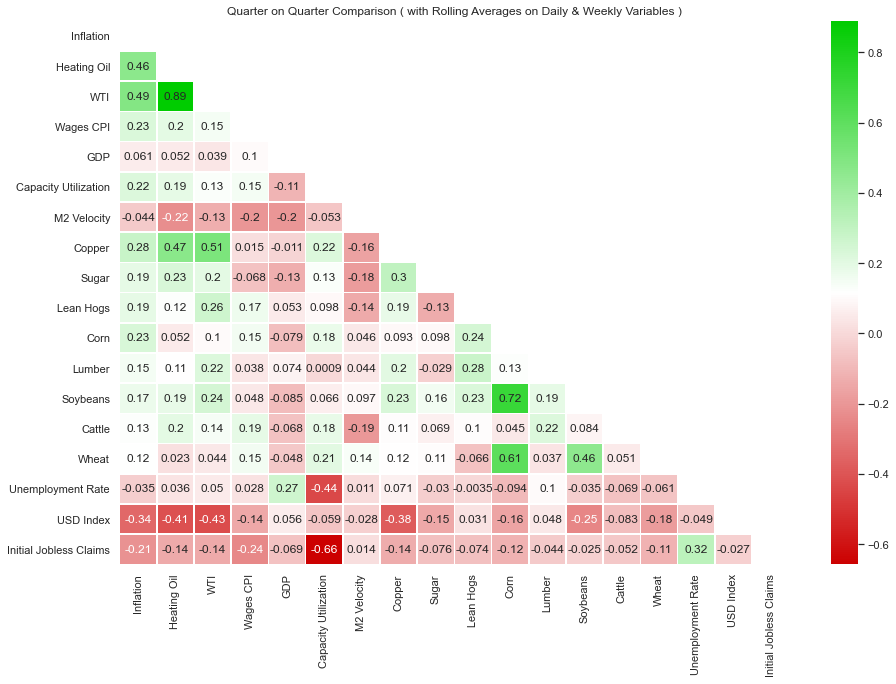

In [770]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_roll_appended.corr())
sns.heatmap(QonQ_roll_appended.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

We will now scrape `Inflation`.

Text(0, 0.5, 'Probability')

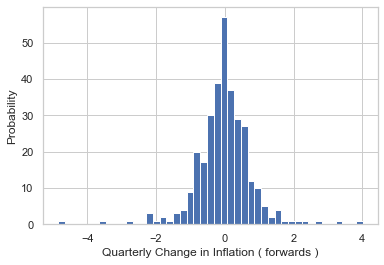

In [771]:
plt.hist(QonQ_roll_appended['Inflation'], bins=45)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

In [772]:
inf_out = np.abs(stats.zscore(QonQ_roll_appended['Inflation']))
inf_thresh = 3
print(np.where( inf_out >= inf_thresh ))

(array([163, 185, 186, 195, 196, 197], dtype=int64),)


The previous engagement with `Inflation` was ±300 bps; I would image it to be the same.

In [773]:
QonQ_roll_appended['Inflation'][163],QonQ_roll_appended['Inflation'][185],QonQ_roll_appended['Inflation'][186],QonQ_roll_appended['Inflation'][195],QonQ_roll_appended['Inflation'][196],QonQ_roll_appended['Inflation'][197]

(-2.84, -4.846, -3.625, 3.322, 4.007, 2.8089999999999997)

In [774]:
infl_drop = [ 185, 186, 195, 196 ]
QonQ_roll_appended.drop(QonQ_roll_appended.index[infl_drop], inplace=True)

Text(0, 0.5, 'Probability')

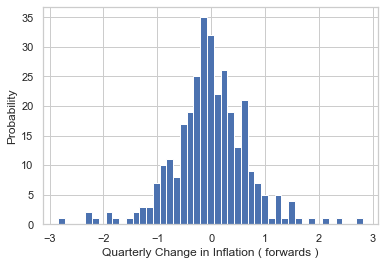

In [775]:
plt.hist(QonQ_roll_appended['Inflation'], bins=45)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

Let's see how well this approach panned out.

In [776]:
QonQ_roll_appended.corr(method='pearson')

Inflation  Heating Oil       WTI  Wages CPI       GDP  \
Inflation                1.000000     0.456372  0.444642   0.172434 -0.024130   
Heating Oil              0.456372     1.000000  0.890181   0.172097  0.037525   
WTI                      0.444642     0.890181  1.000000   0.101088  0.022908   
Wages CPI                0.172434     0.172097  0.101088   1.000000  0.082306   
GDP                     -0.024130     0.037525  0.022908   0.082306  1.000000   
Capacity Utilization     0.135035     0.172883  0.099957   0.126447 -0.160603   
M2 Velocity             -0.065294    -0.232354 -0.141988  -0.214203 -0.205973   
Copper                   0.209001     0.454515  0.487022  -0.031024 -0.040284   
Sugar                    0.166749     0.222212  0.184131  -0.091493 -0.149228   
Lean Hogs                0.154092     0.103719  0.238985   0.154130  0.044188   
Corn                     0.138725     0.011082  0.039388   0.112778 -0.105606   
Lumber                   0.096956     0.089702  0.190165   0.005323  0.070297   
Soybeans                 0.151124     0.167832  0.210419   0.017303 -0.079930   
Cattle                   0.082978     0.176844  0.108116   0.172142 -0.073012   
Wheat                    0.017605    -0.017398 -0.021662   0.116394 -0.063718   
Unemployment Rate       -0.060246     0.047950  0.079531   0.045154  0.245145   
USD Index               -0.256995    -0.384975 -0.380445  -0.095287  0.084108   
Initial Jobless Claims  -0.107904    -0.111909 -0.105616  -0.225499 -0.026371   

                        Capacity Utilization  M2 Velocity    Copper     Sugar  \
Inflation                           0.135035    -0.065294  0.209001  0.166749   
Heating Oil                         0.172883    -0.232354  0.454515  0.222212   
WTI                                 0.099957    -0.141988  0.487022  0.184131   
Wages CPI                           0.126447    -0.214203 -0.031024 -0.091493   
GDP                                -0.160603    -0.205973 -0.040284 -0.149228   
Capacity Utilization                1.000000    -0.056361  0.189799  0.115855   
M2 Velocity                        -0.056361     1.000000 -0.172345 -0.184250   
Copper                              0.189799    -0.172345  1.000000  0.291367   
Sugar                               0.115855    -0.184250  0.291367  1.000000   
Lean Hogs                           0.082507    -0.146410  0.167154 -0.145241   
Corn                                0.149811     0.041221  0.048157  0.082202   
Lumber                             -0.016019     0.039580  0.182589 -0.038548   
Soybeans                            0.065861     0.093367  0.218207  0.155027   
Cattle                              0.178011    -0.201173  0.084143  0.060967   
Wheat                               0.189039     0.133996  0.076625  0.098670   
Unemployment Rate                  -0.482983     0.015688  0.076299 -0.037948   
USD Index                          -0.020466    -0.021549 -0.342734 -0.129010   
Initial Jobless Claims             -0.638577     0.016928 -0.097208 -0.053406   

                        Lean Hogs      Corn    Lumber  Soybeans    Cattle  \
Inflation                0.154092  0.138725  0.096956  0.151124  0.082978   
Heating Oil              0.103719  0.011082  0.089702  0.167832  0.176844   
WTI                      0.238985  0.039388  0.190165  0.210419  0.108116   
Wages CPI                0.154130  0.112778  0.005323  0.017303  0.172142   
GDP                      0.044188 -0.105606  0.070297 -0.079930 -0.073012   
Capacity Utilization     0.082507  0.149811 -0.016019  0.065861  0.178011   
M2 Velocity             -0.146410  0.041221  0.039580  0.093367 -0.201173   
Copper                   0.167154  0.048157  0.182589  0.218207  0.084143   
Sugar                   -0.145241  0.082202 -0.038548  0.155027  0.060967   
Lean Hogs                1.000000  0.221620  0.260734  0.215185  0.089772   
Corn                     0.221620  1.000000  0.093141  0.713458  0.012839   
Lumber              

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

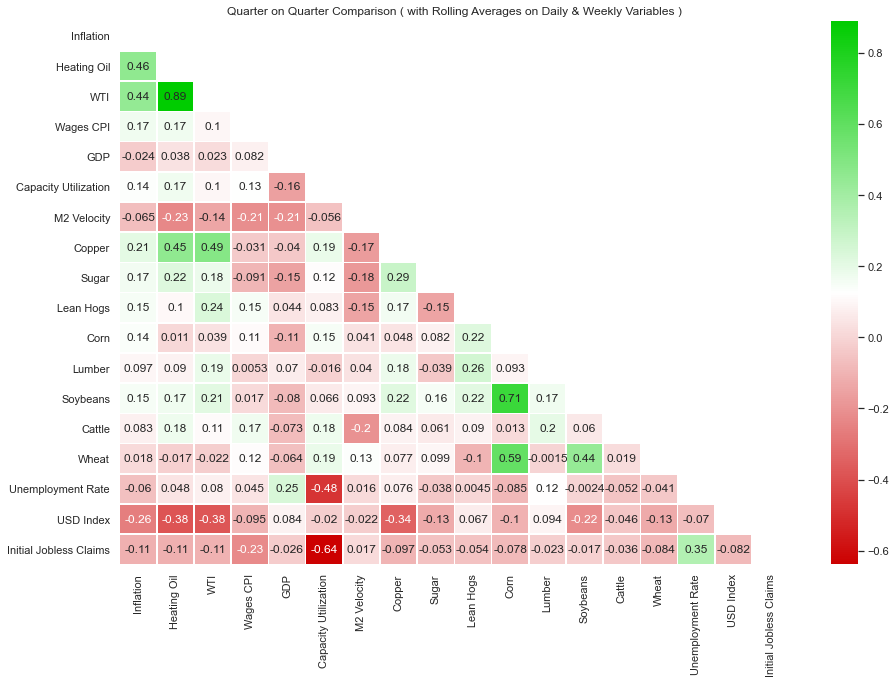

In [777]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_roll_appended.corr())
sns.heatmap(QonQ_roll_appended.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

With the only exception of the `USD Index`, all variables are posting less favorable results than the previous engagement ( 1.3.4 ). 

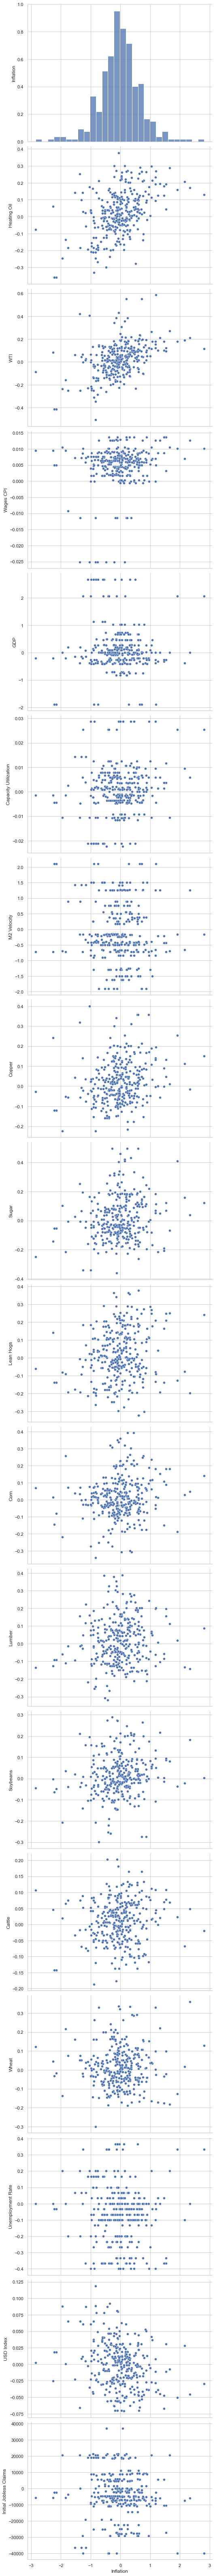

In [778]:
sns.pairplot(QonQ_roll_appended,
            y_vars=['Inflation','Heating Oil','WTI','Wages CPI','GDP','Capacity Utilization','M2 Velocity',
                              'Copper','Sugar','Lean Hogs','Corn','Lumber','Soybeans','Cattle','Wheat','Unemployment Rate',
                              'USD Index','Initial Jobless Claims'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

Both before & after herein is worse. There looks to be duplicate values & the approach did not work. 

**Think of a better approach.**

# 1.4.4 Scraping the Variables before they concat ( individually )

In this section, we will be doing the same process as 1.3.4 with the following changes:
   * We will first scrape the variables before we concat with a forward fill
   * We will remove `Natural Gas` given it's strong correlation to `WTI` & `Heating Oil`
   * We will introduce **some new variables** to potentially better or position; notably:
     * PMI Composite Index
     * **xx**


In [779]:
# We will officially start from the beginning
# Daily Data
usd_index_pre = quandl.get('CHRIS/ICE_DX1')
wti_pre = quandl.get('CHRIS/CME_CL1')
copper_pre = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
soybeans_pre = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
heatoil_pre = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
corn_pre = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
wheat_pre = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
cattle_pre = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
sugar_pre = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
lumber_pre = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
leanhogs_pre = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
int_job_claims_pre = quandl.get('FRED/ICSA')    # Hasn't been factored in yet

# Monthly Data
cpi_pre = quandl.get('RATEINF/INFLATION_USA')
wages_cpi_pre = fred.get_series('CWSR0000SA0')
cap_util_pre = fred.get_series('TCU')
unrate_pre = quandl.get('FRED/UNRATE')          # Hasn't been factored in yet
comppmi_pre = quandl.get('ISM/MAN_PMI')

# Quarterly Data
m2_velo_pre = fred.get_series('M2V')
gdp_pre = fred.get_series('GDP')


In [780]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_pre = usd_index_pre['Settle'].pct_change(periods=66)
Q_wti_pre = wti_pre['Last'].pct_change(periods=66)

Q_copper_pre = copper_pre['Close'].pct_change(periods=66)
Q_soybeans_pre = soybeans_pre['Close'].pct_change(periods=66)
Q_heatoil_pre = heatoil_pre['Close'].pct_change(periods=66)
Q_corn_pre = corn_pre['Close'].pct_change(periods=66)
Q_wheat_pre = wheat_pre['Close'].pct_change(periods=66)
Q_cattle_pre = cattle_pre['Close'].pct_change(periods=66)
Q_sugar_pre = sugar_pre['Close'].pct_change(periods=66)
Q_lumber_pre = lumber_pre['Close'].pct_change(periods=66)
Q_leanhogs_pre = leanhogs_pre['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_pre = int_job_claims_pre.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_pre = cap_util_pre.pct_change(periods=3)
Q_wages_pre = wages_cpi_pre.pct_change(periods=3)
Q_cpi_pre = cpi_pre.diff(periods=-3)
Q_unrate_pre = unrate_pre.diff(periods=3)
Q_comppmi_pre = comppmi_pre.pct_change(periods=3)


# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp_pre = gdp_pre.pct_change(periods=1)
Q_m2_velo_pre = m2_velo_pre.pct_change(periods=1)

In [781]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_roll_pre = Q_usd_index_pre.rolling(66).mean()
Q_wti_roll_pre = Q_wti_pre.rolling(66).mean()

Q_copper_roll_pre = Q_copper_pre.rolling(66).mean()
Q_soybeans_roll_pre = Q_soybeans_pre.rolling(66).mean()
Q_heatoil_roll_pre = Q_heatoil_pre.rolling(66).mean()
Q_corn_roll_pre = Q_corn_pre.rolling(66).mean()
Q_wheat_roll_pre = Q_wheat_pre.rolling(66).mean()
Q_cattle_roll_pre = Q_cattle_pre.rolling(66).mean()
Q_sugar_roll_pre = Q_sugar_pre.rolling(66).mean()
Q_lumber_roll_pre = Q_lumber_pre.rolling(66).mean()
Q_leanhogs_roll_pre = Q_leanhogs_pre.rolling(66).mean()

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll_pre = Q_intjobs_pre.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll_pre = Q_caputil_pre.rolling(3).mean()
Q_wages_roll_pre = Q_wages_pre.rolling(3).mean()
Q_unrate_roll_pre = Q_unrate_pre.rolling(3).mean()
Q_comppmi_roll_pre = Q_comppmi_pre.rolling(3).mean()

Q_cpi = Q_cpi_pre.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp_pre = Q_gdp_pre.pct_change(periods=1)
Q_m2_velo_pre = Q_m2_velo_pre.pct_change(periods=1)

We shall start the top & work our way down. First `US Dollar Index`

In [782]:
len(Q_usd_index_roll_pre)

9012

Text(0, 0.5, 'Probability')

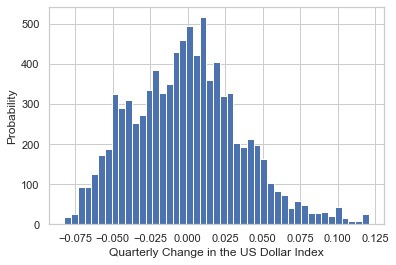

In [783]:
plt.hist(Q_usd_index_roll_pre, bins=45)
plt.xlabel('Quarterly Change in the US Dollar Index')
plt.ylabel('Probability')

In [784]:
pre_usd_out = np.abs(stats.zscore(Q_usd_index_roll_pre, axis=0, nan_policy='omit'))
pre_usd_out_thresh = 3
print(np.where( pre_usd_out >= pre_usd_out_thresh ))
usd_list = np.where( pre_usd_out >= pre_usd_out_thresh )

(array([5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858,
       5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869,
       5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880,
       5881, 5882, 5883, 5884, 5885, 5886], dtype=int64),)


In [785]:
for i in usd_list:
    print(Q_usd_index_roll_pre[i])

Date
2008-11-18    0.109481
2008-11-19    0.110774
2008-11-20    0.112019
2008-11-21    0.113525
2008-11-24    0.114433
2008-11-25    0.115001
2008-11-26    0.115547
2008-11-27    0.116224
2008-11-28    0.117112
2008-12-01    0.118038
2008-12-02    0.118822
2008-12-03    0.119503
2008-12-04    0.120121
2008-12-05    0.120691
2008-12-08    0.120729
2008-12-09    0.120400
2008-12-10    0.120263
2008-12-11    0.119764
2008-12-12    0.118991
2008-12-15    0.118577
2008-12-16    0.118301
2008-12-17    0.117919
2008-12-18    0.117221
2008-12-19    0.117168
2008-12-22    0.117138
2008-12-23    0.117672
2008-12-24    0.118143
2008-12-26    0.118416
2008-12-29    0.118494
2008-12-30    0.118539
2008-12-31    0.118429
2009-01-02    0.117721
2009-01-05    0.117059
2009-01-06    0.115898
2009-01-07    0.114819
2009-01-08    0.113030
2009-01-09    0.111734
2009-01-12    0.110641
2009-01-13    0.109551
Name: Settle, dtype: float64


In [786]:
# The below confirms the above is correct
# Q_usd_index_roll_pre[5848],Q_usd_index_roll_pre[5849],Q_usd_index_roll_pre[5850],Q_usd_index_roll_pre[5851],Q_usd_index_roll_pre[5852],Q_usd_index_roll_pre[5853],Q_usd_index_roll_pre[5854],Q_usd_index_roll_pre[5855],Q_usd_index_roll_pre[5856],Q_usd_index_roll_pre[5857],Q_usd_index_roll_pre[5858],Q_usd_index_roll_pre[5859],Q_usd_index_roll_pre[5860],Q_usd_index_roll_pre[5861],Q_usd_index_roll_pre[5862],Q_usd_index_roll_pre[5863],Q_usd_index_roll_pre[5864],Q_usd_index_roll_pre[5865],Q_usd_index_roll_pre[5866],Q_usd_index_roll_pre[5867],Q_usd_index_roll_pre[5868],Q_usd_index_roll_pre[5869],Q_usd_index_roll_pre[5870],Q_usd_index_roll_pre[5871],Q_usd_index_roll_pre[5872],Q_usd_index_roll_pre[5873],Q_usd_index_roll_pre[5874],Q_usd_index_roll_pre[5875],Q_usd_index_roll_pre[5876],Q_usd_index_roll_pre[5877],Q_usd_index_roll_pre[5878],Q_usd_index_roll_pre[5879],Q_usd_index_roll_pre[5880],Q_usd_index_roll_pre[5881],Q_usd_index_roll_pre[5882],Q_usd_index_roll_pre[5883],Q_usd_index_roll_pre[5884],Q_usd_index_roll_pre[5885],Q_usd_index_roll_pre[5886]

In [787]:
pre_usd_drop = [ usd_list ]
Q_usd_index_roll_pre.drop(Q_usd_index_roll_pre.index[usd_list], inplace=True)

Text(0, 0.5, 'Probability')

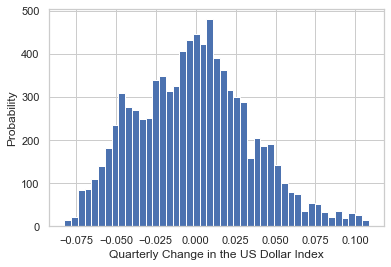

In [788]:
plt.hist(Q_usd_index_roll_pre, bins=45)
plt.xlabel('Quarterly Change in the US Dollar Index')
plt.ylabel('Probability')

In [789]:
pre_usd_out = np.abs(stats.zscore(Q_usd_index_roll_pre, axis=0, nan_policy='omit'))
pre_usd_out_thresh = 3
print(np.where( pre_usd_out >= pre_usd_out_thresh ))
usd_list = np.where( pre_usd_out >= pre_usd_out_thresh )

(array([1404, 1405, 1406, 5845, 5846, 5847, 5848, 5849], dtype=int64),)


In [790]:
for i in usd_list:
    print(Q_usd_index_roll_pre[i])

Date
1991-06-19    0.105591
1991-06-20    0.105623
1991-06-21    0.105617
2008-11-13    0.105910
2008-11-14    0.107199
2008-11-17    0.108321
2009-01-14    0.107694
2009-01-15    0.106168
Name: Settle, dtype: float64


More or less the same with the exception of June '91; let's proceed.

In [791]:
pre_usd_drop = [ 1404, 1405, 1406, 5845, 5846, 5847, 5848, 5849 ]
Q_usd_index_roll_pre.drop(Q_usd_index_roll_pre.index[pre_usd_drop], inplace=True)

Text(0, 0.5, 'Probability')

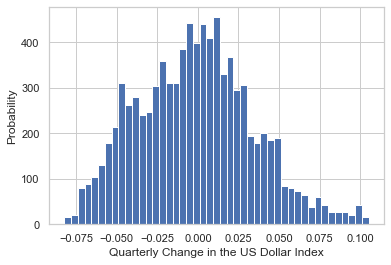

In [792]:
plt.hist(Q_usd_index_roll_pre, bins=45)
plt.xlabel('Quarterly Change in the US Dollar Index')
plt.ylabel('Probability')

In [793]:
pre_usd_out = np.abs(stats.zscore(Q_usd_index_roll_pre, axis=0, nan_policy='omit'))
pre_usd_out_thresh = 3
print(np.where( pre_usd_out >= pre_usd_out_thresh ))
usd_list = np.where( pre_usd_out >= pre_usd_out_thresh )

(array([1403, 1404], dtype=int64),)


In [794]:
Q_usd_index_roll_pre[1403],Q_usd_index_roll_pre[5839]

(0.10532609742611646, 0.10104845143183606)

In [795]:
pre_usd_drop_2 = [ 1403, 5839 ]
Q_usd_index_roll_pre.drop(Q_usd_index_roll_pre.index[pre_usd_drop_2], inplace=True)

Text(0, 0.5, 'Probability')

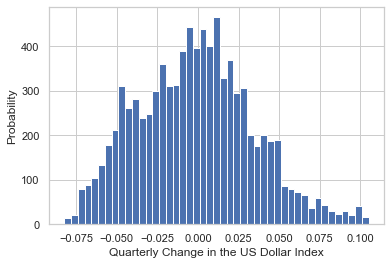

In [796]:
plt.hist(Q_usd_index_roll_pre, bins=45)
plt.xlabel('Quarterly Change in the US Dollar Index')
plt.ylabel('Probability')

In [797]:
pre_usd_out = np.abs(stats.zscore(Q_usd_index_roll_pre, axis=0, nan_policy='omit'))
pre_usd_out_thresh = 3
print(np.where( pre_usd_out >= pre_usd_out_thresh ))
usd_list = np.where( pre_usd_out >= pre_usd_out_thresh )

(array([1403, 1404], dtype=int64),)


In [798]:
Q_usd_index_roll_pre[1403],Q_usd_index_roll_pre[1404]

(0.105178604905243, 0.10496416544561284)

Similar to the previous rounds so we will continue to drop

In [799]:
pre_usd_drop_2 = [ 1403, 1404 ]
Q_usd_index_roll_pre.drop(Q_usd_index_roll_pre.index[pre_usd_drop_2], inplace=True)

Text(0, 0.5, 'Probability')

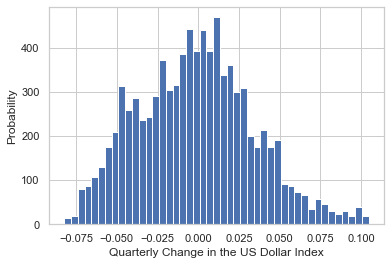

In [800]:
plt.hist(Q_usd_index_roll_pre, bins=45)
plt.xlabel('Quarterly Change in the US Dollar Index')
plt.ylabel('Probability')

In [801]:
pre_usd_out = np.abs(stats.zscore(Q_usd_index_roll_pre, axis=0, nan_policy='omit'))
pre_usd_out_thresh = 3
print(np.where( pre_usd_out >= pre_usd_out_thresh ))
usd_list = np.where( pre_usd_out >= pre_usd_out_thresh )

(array([], dtype=int64),)


In [802]:
print('We removed,', round(((( 9011 - len(Q_usd_index_roll_pre) ) / 9011 ) * 100),2),'% of the dataset; thats acceptable')

We removed, 0.55 % of the dataset; thats acceptable


Next `WTI`

In [803]:
len(Q_wti_roll_pre)

9529

Text(0, 0.5, 'Probability')

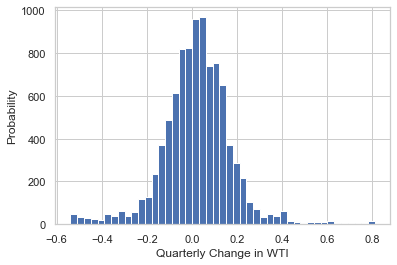

In [804]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

Noticable outliers on both ends.

In [805]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([ 761,  762,  763,  764,  765,  766,  767,  768,  769,  770,  771,
        772,  773,  774,  775,  776,  777,  778,  779,  780,  781,  782,
        783,  784, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895,
       1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906,
       1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 6455, 6456, 6457, 6458, 6459, 6460,
       6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471,
       6472, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482,
       6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6493,
       6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504,
       6505, 6506, 6507, 6508, 6509, 6510, 9324, 9325, 9326, 9327, 9328,
       9329, 9330, 9331, 9332, 9333, 9334, 9335, 9

In [806]:
for w in wti_list:
    print(Q_wti_roll_pre[w].sort_values())

Date
2009-01-20   -0.539073
2009-01-16   -0.538327
2009-01-21   -0.538000
2009-01-15   -0.536456
2009-01-22   -0.536156
                ...   
1990-11-08    0.802827
1990-11-07    0.807654
1990-11-02    0.808804
1990-11-05    0.810872
1990-11-06    0.811333
Name: Last, Length: 204, dtype: float64


Looks like the fallout of the previous recession & the early 90's; similar to the `US Dollar Index`

In [807]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

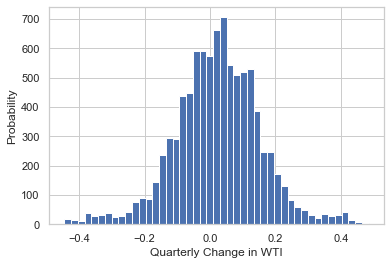

In [808]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

Cleaner. What's check how much we have removed.

In [809]:
print(round((( 9528 - len(Q_wti_roll_pre) ) / 9528 ),2),'% is not nearly half of a percent so we will continue to see.')

0.02 % is not nearly half of a percent so we will continue to see.


In [810]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([ 750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,
        761,  762,  763,  764,  765,  766,  767,  768,  769, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 6362, 6363, 6364, 6365, 6366, 6367,
       6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378,
       6379, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482,
       7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889,
       7890, 7891, 7892, 7893, 9178, 9179, 9180, 9181, 9182, 9183, 9184,
       9185, 9186, 9187, 9188, 9222, 9223, 9224, 9225, 9226, 9227, 9228,
       9229, 9230, 9231, 9232], dtype=int64),)


In [811]:
for w2 in wti_list:
    print(Q_wti_roll_pre[w2].sort_values())

Date
2020-05-06   -0.445782
1986-04-11   -0.444738
1986-05-16   -0.444276
2009-03-10   -0.442265
2008-12-15   -0.441778
                ...   
2020-10-08    0.471685
1990-12-27    0.478789
2020-08-17    0.479564
1990-10-02    0.479979
2020-10-07    0.485179
Name: Last, Length: 92, dtype: float64


We are still hovering around the ±40% level; let's drop another round.

In [812]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

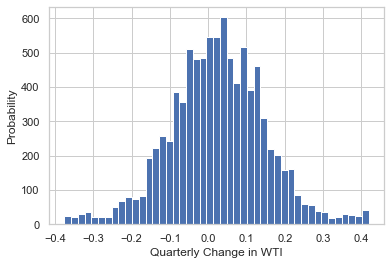

In [813]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

Marginally cleaner; let's look to see how much we have removed.

In [814]:
print(round((( 9528 - len(Q_wti_roll_pre) ) / 9528 ),2),'% is closer but still comforatable looking some more.')

0.03 % is closer but still comforatable looking some more.


In [815]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([ 747,  748,  749,  750,  751,  752, 1839, 3956, 3957, 3958, 3959,
       3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 6332, 6333, 6334,
       6335, 6336, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409,
       6410, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426,
       6427, 6428, 6429, 6430, 6431, 7812, 7813, 7814, 7815, 7816, 7817,
       7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828,
       9106, 9107, 9108, 9140, 9141, 9142], dtype=int64),)


In [816]:
for w2 in wti_list:
    print(Q_wti_roll_pre[w2].sort_values())

Date
2015-02-27   -0.375356
2015-02-26   -0.373234
1986-05-30   -0.372535
2015-03-23   -0.372096
2015-02-25   -0.371299
                ...   
2009-07-24    0.415883
2009-07-28    0.416121
2009-07-27    0.416184
2009-07-30    0.417363
2020-10-16    0.418901
Name: Last, Length: 72, dtype: float64


In [817]:
print('With these we are at',round((( 9528 - ( len(Q_wti_roll_pre) - 73 ) ) / 9528 ),2),'% which falls below a half of a percent so we can continue.')

With these we are at 0.04 % which falls below a half of a percent so we can continue.


In [818]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

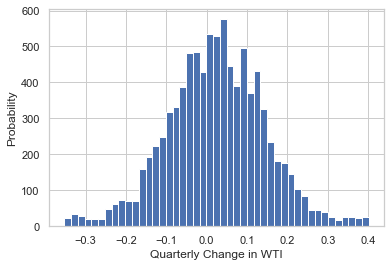

In [819]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

The above looks fairly reasonable; let's take another look.

In [820]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([ 746,  747, 1832, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 6311,
       6312, 6313, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382,
       6383, 6384, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 9039,
       9040, 9071, 9075], dtype=int64),)


In [821]:
for w2 in wti_list:
    print(Q_wti_roll_pre[w2].sort_values())

Date
2015-02-10   -0.352593
2008-11-24   -0.350996
2015-02-09   -0.350459
2015-03-30   -0.350264
2020-06-26   -0.349960
2009-03-23   -0.349036
2015-02-06   -0.348430
1986-06-04   -0.348406
1986-03-21   -0.347242
2015-03-31   -0.347003
2015-02-05   -0.345982
2008-11-21   -0.344589
2020-04-22   -0.344489
2015-02-04   -0.343238
2015-04-01   -0.342658
2009-08-21    0.389436
1999-06-29    0.390924
1999-06-03    0.391697
2009-06-18    0.392092
2020-10-20    0.392479
1999-06-28    0.394619
1999-06-25    0.395387
2009-06-19    0.395822
2009-07-10    0.396028
1999-06-04    0.397061
2009-08-20    0.397265
2009-07-13    0.397731
1999-06-24    0.397769
2009-07-09    0.398070
1990-09-26    0.398171
2009-06-22    0.398901
2009-07-14    0.399849
2009-07-08    0.400519
2020-10-26    0.400554
1999-06-23    0.400691
2009-07-15    0.401481
Name: Last, dtype: float64


In [822]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

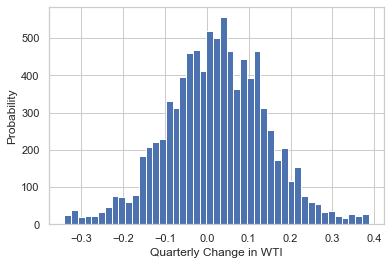

In [823]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

In [824]:
print('With these we are at',round((( 9528 - ( len(Q_wti_roll_pre) - len(wti_list) ) ) / 9528 ),2),'% which falls below a half of a percent so we can continue.')

With these we are at 0.04 % which falls below a half of a percent so we can continue.


In [825]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([ 745,  746, 1830, 3943, 3944, 6300, 6301, 6360, 6361, 7732, 7733,
       7734, 8056, 8057, 9036], dtype=int64),)


In [826]:
for w2 in wti_list:
    print(Q_wti_roll_pre[w2].sort_values())

Date
1986-03-20   -0.340090
2015-02-03   -0.339918
2015-04-02   -0.338111
1986-06-05   -0.338101
2015-02-02   -0.337706
2008-11-20   -0.337374
2009-03-24   -0.336806
1991-01-03    0.381860
2009-08-24    0.382539
2016-07-13    0.382548
2016-07-14    0.382722
2009-06-17    0.385667
1999-06-02    0.386239
1999-06-30    0.386624
2020-08-10    0.386688
Name: Last, dtype: float64


In [827]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

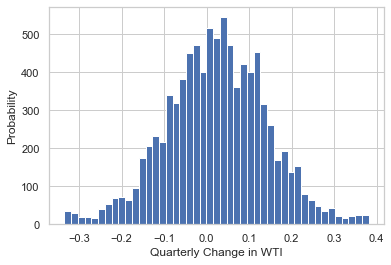

In [828]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

In [829]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([3939, 3940, 6352, 7722, 8043, 8044], dtype=int64),)


In [830]:
for w2 in wti_list:
    print(Q_wti_roll_pre[w2].sort_values())

Date
2015-01-30   -0.334955
2009-06-16    0.379569
1999-06-01    0.380993
2016-07-15    0.381038
1999-07-01    0.381452
2016-07-12    0.381608
Name: Last, dtype: float64


In [831]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

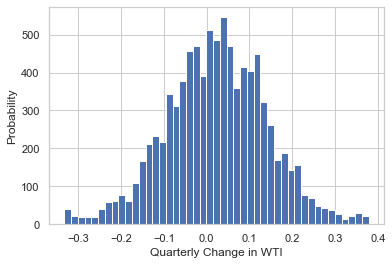

In [832]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

In [833]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([1827, 8039], dtype=int64),)


In [834]:
for w2 in wti_list:
    print(Q_wti_roll_pre[w2].sort_values())

Date
1990-09-25    0.378335
2016-07-18    0.378593
Name: Last, dtype: float64


In [835]:
Q_wti_roll_pre.drop(Q_wti_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

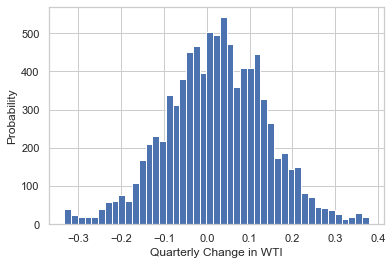

In [836]:
plt.hist(Q_wti_roll_pre, bins=45)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Probability')

In [837]:
pre_wti_out = np.abs(stats.zscore(Q_wti_roll_pre, axis=0, nan_policy='omit'))
pre_wti_out_thresh = 3
print(np.where( pre_wti_out >= pre_wti_out_thresh ))
wti_list = np.where( pre_wti_out >= pre_usd_out_thresh )

(array([8037], dtype=int64),)


In [838]:
print('With those scrapes we are at',round((( 9528 - ( len(Q_wti_roll_pre) - len(wti_list) ) ) / 9528 ),2),'% reduction which is okay; lets move on.')

With those scrapes we are at 0.04 % reduction which is okay; lets move on.


Next `Copper`

In [839]:
len(Q_copper_roll_pre)

8222

Text(0, 0.5, 'Probability')

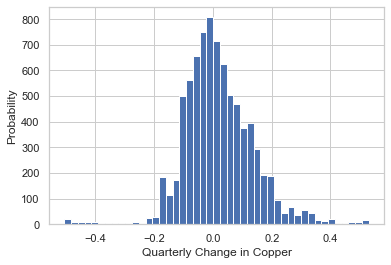

In [840]:
plt.hist(Q_copper_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Copper')
plt.ylabel('Probability')

In [841]:
pre_cop_out = np.abs(stats.zscore(Q_copper_roll_pre, axis=0, nan_policy='omit'))
pre_cop_out_thresh = 3
print(np.where( pre_cop_out >= pre_cop_out_thresh ))
cop_list = np.where( pre_cop_out >= pre_cop_out_thresh )

(array([ 131,  132, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476,
       4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487,
       4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498,
       4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509,
       4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 5097, 5098,
       5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109,
       5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120,
       5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131,
       5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142,
       5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153,
       5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5230, 5231,
       5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242,
       5243, 5244, 5245, 5246, 5247, 5248], dtype=int64),)


In [842]:
for i in cop_list:
    print(Q_copper_roll_pre[i].sort_values())

Date
2009-01-14   -0.505766
2009-01-12   -0.505615
2009-01-13   -0.505079
2009-01-08   -0.504715
2009-01-09   -0.504666
                ...   
2006-07-13    0.526796
2006-07-14    0.529250
2006-07-19    0.529524
2006-07-18    0.530141
2006-07-17    0.530210
Name: Close, Length: 138, dtype: float64


Let's correct; let's remove.

In [843]:
Q_copper_roll_pre.drop(Q_copper_roll_pre.index[wti_list], inplace=True)

Text(0, 0.5, 'Probability')

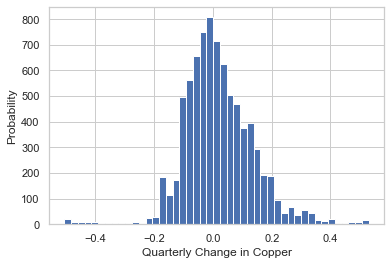

In [844]:
plt.hist(Q_copper_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Copper')
plt.ylabel('Probability')

Looks like it still needs work; let's continue.

In [845]:
pre_cop_out = np.abs(stats.zscore(Q_copper_roll_pre, axis=0, nan_policy='omit'))
pre_cop_out_thresh = 3
print(np.where( pre_cop_out >= pre_cop_out_thresh ))
cop_list = np.where( pre_cop_out >= pre_cop_out_thresh )

(array([ 131,  132, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476,
       4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487,
       4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498,
       4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509,
       4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 5097, 5098,
       5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109,
       5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120,
       5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131,
       5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142,
       5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153,
       5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5230, 5231,
       5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242,
       5243, 5244, 5245, 5246, 5247, 5248], dtype=int64),)


In [846]:
for i in cop_list:
    print(Q_copper_roll_pre[i].sort_values())

Date
2009-01-14   -0.505766
2009-01-12   -0.505615
2009-01-13   -0.505079
2009-01-08   -0.504715
2009-01-09   -0.504666
                ...   
2006-07-13    0.526796
2006-07-14    0.529250
2006-07-19    0.529524
2006-07-18    0.530141
2006-07-17    0.530210
Name: Close, Length: 138, dtype: float64


Although that does not look particularly incorrect; let's check how much we have removed in the previous round.

In [847]:
((8222 - len(Q_copper_roll_pre))/8222)*100

0.012162490878131841

Next `Soybeans`

In [848]:
len(Q_soybeans_roll_pre)

8088

Text(0, 0.5, 'Probability')

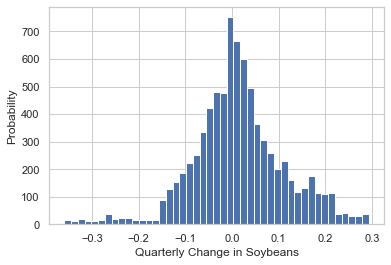

In [849]:
plt.hist(Q_soybeans_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Soybeans')
plt.ylabel('Probability')

In [850]:
pre_soy_out = np.abs(stats.zscore(Q_soybeans_roll_pre, axis=0, nan_policy='omit'))
pre_soy_out_thresh = 3
print(np.where( pre_soy_out >= pre_soy_out_thresh ))
soy_list = np.where( pre_soy_out >= pre_soy_out_thresh )

(array([3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737,
       3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748,
       3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759,
       3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 4780, 4781, 4782,
       4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793,
       4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804,
       4805, 4806, 4807, 4808], dtype=int64),)


In [851]:
for i in soy_list:
    print(Q_soybeans_roll_pre[i].sort_values())

Date
2004-10-18   -0.359508
2004-10-19   -0.359240
2004-10-21   -0.358790
2004-10-22   -0.358549
2004-10-20   -0.358418
                ...   
2004-09-28   -0.290721
2008-12-01   -0.289468
2009-01-12   -0.288847
2004-11-22   -0.287400
2004-09-27   -0.286235
Name: Close, Length: 70, dtype: float64


This seems to be entirely on the negative side which looks correct; let's remove.

In [852]:
Q_soybeans_roll_pre.drop(Q_soybeans_roll_pre.index[soy_list], inplace=True)

Text(0, 0.5, 'Probability')

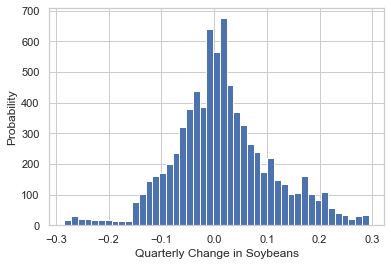

In [853]:
plt.hist(Q_soybeans_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Soybeans')
plt.ylabel('Probability')

Looks arguably on the negative side again but let's check.

In [854]:
pre_soy_out = np.abs(stats.zscore(Q_soybeans_roll_pre, axis=0, nan_policy='omit'))
pre_soy_out_thresh = 3
print(np.where( pre_soy_out >= pre_soy_out_thresh ))
soy_list = np.where( pre_soy_out >= pre_soy_out_thresh )

(array([3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733,
       3734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 6318, 6319, 6320,
       6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331,
       6332, 6333], dtype=int64),)


In [855]:
for i in soy_list:
    print(Q_soybeans_roll_pre[i].sort_values())

Date
2008-11-28   -0.284047
2004-11-23   -0.283412
2009-01-13   -0.282801
2004-09-24   -0.281428
2004-11-24   -0.280340
2008-11-26   -0.278753
2004-11-26   -0.277746
2009-01-14   -0.277193
2004-09-23   -0.277168
2004-11-29   -0.275454
2008-11-25   -0.273734
2004-11-30   -0.273107
2004-09-22   -0.272795
2014-10-15   -0.271666
2014-10-14   -0.271641
2014-10-13   -0.271626
2014-10-16   -0.271513
2014-10-10   -0.271466
2014-10-17   -0.271068
2014-10-20   -0.270651
2014-10-09   -0.270223
2004-12-01   -0.270098
2014-10-21   -0.269996
2014-10-22   -0.269650
2014-10-24   -0.269597
2014-10-27   -0.269416
2014-10-23   -0.269402
2009-01-15   -0.269372
2008-11-24   -0.268830
2004-09-21   -0.268789
2014-10-08   -0.268775
2004-12-02   -0.268239
2014-10-28   -0.267362
2014-10-07   -0.267263
2004-12-03   -0.267101
Name: Close, dtype: float64


Although this again visually appears correct lets double check where we stand on the # of scrapes as a percent of the original total & what this would also mean if we scraped this.

In [856]:
((8087 - len(Q_soybeans_roll_pre))/8087)*100

0.8532212192407568

Next `Heating Oil`

In [857]:
x = len(Q_heatoil_roll_pre)
x

10421

Text(0, 0.5, 'Probability')

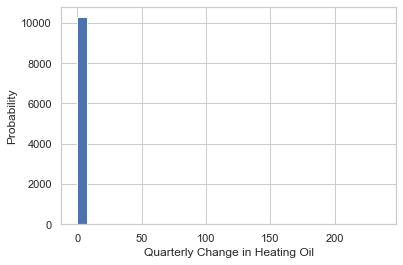

In [858]:
plt.hist(Q_heatoil_roll_pre, bins=30)
plt.xlabel('Quarterly Change in Heating Oil')
plt.ylabel('Probability')

In [859]:
pre_heat_out = np.abs(stats.zscore(Q_heatoil_roll_pre, axis=0, nan_policy='omit'))
pre_heat_out_thresh = 3
print(np.where( pre_heat_out >= pre_heat_out_thresh ))
heat_list = np.where( pre_heat_out >= pre_heat_out_thresh )

(array([131, 132], dtype=int64),)


In [860]:
for i in heat_list:
    print(Q_heatoil_roll_pre[i].sort_values())

Date
1980-07-08    118.948103
1980-07-07    235.751068
Name: Close, dtype: float64


Let's correct; let's remove.

In [861]:
Q_heatoil_roll_pre.drop(Q_heatoil_roll_pre.index[heat_list], inplace=True)

An issue I will resolve once I understand why the final outcome on the others is the result.

Next `Corn`

In [862]:
c = len(Q_corn_roll_pre)
c

10618

Text(0, 0.5, 'Probability')

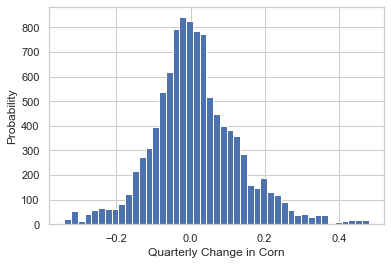

In [863]:
plt.hist(Q_corn_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Corn')
plt.ylabel('Probability')

In [864]:
pre_corn_out = np.abs(stats.zscore(Q_corn_roll_pre, axis=0, nan_policy='omit'))
pre_corn_out_thresh = 3
print(np.where( pre_corn_out >= pre_corn_out_thresh ))
corn_list = np.where( pre_corn_out >= pre_corn_out_thresh )

(array([2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186,
       2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197,
       2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 6817, 6818,
       6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829,
       6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840,
       6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851,
       6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862,
       6863, 6864, 6865, 6866, 6867], dtype=int64),)


In [865]:
for i in corn_list:
    print(Q_corn_roll_pre[i].sort_values())

Date
1988-08-11    0.375248
2007-03-02    0.377206
2006-12-18    0.380576
1988-08-12    0.382155
1988-09-23    0.384932
                ...   
2007-01-22    0.479764
2007-01-23    0.479883
2007-01-24    0.480140
2007-01-25    0.480232
2007-01-26    0.480516
Name: Close, Length: 82, dtype: float64


They are entirely on the positive side & scraping 82 observations is marginal so let's scrape.

In [866]:
Q_corn_roll_pre.drop(Q_corn_roll_pre.index[corn_list], inplace=True)

Text(0, 0.5, 'Probability')

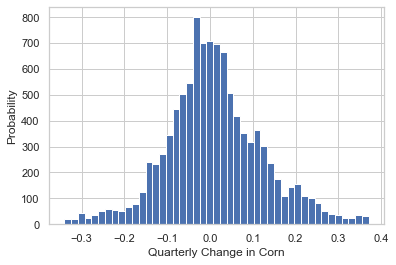

In [867]:
plt.hist(Q_corn_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Corn')
plt.ylabel('Probability')

Let's check again.

In [868]:
pre_corn_out = np.abs(stats.zscore(Q_corn_roll_pre, axis=0, nan_policy='omit'))
pre_corn_out_thresh = 3
print(np.where( pre_corn_out >= pre_corn_out_thresh ))
corn_list = np.where( pre_corn_out >= pre_corn_out_thresh )

(array([2173, 2174, 2175, 2176, 2177, 6784, 6785, 6786, 6787, 6788, 7058,
       7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7237,
       7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248,
       7249, 7250, 7251, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762,
       7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773,
       7774], dtype=int64),)


In [869]:
for i in corn_list:
    print(Q_corn_roll_pre[i].sort_values())

Date
2008-12-31   -0.340215
2008-12-30   -0.340024
2008-12-29   -0.339100
2009-01-02   -0.338686
2008-12-26   -0.337863
2008-12-24   -0.337348
2008-12-19   -0.336831
2008-12-23   -0.336805
2008-12-22   -0.336767
2008-12-18   -0.335773
2009-01-05   -0.335704
2008-12-17   -0.335487
2008-12-16   -0.333879
2008-12-15   -0.332461
2009-01-06   -0.332038
2008-04-16    0.351842
2008-04-02    0.352615
2010-11-04    0.353439
2007-03-07    0.353510
2008-04-15    0.353620
1988-08-08    0.354093
2008-04-03    0.354159
2010-12-02    0.354667
2008-04-14    0.355509
2008-04-04    0.355782
2010-11-05    0.356265
2008-04-07    0.357004
1988-09-27    0.357224
2010-12-01    0.357401
2010-11-08    0.357713
2008-04-11    0.357837
2008-04-08    0.358254
2006-12-14    0.358442
2008-04-09    0.358996
2010-11-30    0.359029
2008-04-10    0.359108
2010-11-09    0.360044
2010-11-29    0.360374
1988-08-09    0.360856
2007-03-06    0.361429
2010-11-26    0.361581
2010-11-10    0.363148
2010-11-24    0.363333
2010-1

Aside from a few, theses look seperated; let's scrape.

In [870]:
Q_corn_roll_pre.drop(Q_corn_roll_pre.index[corn_list], inplace=True)

Text(0, 0.5, 'Probability')

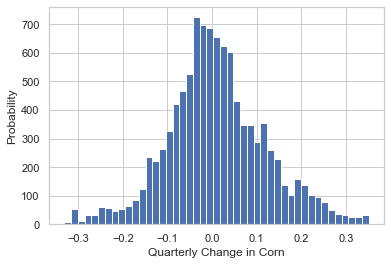

In [871]:
plt.hist(Q_corn_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Corn')
plt.ylabel('Probability')

Let's investigate how much we have scraped for reference. 

In [872]:
print('You have scrapped',round((((10617 - len(Q_corn_roll_pre))/10617)*100),2),'%. Lets check what another round would yield.')

You have scrapped 1.29 %. Lets check what another round would yield.


In [873]:
pre_corn_out = np.abs(stats.zscore(Q_corn_roll_pre, axis=0, nan_policy='omit'))
pre_corn_out_thresh = 3
print(np.where( pre_corn_out >= pre_corn_out_thresh ))
corn_list = np.where( pre_corn_out >= pre_corn_out_thresh )

(array([2172, 2173, 6778, 6779, 7035, 7036, 7037, 7038, 7039, 7040, 7041,
       7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7213, 7214, 7215,
       7216, 7717, 7718, 7719, 7720], dtype=int64),)


Let's check what values these are first.

In [874]:
for i in corn_list:
    print(Q_corn_roll_pre[i].sort_values())

Date
2008-12-12   -0.331309
2008-12-11   -0.329568
2009-01-07   -0.327629
2008-12-10   -0.326768
2008-04-18    0.343331
2008-03-13    0.343901
1988-09-28    0.344016
2007-03-08    0.344624
2008-03-14    0.346178
2010-11-02    0.346212
2008-03-26    0.347271
2008-03-25    0.347354
2010-12-06    0.347774
2008-03-17    0.347806
2006-12-13    0.347916
2008-03-27    0.347931
1988-08-05    0.347947
2008-04-17    0.348240
2008-03-20    0.348441
2008-03-28    0.348524
2008-03-24    0.348641
2008-03-31    0.349146
2010-11-03    0.349590
2008-03-18    0.349610
2008-03-19    0.349630
2008-04-01    0.350856
2010-12-03    0.351197
Name: Close, dtype: float64


In [875]:
Q_corn_roll_pre.drop(Q_corn_roll_pre.index[corn_list], inplace=True)

Text(0, 0.5, 'Probability')

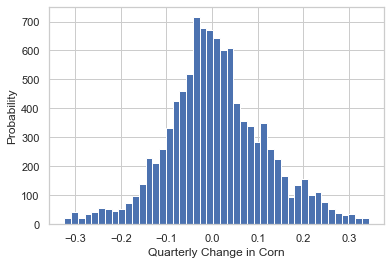

In [876]:
plt.hist(Q_corn_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Corn')
plt.ylabel('Probability')

In [877]:
print('You have scrapped',round((((10617 - len(Q_corn_roll_pre))/10617)*100),2),'%. So we will stop here.')

You have scrapped 1.54 %. So we will stop here.


Next `Wheat`

In [878]:
len(Q_wheat_roll_pre)

8188

Text(0, 0.5, 'Probability')

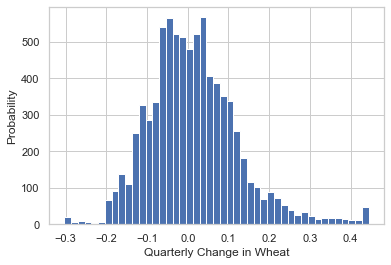

In [879]:
plt.hist(Q_wheat_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Wheat')
plt.ylabel('Probability')

In [880]:
pre_wheat_out = np.abs(stats.zscore(Q_wheat_roll_pre, axis=0, nan_policy='omit'))
pre_wheat_out_thresh = 3
print(np.where( pre_wheat_out >= pre_wheat_out_thresh ))
wheat_list = np.where( pre_wheat_out >= pre_wheat_out_thresh )

(array([4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531,
       4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542,
       4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553,
       4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564,
       4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575,
       4576, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 5321,
       5322, 5323, 5324, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332,
       5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343,
       5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354,
       5355, 5356, 5357, 5358, 5359, 5360, 5361, 5898, 5899, 5900, 5901,
       5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912,
       5913, 5914], dtype=int64),)


In [881]:
for i in wheat_list:
    print(Q_wheat_roll_pre[i].sort_values())

Date
2007-09-04    0.346500
2012-09-07    0.346621
2012-09-26    0.346844
2007-12-03    0.348915
2012-09-25    0.350467
                ...   
2010-09-30    0.443412
2007-10-25    0.444070
2007-10-24    0.444349
2010-10-01    0.444516
2007-10-23    0.444586
Name: Close, Length: 123, dtype: float64


Look's correct; let's remove.

In [882]:
Q_wheat_roll_pre.drop(Q_wheat_roll_pre.index[wheat_list], inplace=True)

Text(0, 0.5, 'Probability')

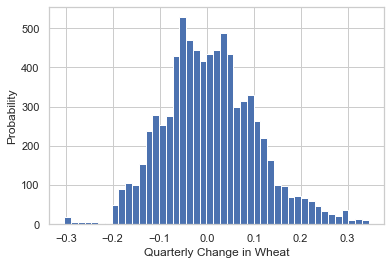

In [883]:
plt.hist(Q_wheat_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Wheat')
plt.ylabel('Probability')

This has oddly reversed visually but let's check how many we have scrapped.

In [884]:
print('You have scrapped',round((((8187 - len(Q_wheat_roll_pre))/8187)*100),2),'%. We may stop here unless the next round addresses those on negative side.')

You have scrapped 1.49 %. We may stop here unless the next round addresses those on negative side.


In [885]:
pre_wheat_out = np.abs(stats.zscore(Q_wheat_roll_pre, axis=0, nan_policy='omit'))
pre_wheat_out_thresh = 3
print(np.where( pre_wheat_out >= pre_wheat_out_thresh ))
wheat_list = np.where( pre_wheat_out >= pre_wheat_out_thresh )

(array([4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4784, 4785,
       4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796,
       4797, 4798, 4799, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258,
       5259, 5260, 5261, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794,
       5795, 5796, 5797, 5798], dtype=int64),)


In [886]:
for i in wheat_list:
    print(Q_wheat_roll_pre[i].sort_values())

Date
2008-12-29   -0.303035
2008-12-26   -0.302396
2008-12-30   -0.302269
2008-12-24   -0.302057
2008-12-23   -0.300689
2008-12-18   -0.300422
2008-12-16   -0.300196
2008-12-22   -0.299815
2008-12-17   -0.299808
2008-12-19   -0.299788
2008-12-31   -0.299369
2008-12-15   -0.298590
2008-12-12   -0.297515
2009-01-02   -0.297261
2009-01-05   -0.295339
2008-12-11   -0.295126
2007-08-28    0.308973
2010-11-04    0.311197
2012-10-04    0.312053
2007-12-07    0.312869
2012-08-30    0.313198
2010-09-06    0.314571
2007-08-29    0.316508
2012-10-03    0.317718
2007-12-06    0.319880
2010-11-03    0.320081
2012-08-31    0.320582
2010-09-07    0.322163
2007-08-30    0.323328
2012-10-02    0.324351
2010-11-02    0.326058
2012-09-04    0.327949
2007-12-05    0.328427
2007-08-31    0.329148
2010-09-08    0.329307
2012-10-01    0.330126
2010-11-01    0.331090
2012-09-30    0.334455
2012-09-05    0.334586
2007-12-04    0.335713
2010-10-31    0.336868
2010-09-09    0.337344
2012-09-28    0.338643
2007-0

In [887]:
Q_wheat_roll_pre.drop(Q_wheat_roll_pre.index[wheat_list], inplace=True)

Text(0, 0.5, 'Probability')

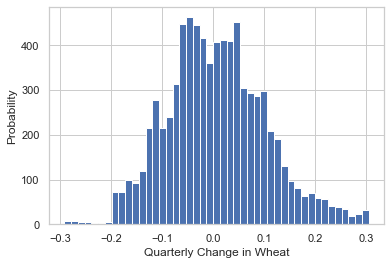

In [888]:
plt.hist(Q_wheat_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Wheat')
plt.ylabel('Probability')

In [889]:
print('You have scrapped',round((((8187 - len(Q_wheat_roll_pre))/8187)*100),2),'%. We will stop here as its above the comfort level.')

You have scrapped 2.08 %. We will stop here as its above the comfort level.


Next `Cattle`

In [890]:
len(Q_cattle_roll_pre)

10401

Text(0, 0.5, 'Probability')

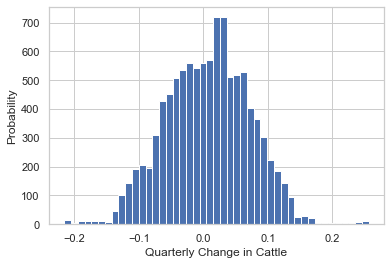

In [891]:
plt.hist(Q_cattle_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Cattle')
plt.ylabel('Probability')

In [892]:
pre_cat_out = np.abs(stats.zscore(Q_cattle_roll_pre, axis=0, nan_policy='omit'))
pre_cat_out_thresh = 3
print(np.where( pre_cat_out >= pre_cat_out_thresh ))
cat_list = np.where( pre_cat_out >= pre_cat_out_thresh )

(array([ 6016,  6017,  6018,  6019,  6020,  6021,  6022,  6023,  6024,
        6025,  6026,  6027,  6028,  6029,  6030,  6031,  6032,  6033,
        6034,  6035,  6036,  6037,  6038,  6039,  6040,  6041,  6042,
        6043,  6044,  6045,  6046,  6047,  6048,  6049,  6050, 10200,
       10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209,
       10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218,
       10219, 10220, 10221, 10222, 10223, 10224, 10225], dtype=int64),)


In [893]:
for i in cat_list:
    print(Q_cattle_roll_pre[i].sort_values())

Date
2020-06-08   -0.215529
2020-06-05   -0.215022
2020-06-09   -0.215019
2020-06-04   -0.213897
2020-06-10   -0.213834
                ...   
2003-12-10    0.254555
2003-12-04    0.255332
2003-12-09    0.255864
2003-12-05    0.256341
2003-12-08    0.256356
Name: Close, Length: 61, dtype: float64


Look's correct; let's remove.

In [894]:
Q_cattle_roll_pre.drop(Q_cattle_roll_pre.index[cat_list], inplace=True)

Text(0, 0.5, 'Probability')

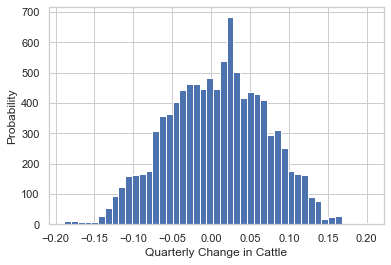

In [895]:
plt.hist(Q_cattle_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Cattle')
plt.ylabel('Probability')

Looks cleaner but let's check how much we have scrapped.

In [896]:
print('You have scrapped',round((((10400 - len(Q_cattle_roll_pre))/10400)*100),2),'%. Still room to go.')

You have scrapped 0.58 %. Still room to go.


In [897]:
pre_cat_out = np.abs(stats.zscore(Q_cattle_roll_pre, axis=0, nan_policy='omit'))
pre_cat_out_thresh = 3
print(np.where( pre_cat_out >= pre_cat_out_thresh ))
cat_list = np.where( pre_cat_out >= pre_cat_out_thresh )

(array([ 6015,  6016, 10163, 10164, 10165, 10166, 10167, 10168, 10169,
       10170], dtype=int64),)


In [898]:
for i in cat_list:
    print(Q_cattle_roll_pre[i].sort_values())

Date
2020-06-24   -0.188756
2020-06-26   -0.188696
2020-06-25   -0.188483
2020-05-15   -0.188113
2020-06-29   -0.188100
2020-06-30   -0.186815
2020-05-14   -0.185355
2020-07-01   -0.183904
2003-11-07    0.199963
2003-12-31    0.202520
Name: Close, dtype: float64


Modest. Let's continue.

In [899]:
Q_cattle_roll_pre.drop(Q_cattle_roll_pre.index[cat_list], inplace=True)

Text(0, 0.5, 'Probability')

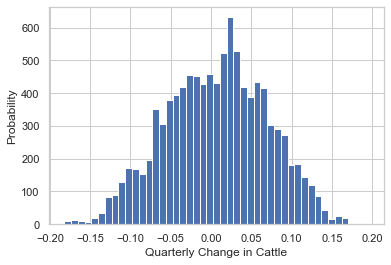

In [900]:
plt.hist(Q_cattle_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Cattle')
plt.ylabel('Probability')

In [901]:
print('You have scrapped',round((((10400 - len(Q_cattle_roll_pre))/10400)*100),2),'%. We will stop here.')

You have scrapped 0.67 %. We will stop here.


Next `Sugar`

In [902]:
len(Q_sugar_roll_pre)

10370

Text(0, 0.5, 'Probability')

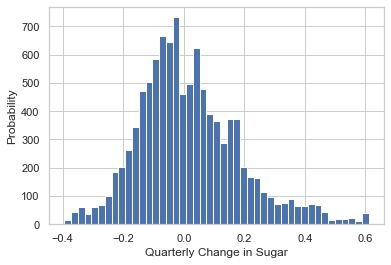

In [903]:
plt.hist(Q_sugar_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Sugar')
plt.ylabel('Probability')

In [904]:
pre_sug_out = np.abs(stats.zscore(Q_sugar_roll_pre, axis=0, nan_policy='omit'))
pre_sug_out_thresh = 3
print(np.where( pre_sug_out >= pre_sug_out_thresh ))
sug_list = np.where( pre_sug_out >= pre_sug_out_thresh )

(array([ 880,  881,  882,  883,  884,  885,  886,  887,  888,  889,  890,
        891,  892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
       1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446,
       1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457,
       1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468,
       1469, 1470, 1471, 1472, 1473, 5143, 5144, 5145, 5146, 5147, 5148,
       5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159,
       5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170,
       5171, 5172, 5173, 5174, 5175, 5176, 5177], dtype=int64),)


In [905]:
for i in sug_list:
    print(Q_sugar_roll_pre[i].sort_values())

Date
1983-07-22    0.520962
2000-09-21    0.523485
1983-08-22    0.525493
1983-07-25    0.527239
1985-12-12    0.529972
                ...   
2000-08-29    0.608495
2000-08-28    0.609763
2000-08-25    0.610063
2000-08-23    0.610204
2000-08-24    0.610680
Name: Close, Length: 95, dtype: float64


Entirely on the positive side; let's remove.

In [906]:
Q_sugar_roll_pre.drop(Q_sugar_roll_pre.index[sug_list], inplace=True)

Text(0, 0.5, 'Probability')

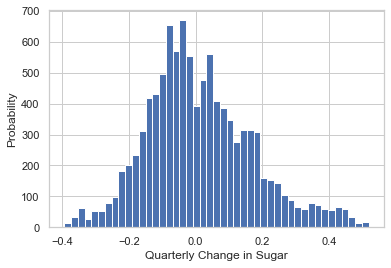

In [907]:
plt.hist(Q_sugar_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Sugar')
plt.ylabel('Probability')

Looks healthier; let's review how much we have scrapped.

In [908]:
print('You have scrapped',round((((10369 - len(Q_sugar_roll_pre))/10369)*100),2),'%. Lets review.')

You have scrapped 0.91 %. Lets review.


In [909]:
pre_sug_out = np.abs(stats.zscore(Q_sugar_roll_pre, axis=0, nan_policy='omit'))
pre_sug_out_thresh = 3
print(np.where( pre_sug_out >= pre_sug_out_thresh ))
sug_list = np.where( pre_sug_out >= pre_sug_out_thresh )

(array([ 874,  875,  876,  877,  878,  879,  880,  881,  882,  883, 1412,
       1413, 1414, 1415, 5080, 5081, 5082, 5083, 5084, 5085, 5086],
      dtype=int64),)


In [910]:
for i in sug_list:
    print(Q_sugar_roll_pre[i].sort_values())

Date
1983-07-14    0.492389
1983-08-26    0.492763
2000-09-27    0.492972
2000-07-31    0.496382
1983-07-15    0.497425
2000-09-26    0.500569
1985-10-17    0.501600
1985-12-16    0.502240
1983-08-25    0.502243
1983-07-18    0.502985
2000-08-01    0.503897
1983-07-19    0.508408
2000-09-25    0.508413
1983-08-24    0.512305
2000-08-02    0.512650
1983-07-20    0.513343
2000-09-22    0.515751
1985-10-18    0.516305
1983-07-21    0.516621
1985-12-13    0.517425
1983-08-23    0.519744
Name: Close, dtype: float64


Seems okay to remove.

In [911]:
Q_sugar_roll_pre.drop(Q_sugar_roll_pre.index[sug_list], inplace=True)

Text(0, 0.5, 'Probability')

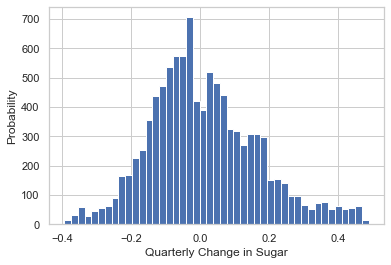

In [912]:
plt.hist(Q_sugar_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Sugar')
plt.ylabel('Probability')

In [913]:
print('You have scrapped',round((((10369 - len(Q_sugar_roll_pre))/10369)*100),2),'%. Lets review.')

You have scrapped 1.11 %. Lets review.


The current scrape is pushing the comfort boundaries; let's see what another round would yield.

In [914]:
pre_sug_out = np.abs(stats.zscore(Q_sugar_roll_pre, axis=0, nan_policy='omit'))
pre_sug_out_thresh = 3
print(np.where( pre_sug_out >= pre_sug_out_thresh ))
sug_list = np.where( pre_sug_out >= pre_sug_out_thresh )

(array([ 873, 1401, 1402, 5065, 5066], dtype=int64),)


In [915]:
for i in sug_list:
    print(Q_sugar_roll_pre[i].sort_values())

Date
2000-09-28    0.485778
1985-10-16    0.486191
1983-07-13    0.486287
1985-12-17    0.488767
2000-07-28    0.488937
Name: Close, dtype: float64


Makes sense & modest; let's scrape.

In [916]:
Q_sugar_roll_pre.drop(Q_sugar_roll_pre.index[sug_list], inplace=True)

Text(0, 0.5, 'Probability')

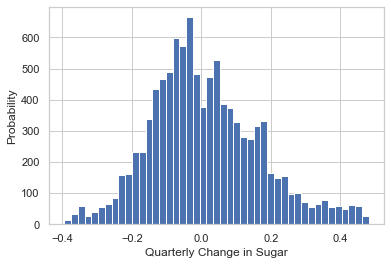

In [917]:
plt.hist(Q_sugar_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Sugar')
plt.ylabel('Probability')

In [918]:
print('You have scrapped',round((((10369 - len(Q_sugar_roll_pre))/10369)*100),2),'%. Lets review.')

You have scrapped 1.16 %. Lets review.


Looks healthy & we haven't scrapped a lot comparatively but let's review.

In [919]:
pre_sug_out = np.abs(stats.zscore(Q_sugar_roll_pre, axis=0, nan_policy='omit'))
pre_sug_out_thresh = 3
print(np.where( pre_sug_out >= pre_sug_out_thresh ))
sug_list = np.where( pre_sug_out >= pre_sug_out_thresh )

(array([], dtype=int64),)


We are done here; next `Lumber`

In [920]:
len(Q_lumber_roll_pre)

10385

Text(0, 0.5, 'Probability')

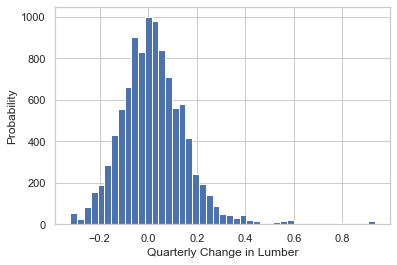

In [921]:
plt.hist(Q_lumber_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Lumber')
plt.ylabel('Probability')

This is easier to see.

In [922]:
pre_lum_out = np.abs(stats.zscore(Q_lumber_roll_pre, axis=0, nan_policy='omit'))
pre_lum_out_thresh = 3
print(np.where( pre_lum_out >= pre_lum_out_thresh ))
lum_list = np.where( pre_lum_out >= pre_lum_out_thresh )

(array([ 3336,  3337,  3338,  3339,  3340,  3341,  3342,  3343,  3344,
        3345,  3346,  3347,  3348,  3349,  3350,  3351,  3352,  3353,
        3354,  3355,  3356,  3357,  3358,  3359,  3360,  3361,  3362,
        3363,  3364,  3365,  3366,  3367,  3368,  3369,  3370,  3371,
        3372,  3373,  3374,  3375,  3376,  3377,  3378,  3379,  3380,
        3381, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257,
       10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266,
       10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275,
       10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284,
       10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293,
       10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302,
       10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311,
       10312, 10313, 10314, 10315, 10316], dtype=int64),)


In [923]:
for i in lum_list:
    print(Q_lumber_roll_pre[i].sort_values())

Date
1993-03-11    0.454636
1993-05-14    0.455428
2020-08-19    0.457003
2020-11-20    0.468989
1993-05-13    0.469812
                ...   
2020-09-29    0.930569
2020-09-30    0.931183
2020-10-05    0.931325
2020-10-02    0.932938
2020-10-01    0.933175
Name: Close, Length: 113, dtype: float64


Look's correct; let's remove.

In [924]:
Q_lumber_roll_pre.drop(Q_lumber_roll_pre.index[lum_list], inplace=True)

Text(0, 0.5, 'Probability')

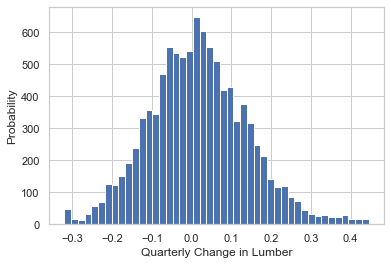

In [925]:
plt.hist(Q_lumber_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Lumber')
plt.ylabel('Probability')

Much healthier; let's review how much we scrapped.

In [926]:
print('You have scrapped',round((((10384 - len(Q_lumber_roll_pre))/10384)*100),2),'%. Lets review.')

You have scrapped 1.08 %. Lets review.


In [927]:
pre_lum_out = np.abs(stats.zscore(Q_lumber_roll_pre, axis=0, nan_policy='omit'))
pre_lum_out_thresh = 3
print(np.where( pre_lum_out >= pre_lum_out_thresh ))
lum_list = np.where( pre_lum_out >= pre_lum_out_thresh )

(array([ 3332,  3333,  3334,  3335,  3336,  3337,  3338,  3339,  3495,
        3496,  3497,  3498,  3499,  3500,  3501,  3502,  3503,  3504,
        3505,  3506,  3507,  3508,  3509,  3510,  3511,  3512,  3513,
        5376,  5377,  5378,  5379,  5380,  5381,  5382,  5383,  5384,
        5385,  5386,  5387,  5388,  5389,  5390,  5391,  5392,  5393,
        5394,  5395,  5396,  5397,  5398,  5399,  5400,  5401,  5402,
        5403,  5404,  5405,  5406, 10201, 10202, 10203, 10204, 10205,
       10206, 10271], dtype=int64),)


In [928]:
for i in lum_list:
    print(Q_lumber_roll_pre[i].sort_values())

Date
1994-01-26    0.387450
2001-07-30    0.388555
1993-12-31    0.388637
2020-08-14    0.388905
2021-03-02    0.390154
                ...   
2001-07-12    0.437611
2001-07-11    0.437705
1993-03-10    0.440003
1993-05-17    0.442156
2020-11-23    0.445578
Name: Close, Length: 65, dtype: float64


In [929]:
Q_lumber_roll_pre.drop(Q_lumber_roll_pre.index[lum_list], inplace=True)

Text(0, 0.5, 'Probability')

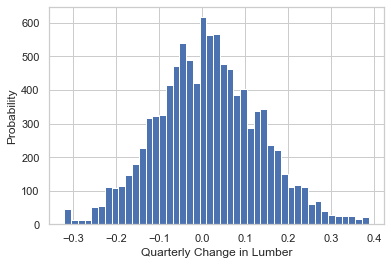

In [930]:
plt.hist(Q_lumber_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Lumber')
plt.ylabel('Probability')

In [931]:
print('You have scrapped',round((((10384 - len(Q_lumber_roll_pre))/10384)*100),2),'%. Lets review.')

You have scrapped 1.7 %. Lets review.


In [932]:
pre_lum_out = np.abs(stats.zscore(Q_lumber_roll_pre, axis=0, nan_policy='omit'))
pre_lum_out_thresh = 3
print(np.where( pre_lum_out >= pre_lum_out_thresh ))
lum_list = np.where( pre_lum_out >= pre_lum_out_thresh )

(array([ 3330,  3331,  3332,  3482,  3483,  3484,  3485,  3486,  3487,
        3488,  3489,  3490,  3491,  5347,  5348,  5349,  5350,  5351,
       10143, 10206], dtype=int64),)


In [933]:
for i in lum_list:
    print(Q_lumber_roll_pre[i].sort_values())

Date
1994-02-02    0.374254
1993-12-23    0.375165
1993-03-03    0.375318
2001-08-02    0.376213
2021-03-01    0.376506
2020-11-27    0.376721
1994-02-01    0.376842
2001-06-13    0.377438
1994-01-31    0.379111
1993-12-27    0.380226
2001-08-01    0.380509
1994-01-28    0.380845
1994-01-27    0.383269
1993-12-28    0.383423
1993-05-21    0.384531
2001-07-31    0.384697
1993-12-29    0.385644
2001-06-14    0.386288
1993-12-30    0.386901
1993-03-04    0.386955
Name: Close, dtype: float64


Although I may understand we have scrapped 1.7% & thus we will hold for now.

Next `Lean Hogs`

In [934]:
len(Q_leanhogs_roll_pre)

10415

Text(0, 0.5, 'Probability')

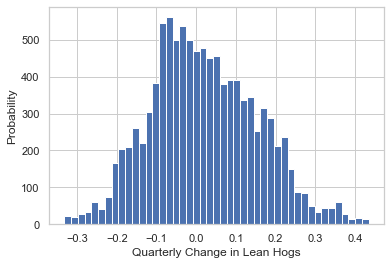

In [935]:
plt.hist(Q_leanhogs_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Lean Hogs')
plt.ylabel('Probability')

In [936]:
pre_hog_out = np.abs(stats.zscore(Q_leanhogs_roll_pre, axis=0, nan_policy='omit'))
pre_hog_out_thresh = 3
print(np.where( pre_hog_out >= pre_hog_out_thresh ))
hog_list = np.where( pre_hog_out >= pre_hog_out_thresh )

(array([4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896],
      dtype=int64),)


In [937]:
for i in hog_list:
    print(Q_leanhogs_roll_pre[i].sort_values())

Date
1999-05-27    0.424474
1999-05-13    0.424683
1999-05-14    0.426439
1999-05-26    0.427657
1999-05-17    0.428871
1999-05-25    0.430024
1999-05-18    0.432179
1999-05-24    0.432637
1999-05-21    0.433742
1999-05-20    0.433874
1999-05-19    0.434222
Name: Close, dtype: float64


A bit of a modest one ( comparatively ); let's remove.

In [938]:
Q_leanhogs_roll_pre.drop(Q_leanhogs_roll_pre.index[hog_list], inplace=True)

Text(0, 0.5, 'Probability')

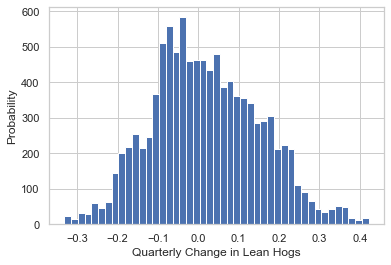

In [939]:
plt.hist(Q_leanhogs_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Lean Hogs')
plt.ylabel('Probability')

In [940]:
pre_hog_out = np.abs(stats.zscore(Q_leanhogs_roll_pre, axis=0, nan_policy='omit'))
pre_hog_out_thresh = 3
print(np.where( pre_hog_out >= pre_hog_out_thresh ))
hog_list = np.where( pre_hog_out >= pre_hog_out_thresh )

(array([4885, 4886], dtype=int64),)


In [941]:
for i in hog_list:
    print(Q_leanhogs_roll_pre[i].sort_values())

Date
1999-05-12    0.421346
1999-05-28    0.422231
Name: Close, dtype: float64


In [942]:
Q_leanhogs_roll_pre.drop(Q_leanhogs_roll_pre.index[hog_list], inplace=True)

Text(0, 0.5, 'Probability')

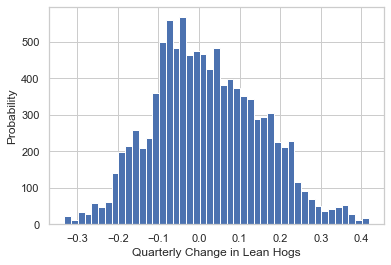

In [943]:
plt.hist(Q_leanhogs_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Lean Hogs')
plt.ylabel('Probability')

Look's reasonable but let's check.

In [944]:
pre_hog_out = np.abs(stats.zscore(Q_leanhogs_roll_pre, axis=0, nan_policy='omit'))
pre_hog_out_thresh = 3
print(np.where( pre_hog_out >= pre_hog_out_thresh ))
hog_list = np.where( pre_hog_out >= pre_hog_out_thresh )

(array([], dtype=int64),)


In [945]:
print('You have scrapped',round((((10414 - len(Q_leanhogs_roll_pre))/10414)*100),2),'% but we are complete here.')

You have scrapped 0.12 % but we are complete here.


Next `Initial Jobless Claims`

In [946]:
len(Q_intjobs_roll_pre)

2825

Text(0, 0.5, 'Probability')

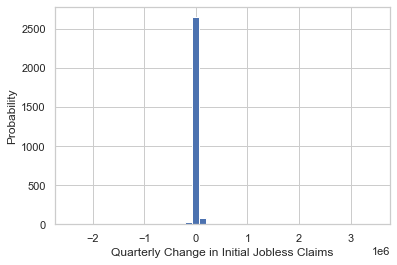

In [947]:
plt.hist(Q_intjobs_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Initial Jobless Claims')
plt.ylabel('Probability')

In [948]:
# pre_ijc_out = np.abs(stats.zscore(Q_caputil_roll_pre, axis=0, nan_policy='omit'))
# pre_ijc_out_thresh = 3
# print(np.where( pre_ijc_out >= pre_ijc_out_thresh ))
# ijc_list = np.where( pre_ijc_out >= pre_ijc_out_thresh )

In [949]:
# for i in ijc_list:
#    print(Q_caputil_roll_pre[i].sort_values())

Look's correct; let's remove.

In [950]:
# Q_caputil_roll_pre.drop(Q_caputil_roll_pre.index[ijc_list], inplace=True)

Next `Capacity Utilization`

In [951]:
len(Q_caputil_roll_pre)

649

Text(0, 0.5, 'Probability')

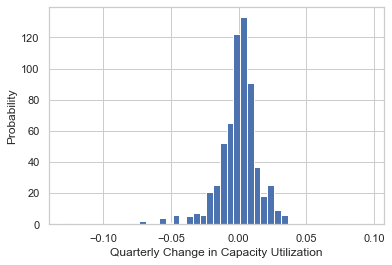

In [952]:
plt.hist(Q_caputil_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Capacity Utilization')
plt.ylabel('Probability')

In [953]:
pre_caputil_out = np.abs(stats.zscore(Q_caputil_roll_pre, axis=0, nan_policy='omit'))
pre_caputil_out_thresh = 3
print(np.where( pre_caputil_out >= pre_caputil_out_thresh ))
caputil_list = np.where( pre_caputil_out >= pre_caputil_out_thresh )

(array([ 96,  97,  98,  99, 162, 502, 505, 506, 639, 640, 641, 643, 644,
       645], dtype=int64),)


In [954]:
for i in caputil_list:
    print(Q_caputil_roll_pre[i].sort_values())

2020-06-01   -0.128528
2020-05-01   -0.122899
1975-02-01   -0.078448
2020-04-01   -0.073183
1975-03-01   -0.070410
1975-01-01   -0.067181
2009-03-01   -0.059059
2009-02-01   -0.054713
1980-07-01   -0.054691
1975-04-01   -0.054683
2008-11-01   -0.054670
2020-08-01    0.057466
2020-10-01    0.063701
2020-09-01    0.095945
dtype: float64


In [955]:
print('This would yield a',round((((14)/649)*100),2),'% scrape which will do.')

This would yield a 2.16 % scrape which will do.


In [956]:
Q_caputil_roll_pre.drop(Q_caputil_roll_pre.index[caputil_list], inplace=True)

Text(0, 0.5, 'Probability')

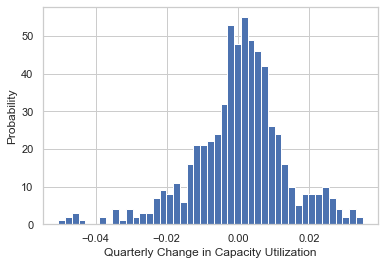

In [957]:
plt.hist(Q_caputil_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Capacity Utilization')
plt.ylabel('Probability')

Much healthier; let's see what another round looks like.

In [958]:
pre_caputil_out = np.abs(stats.zscore(Q_caputil_roll_pre, axis=0, nan_policy='omit'))
pre_caputil_out_thresh = 3
print(np.where( pre_caputil_out >= pre_caputil_out_thresh ))
caputil_list = np.where( pre_caputil_out >= pre_caputil_out_thresh )

(array([ 95, 157, 158, 496, 497, 498, 499], dtype=int64),)


In [959]:
for i in caputil_list:
    print(Q_caputil_roll_pre[i].sort_values())

2009-01-01   -0.050524
1980-06-01   -0.047983
2009-04-01   -0.047479
2008-10-01   -0.046025
1974-12-01   -0.045251
2008-12-01   -0.045073
1980-08-01   -0.044510
dtype: float64


In [960]:
print('This scrape would yield',round((((649 - (len(Q_caputil_roll_pre)-2))/649)*100),2),'% so it will be our final.')

This scrape would yield 2.47 % so it will be our final.


In [961]:
Q_caputil_roll_pre.drop(Q_caputil_roll_pre.index[caputil_list], inplace=True)

Next `Wages CPI`

In [962]:
len(Q_wages_roll_pre)

889

Text(0, 0.5, 'Probability')

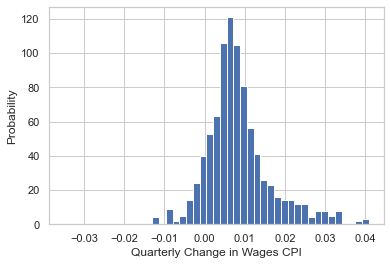

In [963]:
plt.hist(Q_wages_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Wages CPI')
plt.ylabel('Probability')

In [964]:
pre_wagcpi_out = np.abs(stats.zscore(Q_wages_roll_pre, axis=0, nan_policy='omit'))
pre_wagcpi_out_thresh = 3
print(np.where( pre_wagcpi_out >= pre_wagcpi_out_thresh ))
wagcpi_list = np.where( pre_wagcpi_out >= pre_wagcpi_out_thresh )

(array([ 49,  50,  51, 334, 389, 390, 397, 398, 399, 400, 401, 743, 744,
       745], dtype=int64),)


In [965]:
for i in wagcpi_list:
    print(Q_wages_roll_pre[i])

1951-02-01    0.037467
1951-03-01    0.040827
1951-04-01    0.035836
1974-11-01    0.033567
1979-06-01    0.033539
1979-07-01    0.033647
1980-02-01    0.035188
1980-03-01    0.039196
1980-04-01    0.039181
1980-05-01    0.038299
1980-06-01    0.033995
2008-12-01   -0.029253
2009-01-01   -0.034864
2009-02-01   -0.025147
dtype: float64


Although the vast majority are outside our eventual range which won't have any impact on our `Inflation` comparison, three are inside ( the three negative ones ) & may yield a repeated value. We now remove the middle of the three ( `2009-01-01` ) to provide some fluctuation in the eventual comparison.

In [966]:
wagecpi_drop = [744]
Q_wages_roll_pre.drop(Q_wages_roll_pre.index[wagecpi_drop], inplace=True)

In [967]:
# to confirm it was dropped
for i in wagcpi_list:
    print(Q_wages_roll_pre[i])

1951-02-01    0.037467
1951-03-01    0.040827
1951-04-01    0.035836
1974-11-01    0.033567
1979-06-01    0.033539
1979-07-01    0.033647
1980-02-01    0.035188
1980-03-01    0.039196
1980-04-01    0.039181
1980-05-01    0.038299
1980-06-01    0.033995
2008-12-01   -0.029253
2009-02-01   -0.025147
2009-03-01   -0.008872
dtype: float64


Confirmed we are complete.

Next `Unemployment Rate`

In [968]:
len(Q_unrate_roll_pre)

877

Text(0, 0.5, 'Probability')

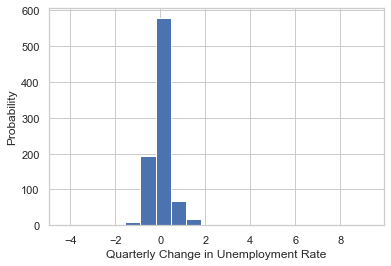

In [969]:
plt.hist(Q_unrate_roll_pre, bins=20)
plt.xlabel('Quarterly Change in Unemployment Rate')
plt.ylabel('Probability')

I am interested to see where these are.

In [970]:
pre_unem_out = np.abs(stats.zscore(Q_unrate_roll_pre, axis=0, nan_policy='omit'))
pre_unem_out_thresh = 3
print(np.where( pre_unem_out >= pre_unem_out_thresh ))
unem_list = np.where( pre_unem_out >= pre_unem_out_thresh )

(array([867, 868, 869, 870, 872, 873, 874, 875], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))


In [971]:
# for i in unem_list:
#     print(Q_unrate_roll_pre[i].sort_values())

Next `PMI Composite Index`; welcome!

In [972]:
len(Q_comppmi_roll_pre)

877

Text(0, 0.5, 'Probability')

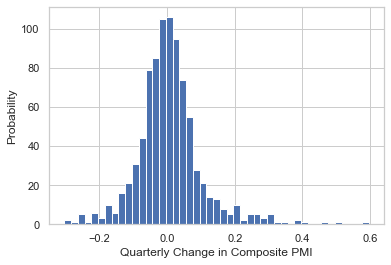

In [973]:
plt.hist(Q_comppmi_roll_pre, bins=45)
plt.xlabel('Quarterly Change in Composite PMI')
plt.ylabel('Probability')

In [974]:
pre_pmi_out = np.abs(stats.zscore(Q_comppmi_roll_pre, axis=0, nan_policy='omit'))
pre_pmi_out_thresh = 3
print(np.where( pre_pmi_out >= pre_pmi_out_thresh ))
pmi_list = np.where( pre_pmi_out >= pre_pmi_out_thresh )

(array([ 20,  21,  22,  55,  56,  57, 126, 127, 324, 330, 331, 389, 392,
       393, 394, 395], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))


In [976]:
# There's an error which I will resolve once I have a better understanding of the final results for the others.

#for i in pmi_list:
#    print(Q_comppmi_roll_pre[i].sort_values())

Let's correct; let's remove.

In [977]:
# Q_comppmi_roll_pre.drop(Q_comppmi_roll_pre.index[pmi_list], inplace=True)

Next `GDP`

In [978]:
len(Q_gdp_pre)

300

Text(0, 0.5, 'Probability')

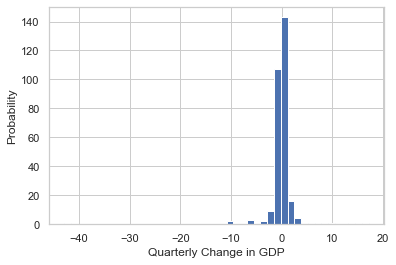

In [979]:
plt.hist(Q_gdp_pre, bins=45)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Probability')

Looks as though there may be some outliers.

In [980]:
pre_gdp_out = np.abs(stats.zscore(Q_gdp_pre, axis=0, nan_policy='omit'))
pre_gdp_out_thresh = 3
print(np.where( pre_gdp_out >= pre_gdp_out_thresh ))
gdp_list = np.where( pre_gdp_out >= pre_gdp_out_thresh )

(array([100, 145, 223, 251, 273, 297], dtype=int64),)


In [981]:
for i in gdp_list:
    print(Q_gdp_pre[i].sort_values())

2001-10-01   -42.890857
2008-10-01   -10.301274
1982-04-01    -9.868135
2020-04-01    10.052892
2014-04-01    14.311553
1971-01-01    17.218520
dtype: float64


It's ~2% of the dataset but those are incorrect. Of the 6 identified, 4 of them would be in our data set once `Inflation` is incorporated but they are years a part; let's remove.

In [982]:
Q_gdp_pre.drop(Q_gdp_pre.index[gdp_list], inplace=True)

Text(0, 0.5, 'Probability')

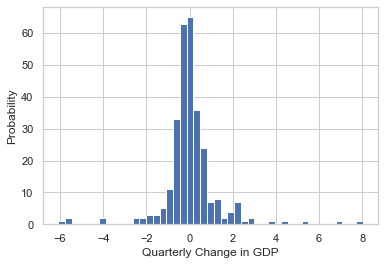

In [983]:
plt.hist(Q_gdp_pre, bins=45)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Probability')

Better but still not suitable. Let's investigate.

In [984]:
pre_gdp_out = np.abs(stats.zscore(Q_gdp_pre, axis=0, nan_policy='omit'))
pre_gdp_out_thresh = 3
print(np.where( pre_gdp_out >= pre_gdp_out_thresh ))
gdp_list = np.where( pre_gdp_out >= pre_gdp_out_thresh )

(array([ 12,  16,  26,  31,  34,  58, 137, 178, 246], dtype=int64),)


In [985]:
for i in gdp_list:
    print(Q_gdp_pre[i].sort_values())

2008-04-01   -6.084807
1950-01-01   -5.547420
1949-01-01   -5.538247
1991-01-01   -3.937267
1960-07-01   -3.893565
1952-07-01    4.494745
1954-07-01    5.269591
1980-07-01    6.852497
1953-10-01    8.011566
dtype: float64


There's only one which would be in our data set once `Inflation` is incorporated ( `2008-04-01` ) & it's seperated from previous scrape so let's scrape them all.

In [986]:
Q_gdp_pre.drop(Q_gdp_pre.index[gdp_list], inplace=True)

Text(0, 0.5, 'Probability')

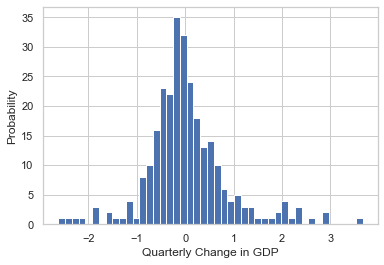

In [987]:
plt.hist(Q_gdp_pre, bins=45)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Probability')

In [988]:
pre_gdp_out = np.abs(stats.zscore(Q_gdp_pre, axis=0, nan_policy='omit'))
pre_gdp_out_thresh = 3
print(np.where( pre_gdp_out >= pre_gdp_out_thresh ))
gdp_list = np.where( pre_gdp_out >= pre_gdp_out_thresh )

(array([ 51,  70, 211, 241, 248], dtype=int64),)


In [989]:
for i in gdp_list:
    print(Q_gdp_pre[i].sort_values())

2009-07-01   -2.622610
2001-04-01    2.678712
1965-01-01    2.841861
1960-01-01    2.912852
2011-04-01    3.662486
dtype: float64


Three more in what our `Inflation` data set would be & they don't align with the previous round so we will scrape.

In [990]:
Q_gdp_pre.drop(Q_gdp_pre.index[gdp_list], inplace=True)

Text(0, 0.5, 'Probability')

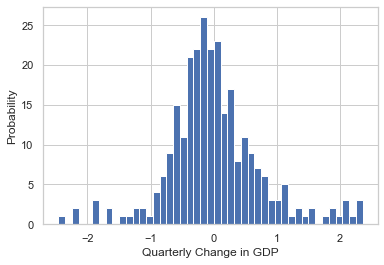

In [991]:
plt.hist(Q_gdp_pre, bins=45)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Probability')

In [992]:
pre_gdp_out = np.abs(stats.zscore(Q_gdp_pre, axis=0, nan_policy='omit'))
pre_gdp_out_thresh = 3
print(np.where( pre_gdp_out >= pre_gdp_out_thresh ))
gdp_list = np.where( pre_gdp_out >= pre_gdp_out_thresh )

(array([ 14,  29,  41,  78, 120], dtype=int64),)


In [993]:
for i in gdp_list:
    print(Q_gdp_pre[i].sort_values())

1949-10-01   -2.462452
1954-04-01   -2.243614
1978-04-01    2.289715
1957-07-01    2.307872
1967-07-01    2.357132
dtype: float64


None of these fall within our intended `Inflation` data set so we will scrape.

In [994]:
Q_gdp_pre.drop(Q_gdp_pre.index[gdp_list], inplace=True)

Text(0, 0.5, 'Probability')

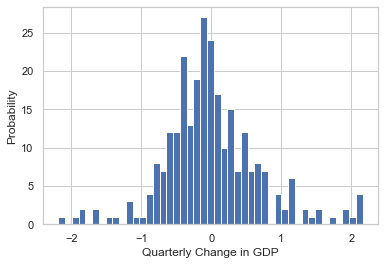

In [995]:
plt.hist(Q_gdp_pre, bins=45)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Probability')

In [996]:
pre_gdp_out = np.abs(stats.zscore(Q_gdp_pre, axis=0, nan_policy='omit'))
pre_gdp_out_thresh = 3
print(np.where( pre_gdp_out >= pre_gdp_out_thresh ))
gdp_list = np.where( pre_gdp_out >= pre_gdp_out_thresh )

(array([ 42,  49,  91, 233, 247], dtype=int64),)


In [997]:
for i in gdp_list:
    print(Q_gdp_pre[i].sort_values())

1960-10-01   -2.185271
2009-10-01    2.064500
2013-07-01    2.072454
1958-07-01    2.094332
1972-01-01    2.159921
dtype: float64


Two of these fall into the intended `Inflation` data set but I am comfortable with those numbers. We will stop here.

Next & final, `M2 Velocity`

In [998]:
len(Q_m2_velo_pre)

248

In [999]:
# plt.hist(Q_m2_velo_pre, bins=45, axis=0, nan_policy='omit')
# plt.xlabel('Quarterly Change in M2 Velocity')
# plt.ylabel('Probability')

# 1.4.4.2 Putting the above together with Inflation

As of now you have 2 catagories; one is `Complete` & the other is `Incomplete` as of `1 Mar 2021`. 

Listed below are the `Incomplete`

In [1000]:
# Q_heatoil_roll_pre
# Q_soybeans_roll_pre
# Q_copper_roll_pre
# Q_m2_velo_pre
# Q_comppmi_roll_pre
# Q_unrate_roll_pre
# Q_intjobs_roll_pre

Listed below are the `Complete`.

In [1001]:
# Q_usd_index_roll_pre
# Q_wti_roll_pre

# Q_corn_roll_pre
# Q_wheat_roll_pre
# Q_cattle_roll_pre
# Q_sugar_roll_pre
# Q_lumber_roll_pre
# Q_leanhogs_roll_pre

# Q_caputil_roll_pre
# Q_wages_roll_pre

# Q_cpi

# Q_gdp_pre


Let's begin by concating the `Complete` together first with `Inflation` to get rough idea as to how it may look.

In [1002]:
# Building out the variables first with a roll & forward fill
QonQ_vars_roll_pre = pd.concat([Q_wages_roll_pre,Q_wti_roll_pre,Q_corn_roll_pre,Q_wheat_roll_pre,Q_cattle_roll_pre,
                            Q_leanhogs_roll_pre,Q_sugar_roll_pre,Q_lumber_roll_pre,
                            Q_caputil_roll_pre,Q_gdp_pre,Q_usd_index_roll_pre
                      ],
                      axis = 1, ignore_index=False)

QonQ_vars_roll_pre.columns= ['Wages CPI','WTI','Corn','Wheat','Cattle','Lean Hogs','Sugar','Lumber',
                         'Capacity Utilization','GDP','USD Index'
                   ]

QonQ_vars_roll_pre.index.names = ["Date"]
QonQ_vars_roll_pre = QonQ_vars_roll_pre.fillna(method='ffill')

# vars_mnth.tail()

In [1003]:
QonQ_vars_roll_pre.tail()

Wages CPI       WTI      Corn     Wheat    Cattle  Lean Hogs  \
Date                                                                       
2021-02-25   0.006251  0.287205  0.266710  0.077596  0.056120   0.069813   
2021-02-26   0.006251  0.294725  0.267969  0.079236  0.056126   0.071797   
2021-02-28   0.006251  0.294725  0.267969  0.081492  0.056126   0.071797   
2021-03-01   0.006251  0.301412  0.269512  0.083788  0.056419   0.073515   
2021-03-02   0.006251  0.301412  0.270518  0.085158  0.056700   0.075349   

               Sugar    Lumber  Capacity Utilization       GDP  USD Index  
Date                                                                       
2021-02-25  0.153654  0.352580              0.028146 -0.822509  -0.028430  
2021-02-26  0.153711  0.364326              0.028146 -0.822509  -0.028476  
2021-02-28  0.153711  0.364326              0.028146 -0.822509  -0.028476  
2021-03-01  0.152278  0.376506              0.028146 -0.822509  -0.028458  
2021-03-02  0.150827  0.376506              0.028146 -0.822509  -0.028458

In [1004]:
# Putting them together with inflation
QonQ_main_cpi_pre = Q_cpi.merge(QonQ_vars_roll_pre, how='left', on='Date')

# QonQ_main_cpi_pre = QonQ_main_cpi_past[QonQ_main_cpi_past.index.dayofweek < 5]

QonQ_main_cpi_pre.columns = ['Inflation','Wages CPI','WTI','Corn','Wheat','Cattle','Lean Hogs','Sugar','Lumber',
                         'Capacity Utilization','GDP','USD Index']

QonQ_main_cpi_pre = QonQ_main_cpi_pre.dropna()

We will undergo the same process as before in 1.3.4.

In [1005]:
QonQ_main_cpi_pre.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 1990-07-31 to 2020-09-30
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Inflation             266 non-null    float64
 1   Wages CPI             266 non-null    float64
 2   WTI                   266 non-null    float64
 3   Corn                  266 non-null    float64
 4   Wheat                 266 non-null    float64
 5   Cattle                266 non-null    float64
 6   Lean Hogs             266 non-null    float64
 7   Sugar                 266 non-null    float64
 8   Lumber                266 non-null    float64
 9   Capacity Utilization  266 non-null    float64
 10  GDP                   266 non-null    float64
 11  USD Index             266 non-null    float64
dtypes: float64(12)
memory usage: 27.0 KB


In [1006]:
QonQ_main_cpi_pre.corr(method='pearson')

Inflation  Wages CPI       WTI      Corn     Wheat  \
Inflation              1.000000   0.400352  0.239716  0.059933 -0.053326   
Wages CPI              0.400352   1.000000  0.672503  0.147434  0.051780   
WTI                    0.239716   0.672503  1.000000  0.046641 -0.033838   
Corn                   0.059933   0.147434  0.046641  1.000000  0.598298   
Wheat                 -0.053326   0.051780 -0.033838  0.598298  1.000000   
Cattle                 0.197409   0.186175  0.098767  0.009387  0.017512   
Lean Hogs              0.215901   0.169267  0.233720  0.183379 -0.123106   
Sugar                 -0.000066   0.189016  0.178700  0.120051  0.127240   
Lumber                 0.049883   0.080750  0.185514  0.123952  0.026505   
Capacity Utilization   0.033532   0.114969  0.153260  0.106608  0.150229   
GDP                    0.069434  -0.103722 -0.083542 -0.035440  0.022767   
USD Index             -0.009211  -0.394378 -0.399965 -0.128251 -0.133360   

                        Cattle  Lean Hogs     Sugar    Lumber  \
Inflation             0.197409   0.215901 -0.000066  0.049883   
Wages CPI             0.186175   0.169267  0.189016  0.080750   
WTI                   0.098767   0.233720  0.178700  0.185514   
Corn                  0.009387   0.183379  0.120051  0.123952   
Wheat                 0.017512  -0.123106  0.127240  0.026505   
Cattle                1.000000   0.095293  0.062184  0.220984   
Lean Hogs             0.095293   1.000000 -0.134874  0.251825   
Sugar                 0.062184  -0.134874  1.000000  0.032767   
Lumber                0.220984   0.251825  0.032767  1.000000   
Capacity Utilization  0.227306   0.135005  0.118949  0.108836   
GDP                   0.071207   0.111913  0.003899  0.055405   
USD Index            -0.027766   0.059972 -0.130848  0.084342   

                      Capacity Utilization       GDP  USD Index  
Inflation                         0.033532  0.069434  -0.009211  
Wages CPI                         0.114969 -0.103722  -0.394378  
WTI                               0.153260 -0.083542  -0.399965  
Corn                              0.106608 -0.035440  -0.128251  
Wheat                             0.150229  0.022767  -0.133360  
Cattle                            0.227306  0.071207  -0.027766  
Lean Hogs                         0.135005  0.111913   0.059972  
Sugar                             0.118949  0.003899  -0.130848  
Lumber                            0.108836  0.055405   0.084342  
Capacity Utilization              1.000000  0.335346  -0.067986  
GDP                               0.335346  1.000000   0.138572  
USD Index                        -0.067986  0.138572   1.000000

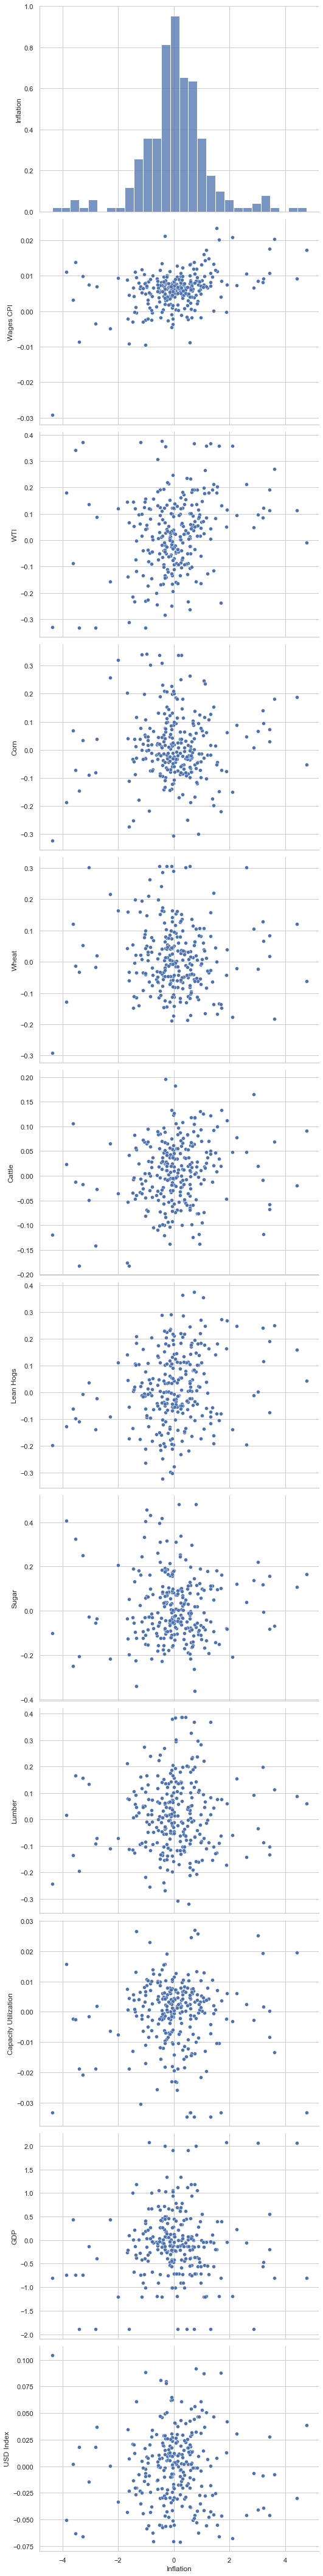

In [1007]:
sns.pairplot(QonQ_main_cpi_pre,
            y_vars = ['Inflation','Wages CPI','WTI','Corn','Wheat','Cattle','Lean Hogs','Sugar','Lumber',
                         'Capacity Utilization','GDP','USD Index'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

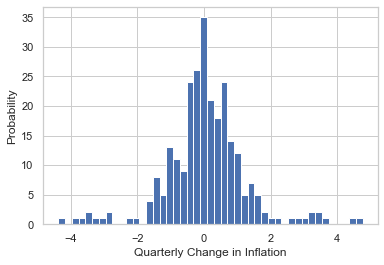

In [1008]:
plt.hist(QonQ_main_cpi_pre['Inflation'], bins=45)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

In [1009]:
pre_cpi_out = np.abs(stats.zscore(QonQ_main_cpi_pre['Inflation'], axis=0, nan_policy='omit'))
pre_cpi_out_thresh = 3
print(np.where( pre_cpi_out >= pre_cpi_out_thresh ))
cpi_list = np.where( pre_cpi_out >= pre_cpi_out_thresh )

(array([137, 154, 156, 162, 164], dtype=int64),)


In [1010]:
for i in cpi_list:
    print(QonQ_main_cpi_pre['Inflation'][i].sort_values())

Date
2008-12-31   -4.371
2009-09-30   -3.866
2006-10-31   -3.611
2009-12-31    4.414
2008-09-30    4.761
Name: Inflation, dtype: float64


None appear directly next to each other so let's proceed.

In [1011]:
QonQ_main_cpi_pre.drop(QonQ_main_cpi_pre.index[cpi_list], inplace=True)

Text(0, 0.5, 'Probability')

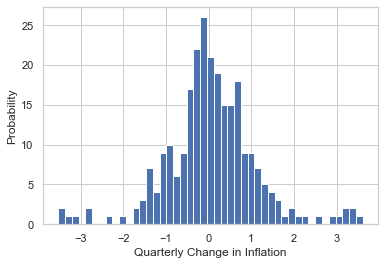

In [1012]:
plt.hist(QonQ_main_cpi_pre['Inflation'], bins=45)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

In [1013]:
print('Of the original',round((((266 - len(QonQ_main_cpi_pre))/266)*100),2),'% have been scrapped. Lets continue.')

Of the original 1.88 % have been scrapped. Lets continue.


In [1014]:
pre_cpi_out = np.abs(stats.zscore(QonQ_main_cpi_pre['Inflation'], axis=0, nan_policy='omit'))
pre_cpi_out_thresh = 3
print(np.where( pre_cpi_out >= pre_cpi_out_thresh ))
cpi_list = np.where( pre_cpi_out >= pre_cpi_out_thresh )

(array([127, 135, 152, 157, 158, 256], dtype=int64),)


In [1015]:
for i in cpi_list:
    print(QonQ_main_cpi_pre['Inflation'][i].sort_values())

Date
2009-08-31   -3.525
2020-05-31   -3.409
2009-07-31   -3.274
2005-09-30    3.428
2006-07-31    3.439
2008-07-31    3.608
Name: Inflation, dtype: float64


While these appear to be outliers, let's check to see what scraping these result in percent of the total. 

In [1016]:
print('Of the original',round((((266 - (len(QonQ_main_cpi_pre)-6))/266)*100),2),'% would have been scrapped. Not beautiful but lets see.')

Of the original 4.14 % would have been scrapped. Not beautiful but lets see.


In [1017]:
QonQ_main_cpi_pre.drop(QonQ_main_cpi_pre.index[cpi_list], inplace=True)

Text(0, 0.5, 'Probability')

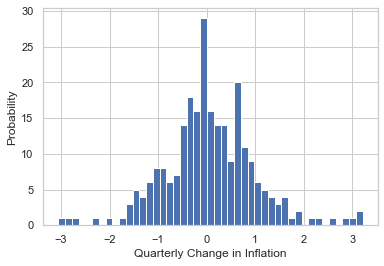

In [1018]:
plt.hist(QonQ_main_cpi_pre['Inflation'], bins=45)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

In [1019]:
pre_cpi_out = np.abs(stats.zscore(QonQ_main_cpi_pre['Inflation'], axis=0, nan_policy='omit'))
pre_cpi_out_thresh = 3
print(np.where( pre_cpi_out >= pre_cpi_out_thresh ))
cpi_list = np.where( pre_cpi_out >= pre_cpi_out_thresh )

(array([125, 133, 141, 154, 155, 248, 250], dtype=int64),)


In [1020]:
for i in cpi_list:
    print(QonQ_main_cpi_pre['Inflation'][i])

Date
2005-06-30   -2.775
2006-06-30    3.213
2007-08-31   -3.057
2009-11-30    3.017
2010-01-31    3.199
2020-01-31    2.881
2020-04-30   -2.815
Name: Inflation, dtype: float64


In [1021]:
print('Too redefine the boundaries of ±3%,',round((((266 - (len(QonQ_main_cpi_pre)-4))/266)*100),2),'% would be scrapped. To remain consistent, we shall scrape accordingly.')

Too redefine the boundaries of ±3%, 5.64 % would be scrapped. To remain consistent, we shall scrape accordingly.


In [1022]:
cpi_scr = [ 133, 141, 154, 155 ]
QonQ_main_cpi_pre.drop(QonQ_main_cpi_pre.index[cpi_scr], inplace=True)

Last check.

Text(0, 0.5, 'Probability')

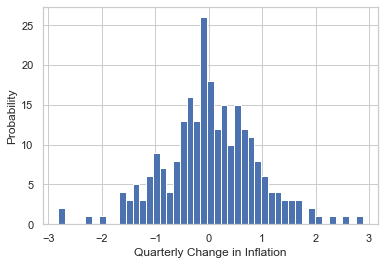

In [1023]:
plt.hist(QonQ_main_cpi_pre['Inflation'], bins=45)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

In [1024]:
QonQ_main_cpi_pre.corr(method='pearson')

Inflation  Wages CPI       WTI      Corn     Wheat  \
Inflation              1.000000   0.331023  0.277517 -0.121279 -0.118115   
Wages CPI              0.331023   1.000000  0.659509  0.065850 -0.003436   
WTI                    0.277517   0.659509  1.000000  0.002290 -0.069672   
Corn                  -0.121279   0.065850  0.002290  1.000000  0.613403   
Wheat                 -0.118115  -0.003436 -0.069672  0.613403  1.000000   
Cattle                 0.245804   0.139642  0.082849 -0.024123  0.017489   
Lean Hogs              0.133321   0.126120  0.223055  0.138687 -0.162204   
Sugar                 -0.025362   0.139914  0.118495  0.137364  0.149945   
Lumber                 0.036955   0.009367  0.143692  0.103447  0.000278   
Capacity Utilization  -0.050763   0.070458  0.136011  0.063303  0.114242   
GDP                   -0.050796  -0.176051 -0.117186 -0.091911 -0.013049   
USD Index              0.006862  -0.364924 -0.355048 -0.099900 -0.102081   

                        Cattle  Lean Hogs     Sugar    Lumber  \
Inflation             0.245804   0.133321 -0.025362  0.036955   
Wages CPI             0.139642   0.126120  0.139914  0.009367   
WTI                   0.082849   0.223055  0.118495  0.143692   
Corn                 -0.024123   0.138687  0.137364  0.103447   
Wheat                 0.017489  -0.162204  0.149945  0.000278   
Cattle                1.000000   0.087331  0.056318  0.201449   
Lean Hogs             0.087331   1.000000 -0.138371  0.238649   
Sugar                 0.056318  -0.138371  1.000000 -0.003335   
Lumber                0.201449   0.238649 -0.003335  1.000000   
Capacity Utilization  0.231360   0.117959  0.100959  0.090235   
GDP                   0.044913   0.106630 -0.010246  0.055995   
USD Index            -0.022408   0.090744 -0.090399  0.131278   

                      Capacity Utilization       GDP  USD Index  
Inflation                        -0.050763 -0.050796   0.006862  
Wages CPI                         0.070458 -0.176051  -0.364924  
WTI                               0.136011 -0.117186  -0.355048  
Corn                              0.063303 -0.091911  -0.099900  
Wheat                             0.114242 -0.013049  -0.102081  
Cattle                            0.231360  0.044913  -0.022408  
Lean Hogs                         0.117959  0.106630   0.090744  
Sugar                             0.100959 -0.010246  -0.090399  
Lumber                            0.090235  0.055995   0.131278  
Capacity Utilization              1.000000  0.291893  -0.006916  
GDP                               0.291893  1.000000   0.175629  
USD Index                        -0.006916  0.175629   1.000000

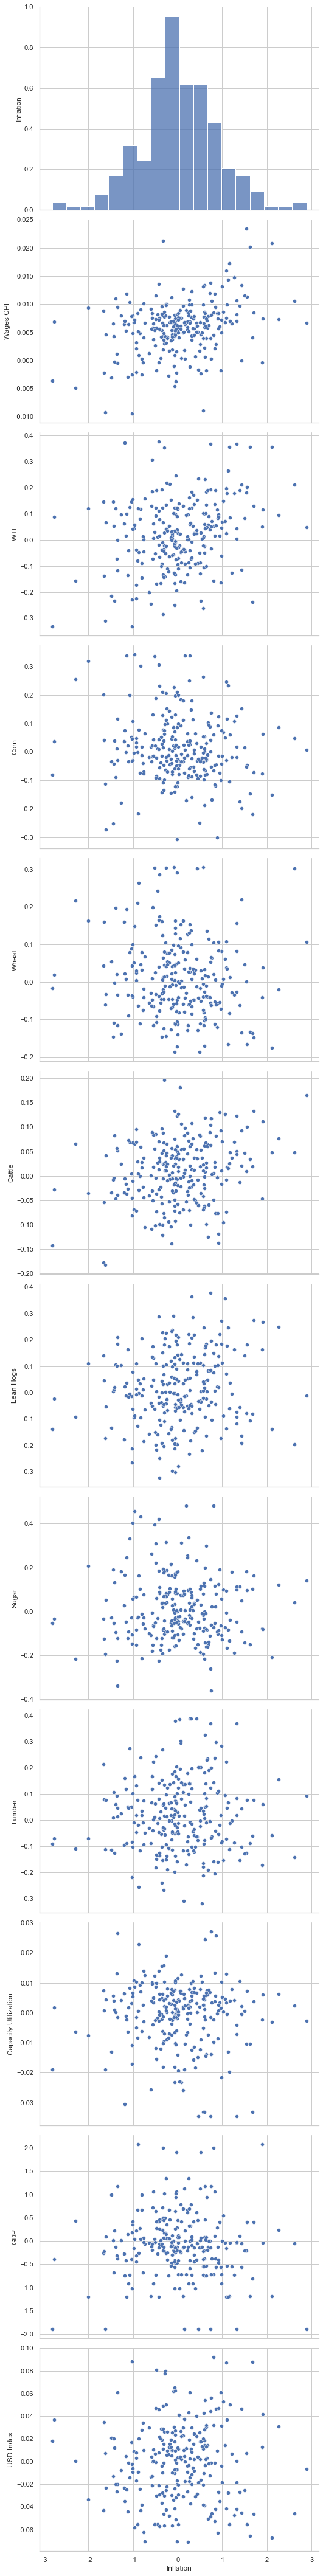

In [1025]:
sns.pairplot(QonQ_main_cpi_pre,
            y_vars = ['Inflation','Wages CPI','WTI','Corn','Wheat','Cattle','Lean Hogs','Sugar','Lumber',
                         'Capacity Utilization','GDP','USD Index'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Text(0.5, 1.0, 'Quarter on Quarter Comparison')

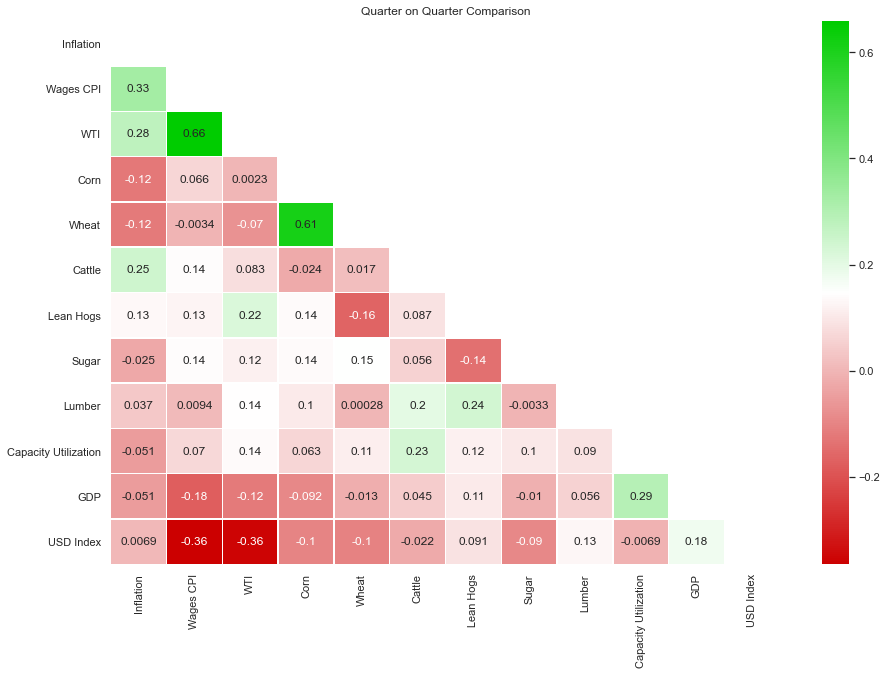

In [1026]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_cpi_pre.corr())
sns.heatmap(QonQ_main_cpi_pre.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison')

**This also appears to yield even worse results**; with the exception of `Cattle`. 

# 1.4.5 Managing Outliers with Winsorizing